In [3]:
# Set Keras 3 backend to PyTorch and enable CUDA
import os
os.environ["KERAS_BACKEND"] = "torch"

import keras
keras.config.set_backend("torch")

import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Keras backend:", keras.backend.backend())
print("PyTorch CUDA available:", torch.cuda.is_available())
print("Selected device:", device)

Keras backend: torch
PyTorch CUDA available: True
Selected device: cuda


In [4]:

import sys
sys.path.append(os.path.abspath("../src"))

from data.loader import load_and_clean_raw_dataset



# --- Global config
LOOKBACK = 20
BATCH_SIZE = 32
LATENT_DIM = 12
SURFACE_SHAPE = (11, 10)
FEATURE_DIM = LOOKBACK * (11 * 10 + 1 + 32)

TARGET_DATE = "2025-05-21"
TARGET_STRIKE = 1.0
TARGET_TAU = 1.0

USE_PREPROCESSED_INPUTS = False


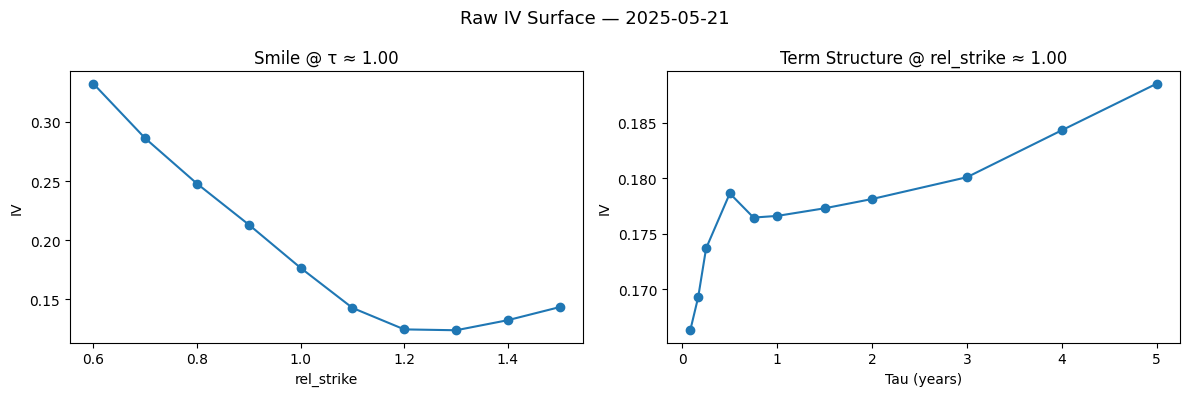

In [5]:

from data.loader import load_and_clean_raw_dataset

df = load_and_clean_raw_dataset("../data/vol_tensor_dataset.csv")


from utils.plotting import plot_raw_iv_slice

plot_raw_iv_slice(df, target_date=TARGET_DATE, target_strike=TARGET_STRIKE, target_tau=TARGET_TAU,)



In [6]:
from data.dataset_builder import build_full_surface_feature_df

# Load enriched surface + features
df_all = build_full_surface_feature_df("../data/vol_tensor_dataset.csv")

# Identify IV and feature columns
iv_cols = [c for c in df_all.columns if c.startswith("IV_")]
feat_cols = [c for c in df_all.columns if not c.startswith("IV_")]
df_all = df_all.dropna(subset=feat_cols)

print("Final DataFrame shape:", df_all.shape)
print("Surface columns:", len(iv_cols), "| Feature columns:", len(feat_cols))
print("IV column sample:", iv_cols[:5])
print("Feature column sample:", feat_cols[:5])
print(df_all.columns)


Final DataFrame shape: (1265, 136)
Surface columns: 110 | Feature columns: 26
IV column sample: ['IV_1m_0.60', 'IV_1m_0.70', 'IV_1m_0.80', 'IV_1m_0.90', 'IV_1m_1.00']
Feature column sample: ['log_return', 'log_return_ma20', 'log_return_z20', 'realized_vol_5d', 'realized_vol_5d_ma20']
Index(['IV_1m_0.60', 'IV_1m_0.70', 'IV_1m_0.80', 'IV_1m_0.90', 'IV_1m_1.00',
       'IV_1m_1.10', 'IV_1m_1.20', 'IV_1m_1.30', 'IV_1m_1.40', 'IV_1m_1.50',
       ...
       'slope_10_30', 'smile_skew', 'smile_convexity', 'ts_level', 'ts_slope',
       'ts_curvature', 'ts_weighted', 'ts_short_avg', 'ts_long_avg',
       'ts_split_slope'],
      dtype='object', length=136)


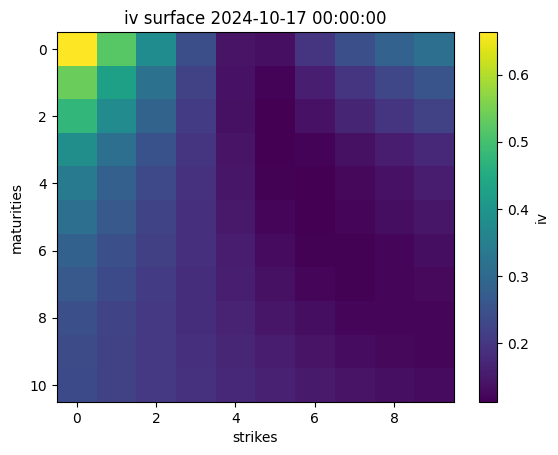


surface 2024-10-17 00:00:00


strike       0.6     0.7     0.8     0.9     1.0     1.1     1.2     1.3  \
maturity                                                                   
18m       0.6631  0.5192  0.3801  0.2444  0.1423  0.1363  0.1959  0.2470   
1m        0.5384  0.4263  0.3186  0.2226  0.1406  0.1195  0.1597  0.1983   
1y        0.4763  0.3790  0.2884  0.2086  0.1381  0.1131  0.1399  0.1704   
2m        0.3852  0.3137  0.2517  0.1962  0.1429  0.1151  0.1195  0.1382   
2y        0.3399  0.2824  0.2342  0.1910  0.1461  0.1170  0.1137  0.1253   
3m        0.3139  0.2663  0.2264  0.1897  0.1508  0.1215  0.1134  0.1204   
3y        0.2845  0.2478  0.2165  0.1865  0.1560  0.1301  0.1172  0.1162   
4y        0.2674  0.2370  0.2111  0.1857  0.1601  0.1372  0.1229  0.1171   
5y        0.2483  0.2255  0.2052  0.1857  0.1659  0.1473  0.1327  0.1236   
6m        0.2395  0.2206  0.2035  0.1872  0.1712  0.1559  0.1426  0.1321   
9m        0.2363  0.2202  0.2053  0.1911  0.1772  0.1640  0.1524  0.1425   

strike       1.4     1.5  
maturity                  
18m       0.2855  0.3150  
1m        0.2308  0.2568  
1y        0.1977  0.2209  
2m        0.1580  0.1766  
2y        0.1404  0.1556  
3m        0.1329  0.1460  
3y        0.1236  0.1336  
4y        0.1197  0.1267  
5y        0.1200  0.1213  
6m        0.1251  0.1219  
9m        0.1350  0.1301

In [7]:
import matplotlib.pyplot as plt
import re
import numpy as np
import pandas as pd

# select random date
ix = np.random.randint(len(df_all))
date = df_all.index[ix]

# parse shape from columns
maturities = sorted(set(re.search(r"IV_(.*?)_", c).group(1) for c in iv_cols))
strikes = sorted(set(float(re.search(r"_(\d\.\d+)", c).group(1)) for c in iv_cols))

# extract surface
surface_values = df_all.iloc[ix][iv_cols].values.reshape(len(maturities), len(strikes))

# plot
plt.imshow(surface_values, cmap="viridis", aspect="auto")
plt.title(f"iv surface {date}")
plt.xlabel("strikes")
plt.ylabel("maturities")
plt.colorbar(label="iv")
plt.show()

# surface table
surface_df = pd.DataFrame(surface_values, index=maturities, columns=strikes)
surface_df.index.name = "maturity"
surface_df.columns.name = "strike"

print(f"\nsurface {date}")
display(surface_df.round(4))

In [8]:
from data.tensor_builder import prepare_surface_and_feature_tensors
from keras import ops

# Build tensors from cleaned DataFrames
tensors, X_feat_tensor, df_feat = prepare_surface_and_feature_tensors(
    df_all=df_all,
    df_raw=df,  # original raw dataframe is named df
    feat_cols=feat_cols,
    monthly_interpolation=False
)

# Print tensor shapes
print("Tensors built:")
for k, v in tensors.items():
    try:
        print(f"  • {k:20s}: {ops.shape(v)}")
    except Exception:
        print(f"  • {k:20s}: {type(v)}")

print("\nFeature tensor:", ops.convert_to_numpy(X_feat_tensor).shape)

print("Feature DataFrame:", df_feat.shape)

print("Feature columns:", df_feat.columns)

Tensors built:
  • date_tensor         : (1258,)
  • spot_tensor         : (1258,)
  • curve_tensor        : (1258, 32)
  • surface_tensor      : (1258, 11, 10, 6)
  • ssvi_tensor         : (1258, 11, 10, 3)
  • heston_tensor       : (1258, 11, 5)
  • strike_tensor       : (10,)
  • abs_strike_tensor   : (1258, 10)
  • dates               : <class 'list'>
  • maturities          : <class 'list'>
  • taus                : <class 'list'>
  • rel_strikes         : <class 'list'>
  • date_index          : <class 'dict'>
  • maturity_to_tau     : <class 'dict'>
  • iv_diff_tensor      : (1258, 11, 10, 7)

Feature tensor: (1258, 136)
Feature DataFrame: (1258, 26)
Feature columns: Index(['log_return', 'log_return_ma20', 'log_return_z20', 'realized_vol_5d',
       'realized_vol_5d_ma20', 'realized_vol_5d_z20', 'rate_0.25y',
       'rate_0.5y', 'rate_1y', 'rate_2y', 'rate_3y', 'rate_4y', 'rate_5y',
       'rate_10y', 'rate_30y', 'slope_5_10', 'slope_10_30', 'smile_skew',
       'smile_convexity

---
---

#PCA-VAR PIPELINE

PCA–VAR RMSE_σ: 0.0166


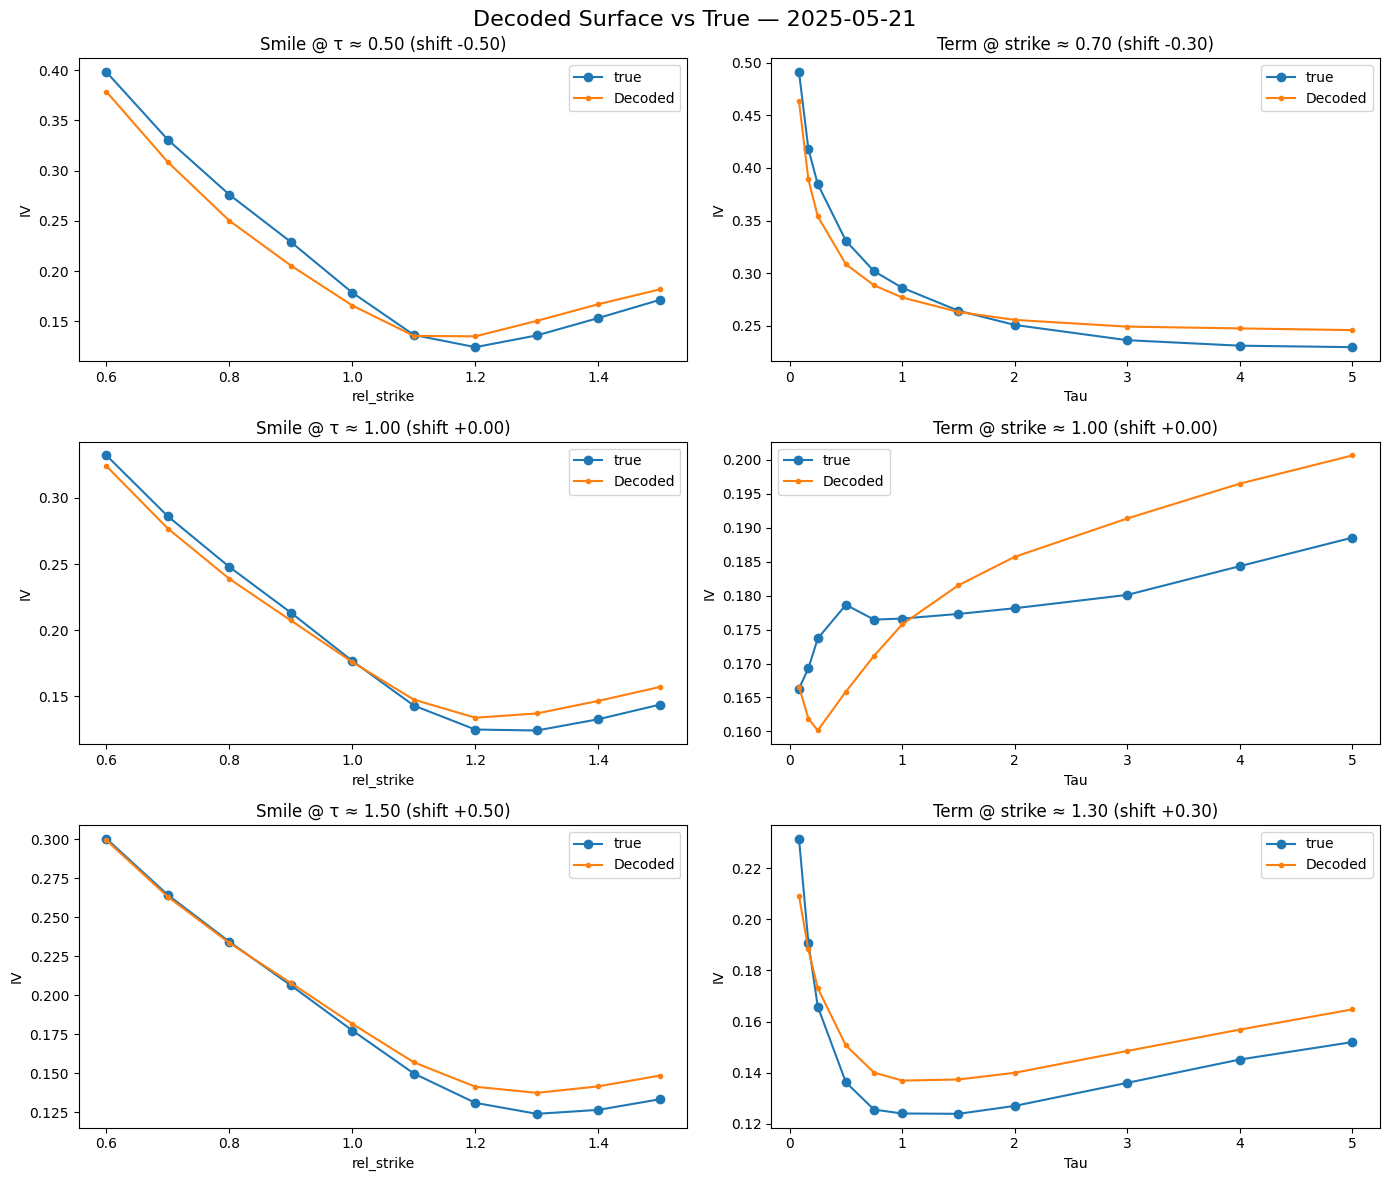

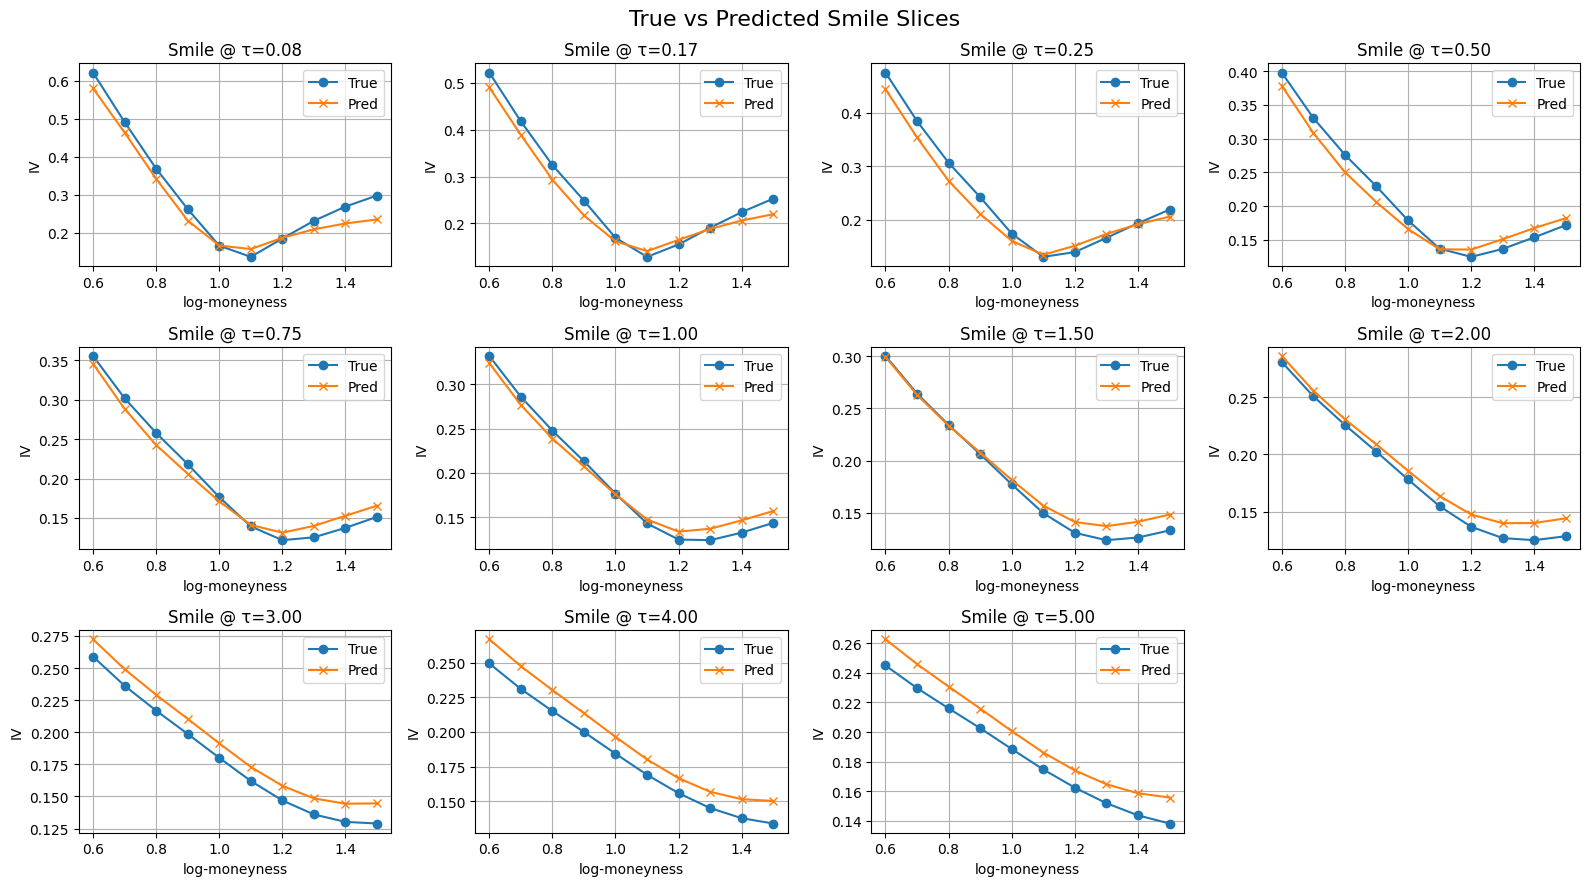

In [ ]:
from sklearn.decomposition import PCA
from statsmodels.tsa.api import VAR
from sklearn.metrics import root_mean_squared_error

# extract surface tensor and flatten
iv_surface = ops.convert_to_numpy(tensors["surface_tensor"])[..., -1]  # shape (T, M, K)
T, M, K = iv_surface.shape
X_surface_flat = iv_surface.reshape(T, M * K).astype(np.float64)

# align with features
feature_index = df_feat.index.intersection(df_all.index)
X_df = df_all.loc[feature_index, iv_cols]
F = df_feat.loc[feature_index]
X_grid = X_df.values.astype(np.float64)
F_aligned = F.values.astype(np.float64)

# demean surfaces
X_mean = X_grid.mean(axis=1, keepdims=True)
X_demeaned = X_grid - X_mean

# fit pca
pca_model = PCA(n_components=LATENT_DIM)
Z_all_pca = pca_model.fit_transform(X_demeaned)
Z_aug_pca = np.concatenate([Z_all_pca, F_aligned], axis=1)

# train test split
T_total = len(Z_aug_pca)
T_train = int(0.7 * T_total)
Z_train = Z_aug_pca[:T_train]
Z_test = Z_aug_pca[T_train:]
Z_train_pure = Z_all_pca[:T_train]

# var on augmented z
var_model = VAR(Z_train)
var_result = var_model.fit(maxlags=5)
Z_forecast_pca = var_result.forecast(Z_train[-var_result.k_ar:], steps=len(Z_test))
Z_forecast_pure = Z_forecast_pca[:, :LATENT_DIM]

# reconstruct surfaces
X_recon_demeaned = pca_model.inverse_transform(Z_forecast_pure)
X_mean_forecast = X_mean[T_train:T_train + len(X_recon_demeaned)]
X_pred_pca = X_recon_demeaned + X_mean_forecast
X_true_pca = X_grid[T_train:T_train + len(X_pred_pca)]

# calc rmse
rmse_pca = root_mean_squared_error(X_true_pca, X_pred_pca)
print(f"pca-var rmse: {rmse_pca:.4f}")

# reshape for plotting
X_true_pca = X_true_pca.reshape(-1, M, K)
X_pred_pca = X_pred_pca.reshape(-1, M, K)

from utils.plotting import plot_iv_slices_shifts, plot_smile_slices_comparison

# last surface for plots
true_surface_t = X_true_pca[-1]
recon_surface_t = X_pred_pca[-1]

plot_iv_slices_shifts(
    true_surface=true_surface_t,
    decoded_surface=recon_surface_t,
    taus=tensors["taus"],
    rel_strikes=ops.convert_to_numpy(tensors["strike_tensor"]),
    decoded_date=TARGET_DATE,
    target_tau=TARGET_TAU,
    target_strike=TARGET_STRIKE,
)

plot_smile_slices_comparison(
    true_surface=true_surface_t,
    pred_surface=recon_surface_t,
    rel_strikes=ops.convert_to_numpy(tensors["strike_tensor"]),
    taus=tensors["taus"],
)

---
---

# DATASET CREATION


---
---

In [10]:
from keras.models import load_model
from models.lstm import EncodedLatentSequence
from models.gru import GRUForecasterAugmented
from keras import ops
import numpy as np
from data.dataset import FeatureToLatentSequenceDataset

# load ae encoder
encoder = load_model("saved_models/ae/ae_encoder.keras")

# load ae decoder
decoder = load_model("saved_models/ae/ae_decoder.keras")

# full dataset for gru
full_dataset = FeatureToLatentSequenceDataset(
    surface_tensor=tensors["surface_tensor"],
    feature_tensor=X_feat_tensor,
    lookback=LOOKBACK,
    batch_size=BATCH_SIZE,
    global_indices=np.arange(T)
)
gru_input_gen = EncodedLatentSequence(full_dataset, encoder)

# load gru
gru_model = load_model("saved_models/gru/gru_model_ae.keras")

# forecast z(t+1)
Z_forecast_ae = gru_model.predict(gru_input_gen, verbose=0)

# optional demeaning
apply_demeaning = False
z_mean = ops.convert_to_numpy(ops.mean(Z_forecast_ae, axis=0, keepdims=True)) if apply_demeaning else 0.0
Z_forecast_demeaned = Z_forecast_ae - z_mean if apply_demeaning else Z_forecast_ae

# align surface slices
X_surface_all = ops.convert_to_numpy(tensors["surface_tensor"][..., -1].reshape(T, -1))
idx_eval = ops.convert_to_numpy(full_dataset.global_indices)[-len(Z_forecast_demeaned):]
Y_surface_flat = X_surface_all[idx_eval]

# decoder inputs
Z_decoder = Z_forecast_demeaned
Y_decoder = Y_surface_flat
F_aligned = ops.convert_to_numpy(X_feat_tensor[idx_eval])

# check dimensions
print(f"z_decoder: {Z_decoder.shape}")
print(f"y_decoder: {Y_decoder.shape}")
print(f"f_aligned: {F_aligned.shape}")

assert Z_forecast_demeaned.shape[0] == len(idx_eval), "forecast length mismatch"
assert Z_forecast_demeaned.shape[0] == Y_surface_flat.shape[0], "surface mismatch"
assert Z_forecast_demeaned.shape[0] == F_aligned.shape[0], "feature mismatch"

print("ae-gru pipeline loaded")

z_decoder: (1216, 12)
y_decoder: (1216, 110)
f_aligned: (1216, 136)
ae-gru pipeline loaded


In [11]:
import importlib
import data.dataset
importlib.reload(data.dataset)

from data.tensor_builder import split_time_series_indices
from keras import ops
import pandas as pd

T = tensors["surface_tensor"].shape[0]
train_idx, val_idx, test_idx = split_time_series_indices(T)

target_date = pd.Timestamp("2025-05-21")
idx = np.where(tensors["date_tensor"] == target_date)[0][0]

print("DATEs CHECK")
print("Target global index:", idx)
print("Train:", train_idx[[0, -1]])
print("Val:", val_idx[[0, -1]])
print("Test:", test_idx[[0, -1]])
print("In test?", idx in test_idx)


DATEs CHECK
Target global index: 1257
Train: [  0 879]
Val: [ 880 1068]
Test: [1069 1257]
In test? True


x_pred shape: (1216, 110)

atm index check
target: 1.0
strike val: 1.0
k_idx: 4
actual strike: 1.0
atm from plot: [0.16631064 0.16929014 0.17368743 0.17863896 0.17646223 0.176611
 0.17729895 0.17813316 0.18009801 0.18432647 0.18852447]
atm index 4: [0.16631064 0.16929014 0.17368743 0.17863896 0.17646223 0.176611
 0.17729895 0.17813316 0.18009801 0.18432647 0.18852447]
equal: True
vae-gru decoded RMSE_σ: 0.0199
RMSE by maturity (mean ± std): 0.0205 ± 0.0074
RMSE by strike    (mean ± std): 0.0213 ± 0.0047


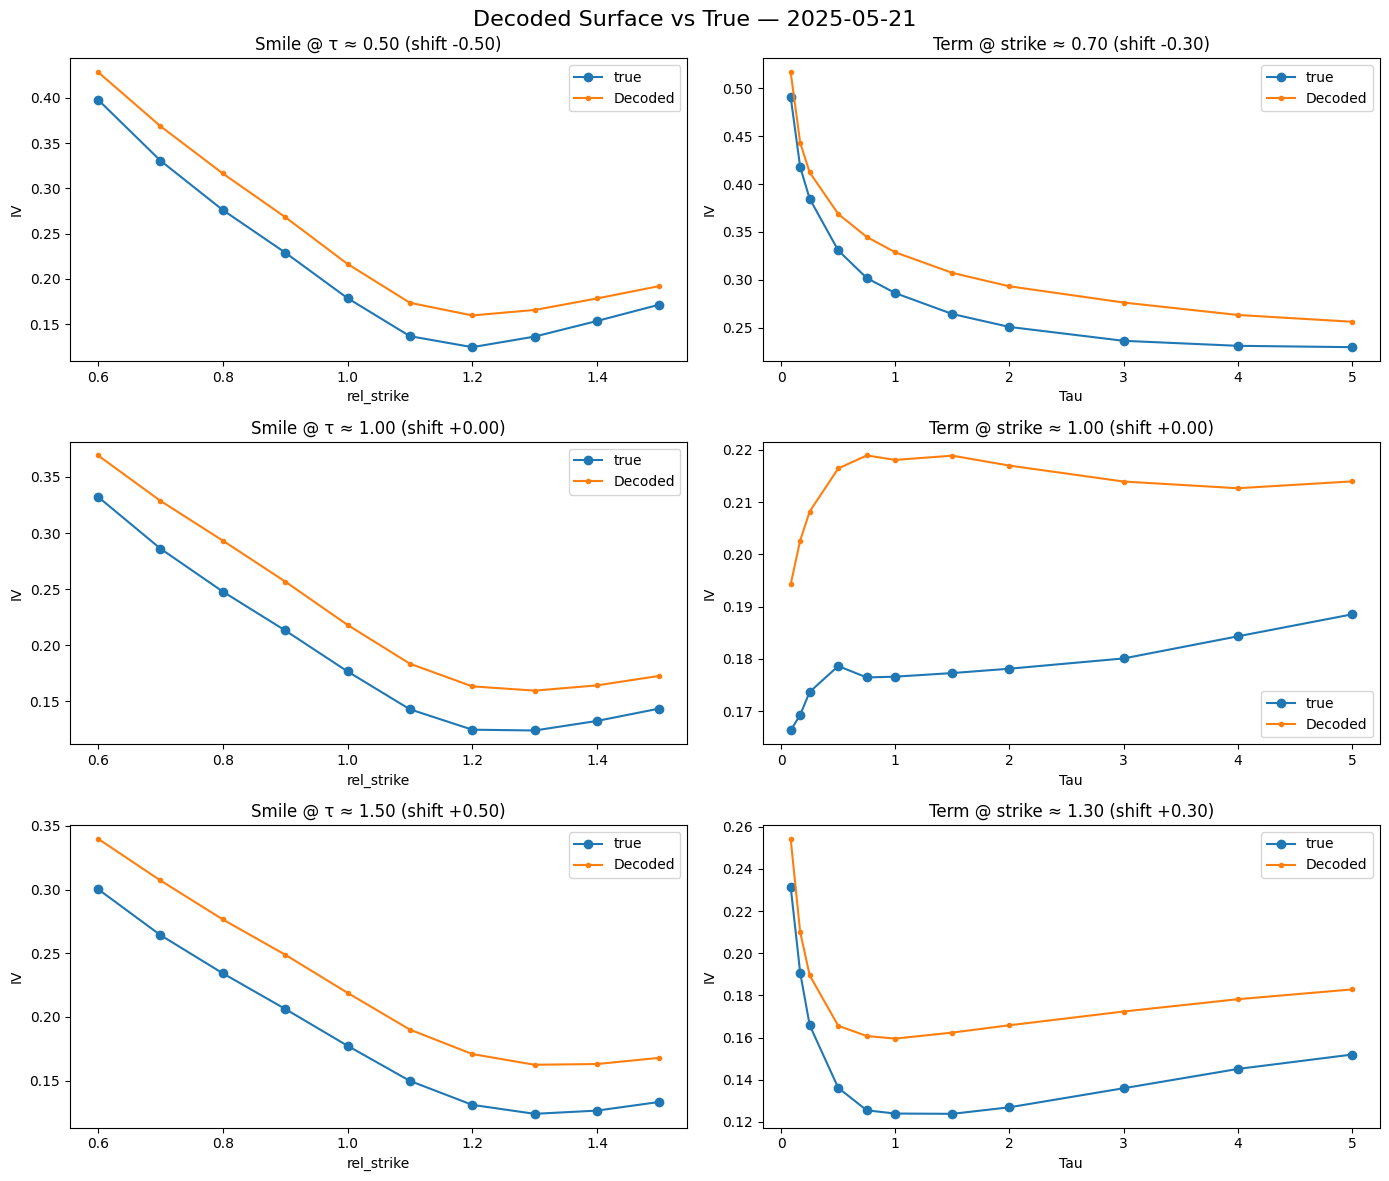

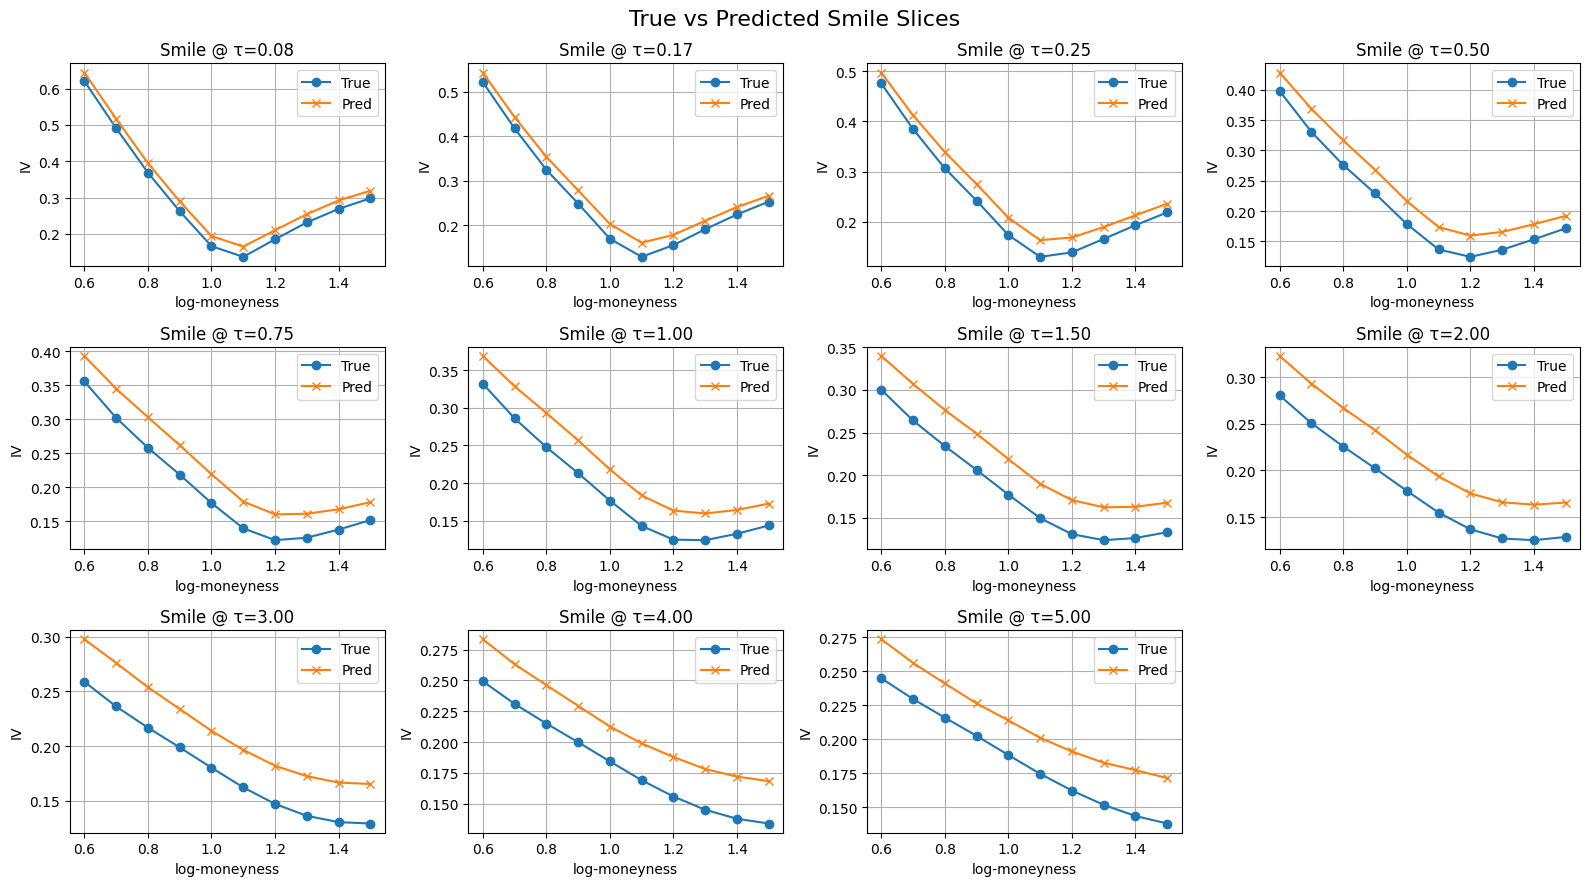

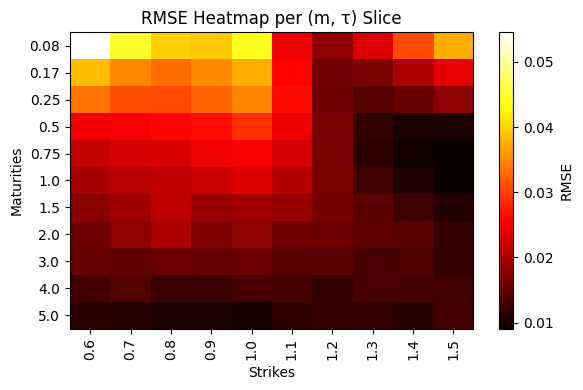

In [12]:
import importlib
import utils.eval
importlib.reload(utils.eval)
import utils.plotting
importlib.reload(utils.plotting)

from utils.eval import evaluate_decoder_output

# predict surfaces from gru z
X_pred_raw = decoder.predict(Z_decoder, verbose=0)[:, :M * K]
print("x_pred shape:", X_pred_raw.shape)

# debug atm indexing
print("\natm index check")
target_strike = TARGET_STRIKE
k_shift = 0.0
strike_val = target_strike + k_shift
rel_strikes = ops.convert_to_numpy(tensors["strike_tensor"])
k_idx = np.argmin(np.abs(rel_strikes - strike_val))

print(f"target: {target_strike}")
print(f"strike val: {strike_val}")
print(f"k_idx: {k_idx}")
print(f"actual strike: {rel_strikes[k_idx]}")

# compare ground truth
Y_decoder_reshaped = Y_decoder.reshape(-1, M, K)
print(f"atm from plot: {Y_decoder_reshaped[-1, :, k_idx]}")
print(f"atm index 4: {Y_decoder_reshaped[-1, :, 4]}")
print(f"equal: {np.array_equal(Y_decoder_reshaped[-1, :, k_idx], Y_decoder_reshaped[-1, :, 4])}")

# evaluate
evaluate_decoder_output(
   decoder=decoder,
   Z_forecast=Z_decoder,
   X_grid=Y_decoder,
   X_true_idx=None,
   tensors=tensors,
   rel_strikes=ops.convert_to_numpy(tensors["strike_tensor"]),
   taus=ops.convert_to_numpy(tensors["taus"]),
   target_date=TARGET_DATE,
   target_tau=TARGET_TAU,
   target_strike=TARGET_STRIKE,
   decoded_surfaces_override=X_pred_raw,
   title="vae-gru decoded"
)

---
---

# POINTWISE DECODER 

---
---

In [13]:
import models.decoder
import importlib
importlib.reload(models.decoder)

from models.decoder import PiecewiseSurfaceDecoder
from keras.optimizers import Adam

print("training data shapes")
print(f"z_decoder shape: {Z_decoder.shape}")
print(f"f_aligned shape: {F_aligned.shape}")
print(f"y_decoder shape: {Y_decoder.shape}")
print(f"latent_dim: {LATENT_DIM}")
print(f"m: {M}, k: {K}")

# setup decoder with feature conditioning
decoder_pw = PiecewiseSurfaceDecoder(
  latent_dim=LATENT_DIM,
  M=M,
  K=K,
  feature_dim=F_aligned.shape[1]
)
print(f"decoder feature_dim: {decoder_pw.feature_dim}")
print(f"expected input dim: {LATENT_DIM + F_aligned.shape[1] + 2}")  # z + f + (m,tau)

decoder_pw.compile(optimizer=Adam(learning_rate=5e-5), loss="mse")

# get grid coords
rel_strikes = ops.convert_to_numpy(tensors["strike_tensor"])
taus = ops.convert_to_numpy(tensors["taus"])
print(f"rel_strikes shape: {rel_strikes.shape}")
print(f"taus shape: {taus.shape}")

# flatten surfaces for training
Y_surface_full = Y_decoder.reshape(-1, M * K)
print(f"y_surface_full shape: {Y_surface_full.shape}")

# split data
N_total = len(Z_decoder)
train_split = int(0.7 * N_total)
val_split = int(0.85 * N_total)

Z_train, Z_val, Z_test = np.split(Z_decoder, [train_split, val_split])
F_train, F_val, F_test = np.split(F_aligned, [train_split, val_split])
Y_train, Y_val, Y_test = np.split(Y_surface_full, [train_split, val_split])

print(f"\nsplit shapes:")
print(f"z_train: {Z_train.shape}, f_train: {F_train.shape}, y_train: {Y_train.shape}")
print(f"z_val: {Z_val.shape}, f_val: {F_val.shape}, y_val: {Y_val.shape}")
print(f"z_test: {Z_test.shape}, f_test: {F_test.shape}, y_test: {Y_test.shape}")

# build pointwise samples from surface data
[X_zf_train, X_m_train, X_tau_train], y_train = decoder_pw.build_training_data_from_surfaces(
  Z_train, Y_train, strike_tensor=rel_strikes, tau_tensor=taus, F_features=F_train
)
[X_zf_val, X_m_val, X_tau_val], y_val = decoder_pw.build_training_data_from_surfaces(
  Z_val, Y_val, strike_tensor=rel_strikes, tau_tensor=taus, F_features=F_val
)
[X_zf_test, X_m_test, X_tau_test], y_test = decoder_pw.build_training_data_from_surfaces(
  Z_test, Y_test, strike_tensor=rel_strikes, tau_tensor=taus, F_features=F_test
)

print(f"\ntraining data shapes:")
print(f"x_zf_train: {X_zf_train.shape}")
print(f"x_m_train: {X_m_train.shape}")
print(f"x_tau_train: {X_tau_train.shape}")
print(f"y_train: {y_train.shape}")

# keras expects list inputs
X_train = [X_zf_train, X_m_train, X_tau_train]
X_val = [X_zf_val, X_m_val, X_tau_val]
X_test = [X_zf_test, X_m_test, X_tau_test]

print(f"\nfinal input shapes:")
print(f"x_train[0] (zf): {X_train[0].shape}")
print(f"x_train[1] (m): {X_train[1].shape}")
print(f"x_train[2] (tau): {X_train[2].shape}")

training data shapes
z_decoder shape: (1216, 12)
f_aligned shape: (1216, 136)
y_decoder shape: (1216, 110)
latent_dim: 12
m: 11, k: 10
decoder feature_dim: 136
expected input dim: 150
rel_strikes shape: (10,)
taus shape: (11,)
y_surface_full shape: (1216, 110)

split shapes:
z_train: (851, 12), f_train: (851, 136), y_train: (851, 110)
z_val: (182, 12), f_val: (182, 136), y_val: (182, 110)
z_test: (183, 12), f_test: (183, 136), y_test: (183, 110)

training data shapes:
x_zf_train: (93610, 148)
x_m_train: (93610, 1)
x_tau_train: (93610, 1)
y_train: (93610, 1)

final input shapes:
x_train[0] (zf): (93610, 148)
x_train[1] (m): (93610, 1)
x_train[2] (tau): (93610, 1)


In [14]:
# baseline decoder without features
decoder_no_feat = PiecewiseSurfaceDecoder(
   latent_dim=LATENT_DIM,
   M=M,
   K=K,
   feature_dim=0
)

decoder_no_feat.compile(optimizer=Adam(learning_rate=5e-5), loss="mse")

# build training data - latents only
[X_latent_train_no_feat, X_m_train_no_feat, X_tau_train_no_feat], y_train_no_feat = decoder_no_feat.build_training_data_from_surfaces(
   Z_train, Y_train, strike_tensor=rel_strikes, tau_tensor=taus, F_features=None
)
[X_latent_val_no_feat, X_m_val_no_feat, X_tau_val_no_feat], y_val_no_feat = decoder_no_feat.build_training_data_from_surfaces(
   Z_val, Y_val, strike_tensor=rel_strikes, tau_tensor=taus, F_features=None
)
[X_latent_test_no_feat, X_m_test_no_feat, X_tau_test_no_feat], y_test_no_feat = decoder_no_feat.build_training_data_from_surfaces(
   Z_test, Y_test, strike_tensor=rel_strikes, tau_tensor=taus, F_features=None
)

# pack inputs
X_train_no_feat = [X_latent_train_no_feat, X_m_train_no_feat, X_tau_train_no_feat]
X_val_no_feat = [X_latent_val_no_feat, X_m_val_no_feat, X_tau_val_no_feat]
X_test_no_feat = [X_latent_test_no_feat, X_m_test_no_feat, X_tau_test_no_feat]

In [15]:
# debug cell to see dimensions

# check temporal ordering
print("first few z_decoder indices (should be early dates):")
print(f"z_decoder[0:5] shape: {Z_decoder[0:5].shape}")

print("\nlast few z_decoder indices (should be late dates):")
print(f"z_decoder[-5:] shape: {Z_decoder[-5:].shape}")

# split boundaries
print(f"\nsplit boundaries:")
print(f"train: 0 to {train_split}")
print(f"val: {train_split} to {val_split}")  
print(f"test: {val_split} to {N_total}")

# check original data source
print(f"\noriginal idx_eval (from gru forecasting):")
print(f"idx_eval[:10]: {idx_eval[:10]}")
print(f"idx_eval[-10:]: {idx_eval[-10:]}")
print(f"total time steps t: {T}")

# verify sequential
is_sequential = np.all(np.diff(idx_eval) == 1)
print(f"idx_eval is sequential: {is_sequential}")

first few z_decoder indices (should be early dates):
z_decoder[0:5] shape: (5, 12)

last few z_decoder indices (should be late dates):
z_decoder[-5:] shape: (5, 12)

split boundaries:
train: 0 to 851
val: 851 to 1033
test: 1033 to 1216

original idx_eval (from gru forecasting):
idx_eval[:10]: [42 43 44 45 46 47 48 49 50 51]
idx_eval[-10:]: [1248 1249 1250 1251 1252 1253 1254 1255 1256 1257]
total time steps t: 1258
idx_eval is sequential: True


In [16]:
import importlib
import models.decoder_losses
importlib.reload(models.decoder_losses)
from models.decoder_losses import create_black_scholes_hybrid_loss, create_mse_vega_hybrid_loss    


hybrid_loss_fn, vega_weights, gamma_weights = create_black_scholes_hybrid_loss(
    taus, rel_strikes, M, K, 
    mse_weight=0.5, vega_weight=0.2, gamma_weight=0.3
)

decoder_pw.compile(
    optimizer=Adam(learning_rate=1e-5, clipnorm=1),
    loss=hybrid_loss_fn
)


Epoch 1/100
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 25s 9ms/step - loss: 5.6425 - val_loss: 0.3773 - learning_rate: 1.0000e-05
Epoch 2/100
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 24s 8ms/step - loss: 0.2682 - val_loss: 0.2803 - learning_rate: 1.0000e-05
Epoch 3/100
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 24s 8ms/step - loss: 0.2242 - val_loss: 0.2612 - learning_rate: 1.0000e-05
Epoch 4/100
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 24s 8ms/step - loss: 0.2039 - val_loss: 0.2489 - learning_rate: 1.0000e-05
Epoch 5/100
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 24s 8ms/step - loss: 0.1889 - val_loss: 0.2412 - learning_rate: 1.0000e-05
Epoch 6/100
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 24s 8ms/step - loss: 0.1791 - val_loss: 0.2283 - learning_rate: 1.0000e-05
Epoch 7/100
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 24s 8ms/step - loss: 0.1703 - val_loss: 0.2134 - learning_rate: 1.0000e-05
Epoch 8/100
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 24s 8ms/step - loss: 0.1556 - val_loss: 0.1988 - learning_rate: 1.0000e-05
Epoch 9/100
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 24s 8ms/step 

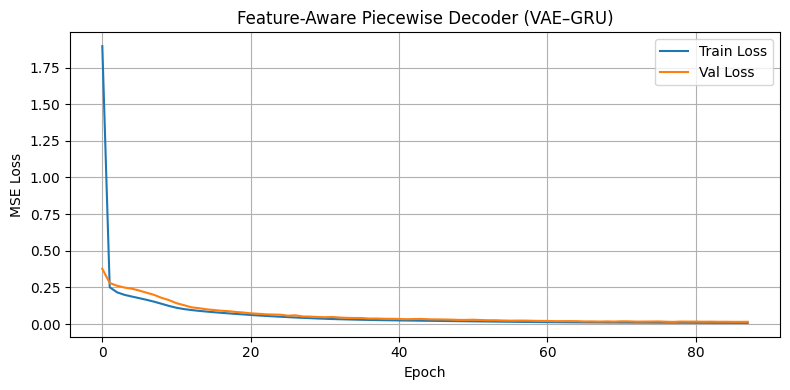

In [17]:
import os
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# usual training loop
os.makedirs("saved_models/piecewise_surface", exist_ok=True)
callbacks = [
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True, min_delta=1e-5, verbose=0),
    ReduceLROnPlateau(monitor="val_loss", factor=0.66, patience=5, min_lr=1e-7),
    ModelCheckpoint("saved_models/piecewise_surface/decoder_bs_loss_ae.keras", save_best_only=True)
]


history = decoder_pw.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=100,
    callbacks=callbacks,
    verbose=1
)

plt.figure(figsize=(8, 4))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Feature-Aware Piecewise Decoder (VAE–GRU)")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


y_hat shape: (1216, 11, 10)
y_full shape: (1216, 110)
Evaluation dimensions: N=1216, M=11, K=10
Piecewise Decoder with BS Loss_AE RMSE_σ: 0.0095
RMSE by maturity (mean ± std): 0.0098 ± 0.0049
RMSE by strike    (mean ± std): 0.0108 ± 0.0017
Plotting last surface shapes: true=(11, 10), pred=(11, 10)


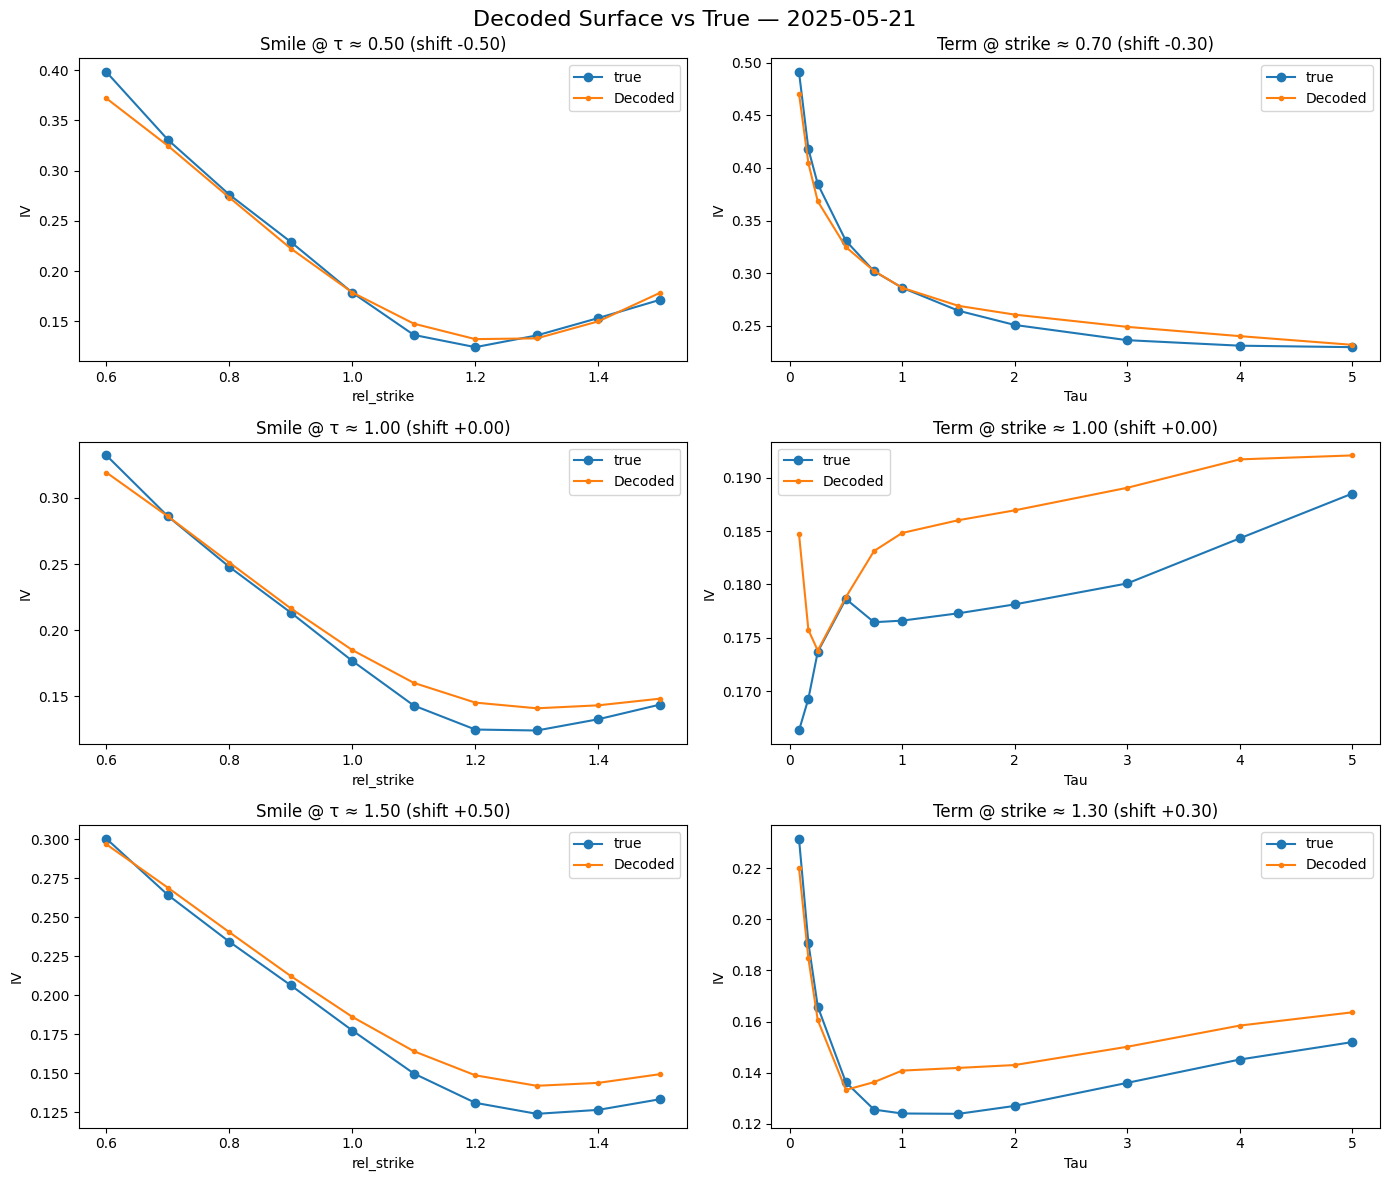

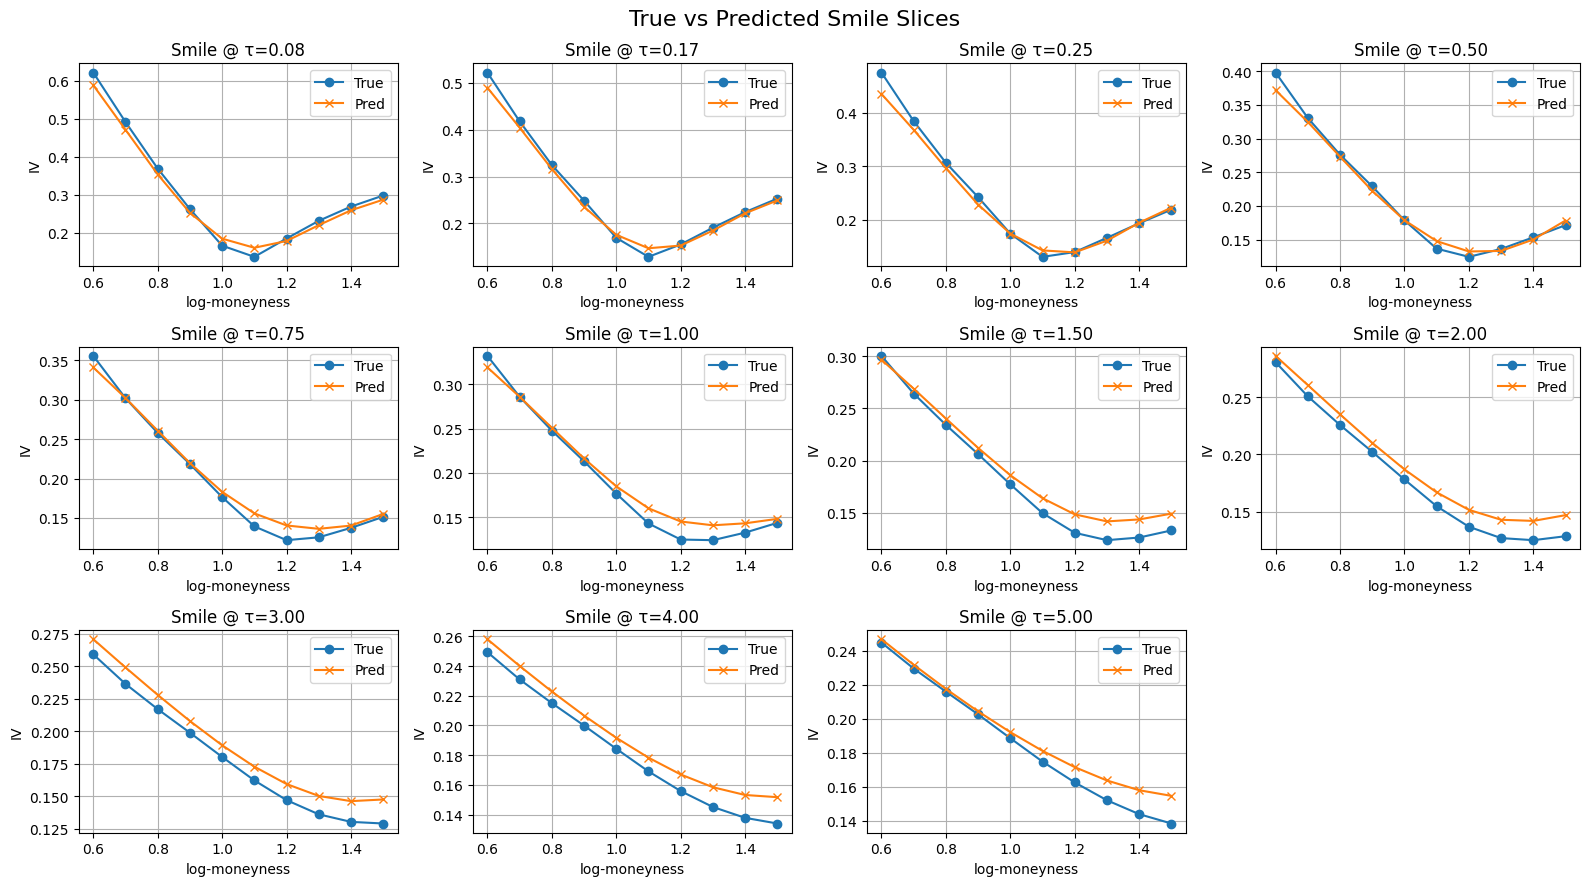

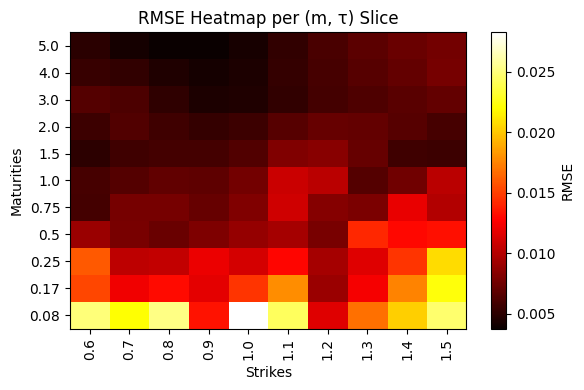

{'rmse_overall': 0.009513793,
 'rmse_by_maturity': array([0.02179951, 0.01504827, 0.01333167, 0.01018428, 0.00875016,
        0.00810171, 0.00649983, 0.00626513, 0.00588948, 0.00578996,
        0.00559029], dtype=float32),
 'rmse_by_strike': array([0.01137018, 0.00983685, 0.01050793, 0.00819996, 0.01157635,
        0.0120419 , 0.0083679 , 0.0100343 , 0.01175766, 0.013995  ],
       dtype=float32)}

In [18]:
import models.decoder
import utils.plotting
import utils.eval
import importlib
importlib.reload(models.decoder)
importlib.reload(utils.plotting)
importlib.reload(utils.eval)

from utils.eval import evaluate_decoder_output_v2

# eval config
Z_eval = Z_decoder            # (N, latent_dim)
F_eval = F_aligned            # (N, feature_dim)
Y_full = Y_decoder            # (N, M*K) flattened ground truth

# prepare strike-tau grid
m_grid, tau_grid = np.meshgrid(
  ops.convert_to_numpy(tensors["strike_tensor"]),
  ops.convert_to_numpy(tensors["taus"])
)
m_flat = m_grid.reshape(-1, 1).astype(np.float32)
tau_flat = tau_grid.reshape(-1, 1).astype(np.float32)

# generate predictions
Y_hat = np.stack([
  decoder_pw.predict_surface(z, f, m_flat, tau_flat)
  for z, f in zip(Z_eval, F_eval)
])

print(f"y_hat shape: {Y_hat.shape}")
print(f"y_full shape: {Y_full.shape}")

# run evaluation
evaluate_decoder_output_v2(
   Y_pred=Y_hat,                          # (N, M, K)
   Y_true=Y_full,                         # (N, M*K) auto-reshaped
   tensors=tensors,
   rel_strikes=ops.convert_to_numpy(tensors["strike_tensor"]),
   taus=ops.convert_to_numpy(tensors["taus"]),
   target_date=TARGET_DATE,
   target_tau=TARGET_TAU,
   target_strike=TARGET_STRIKE,
   decoder=decoder_pw,                    
   title="Piecewise Decoder with BS Loss_AE"
)

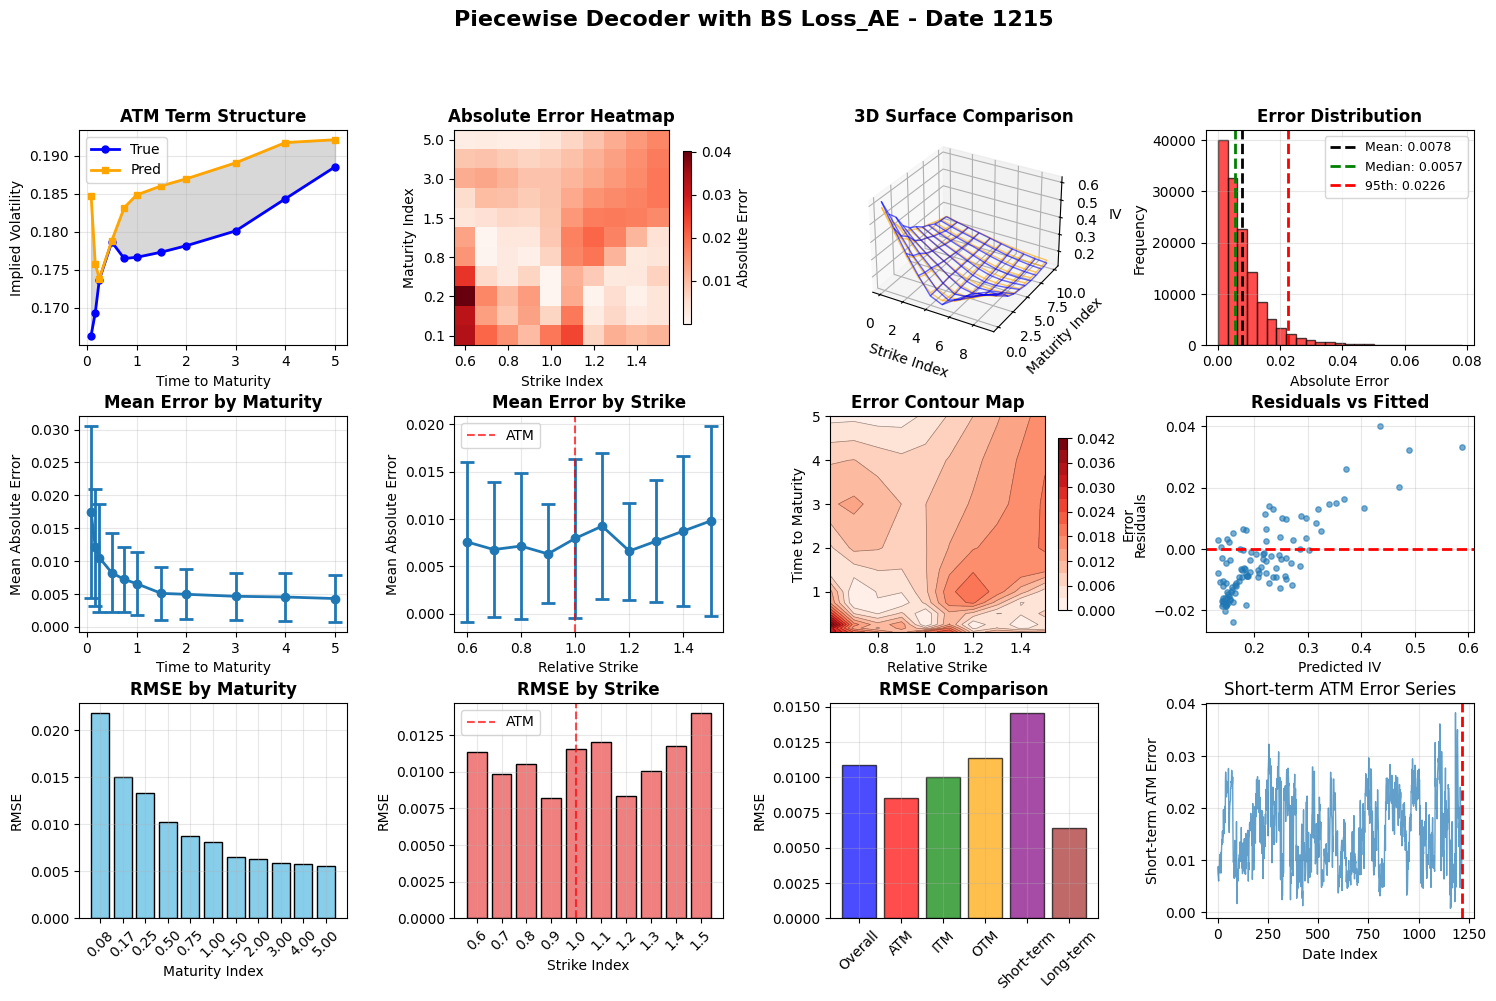

Overall Performance Category Performance  \
RMSE                           0.010897                  NaN   
MAE                            0.007785                  NaN   
Max Error                      0.078387                  NaN   
Mean Error                     0.007785                  NaN   
Median Error                   0.005673                  NaN   
95th Percentile                0.022640                  NaN   
ATM RMSE                            NaN             0.008502   
ITM RMSE                            NaN             0.010046   
OTM RMSE                            NaN             0.011400   
Short-term RMSE                     NaN             0.014558   
Long-term RMSE                      NaN             0.006411   
Short/Long Ratio                    NaN                2.271   
Best Maturity                       NaN                  NaN   
Worst Maturity                      NaN                  NaN   
Best Strike                         NaN                  NaN   
Worst Strike                        NaN                  NaN   
ATM Performance                     NaN                  NaN   
Overall Rank                        NaN                  NaN   
Short-term Bias                     NaN                  NaN   
ATM Issues                          NaN                  NaN   
Smile Asymmetry                     NaN                  NaN   
High Error Variance                 NaN                  NaN   
Model Quality                       NaN                  NaN   
Recommendation                      NaN                  NaN   

                      Best/Worst Performance          Diagnostic Flags  
RMSE                                     NaN                       NaN  
MAE                                      NaN                       NaN  
Max Error                                NaN                       NaN  
Mean Error                               NaN                       NaN  
Median Error                             NaN                       NaN  
95th Percentile                          NaN                       NaN  
ATM RMSE                                 NaN                       NaN  
ITM RMSE                                 NaN                       NaN  
OTM RMSE                                 NaN                       NaN  
Short-term RMSE                          NaN                       NaN  
Long-term RMSE                           NaN                       NaN  
Short/Long Ratio                         NaN                       NaN  
Best Maturity        τ=5.00 (RMSE: 0.005590)                       NaN  
Worst Maturity       τ=0.08 (RMSE: 0.021800)                       NaN  
Best Strike           K=0.9 (RMSE: 0.008200)                       NaN  
Worst Strike          K=1.5 (RMSE: 0.013995)                       NaN  
ATM Performance       K=1.0 (RMSE: 0.011576)                       NaN  
Overall Rank              ATM ranks #3 of 10                       NaN  
Short-term Bias                          NaN        YES (ratio: 2.271)  
ATM Issues                               NaN   NO (ATM/Overall: 0.78x)  
Smile Asymmetry                          NaN  NO (|ITM-OTM|: 0.001354)  
High Error Variance                      NaN       YES (std: 0.007625)  
Model Quality                            NaN                      GOOD  
Recommendation                           NaN         Needs Improvement

In [19]:
import models.decoder
import importlib
importlib.reload(models.decoder)

import utils.plot_error
importlib.reload(utils.plot_error)
from utils.plot_error import analyze_decoder_comprehensive

# eval config
Z_eval = Z_decoder            # (N, latent_dim)
F_eval = F_aligned            # (N, feature_dim)
Y_full = Y_decoder            # (N, M*K) flattened

# setup grid
m_grid, tau_grid = np.meshgrid(
  ops.convert_to_numpy(tensors["strike_tensor"]),
  ops.convert_to_numpy(tensors["taus"])
)
m_flat = m_grid.reshape(-1, 1).astype(np.float32)
tau_flat = tau_grid.reshape(-1, 1).astype(np.float32)

# generate predictions
Y_hat = np.stack([
  decoder_pw.predict_surface(z, f, m_flat, tau_flat)
  for z, f in zip(Z_eval, F_eval)
])

# reshape ground truth to match
Y_full = Y_decoder.reshape(-1, decoder_pw.M, decoder_pw.K)

# run comprehensive analysis
metrics = analyze_decoder_comprehensive(
  Y_true=Y_full,              
  Y_pred=Y_hat,               
  taus=ops.convert_to_numpy(tensors["taus"]),
  rel_strikes=ops.convert_to_numpy(tensors["strike_tensor"]),
  date_idx=-1,                # last date
  dates=None,                 
  title="Piecewise Decoder with BS Loss_AE"
)

In [20]:
from utils.plot_error import summarize_decoder_errors, collect_decoder_summaries


#tracking function 
summary_pw_decoder = summarize_decoder_errors(
    Y_true=Y_full, 
    Y_pred=Y_hat,
    taus=taus, 
    rel_strikes=rel_strikes,
    name="Piecewise Decoder with BS LossAE",
    model=decoder_pw
)


summary_all_decoders = collect_decoder_summaries(
    summary_pw_decoder,
    # add names here / check numbering 
)

display(summary_all_decoders)

Name  Rank Overall_RMSE Overall_MAE  ATM_RMSE  \
0  Piecewise Decoder with BS LossAE     1     0.010897    0.007785  0.011576   

    ATM_MAE  ITM_RMSE  OTM_RMSE Short_Long_Ratio Max_Error  Short_Term_Bias  \
0  0.007950  0.010046  0.011400         2.270829  0.078387             True   

   ATM_Issues Model_Quality  Production_Ready  
0       False          GOOD             False

smoothing impact: 0.006120
Evaluation dimensions: N=10, M=11, K=10
Smoothed Piecewise Decoder (Feature-Aware) RMSE_σ: 0.0185
RMSE by maturity (mean ± std): 0.0225 ± 0.0189
RMSE by strike    (mean ± std): 0.0246 ± 0.0162
Plotting last surface shapes: true=(11, 10), pred=(11, 10)


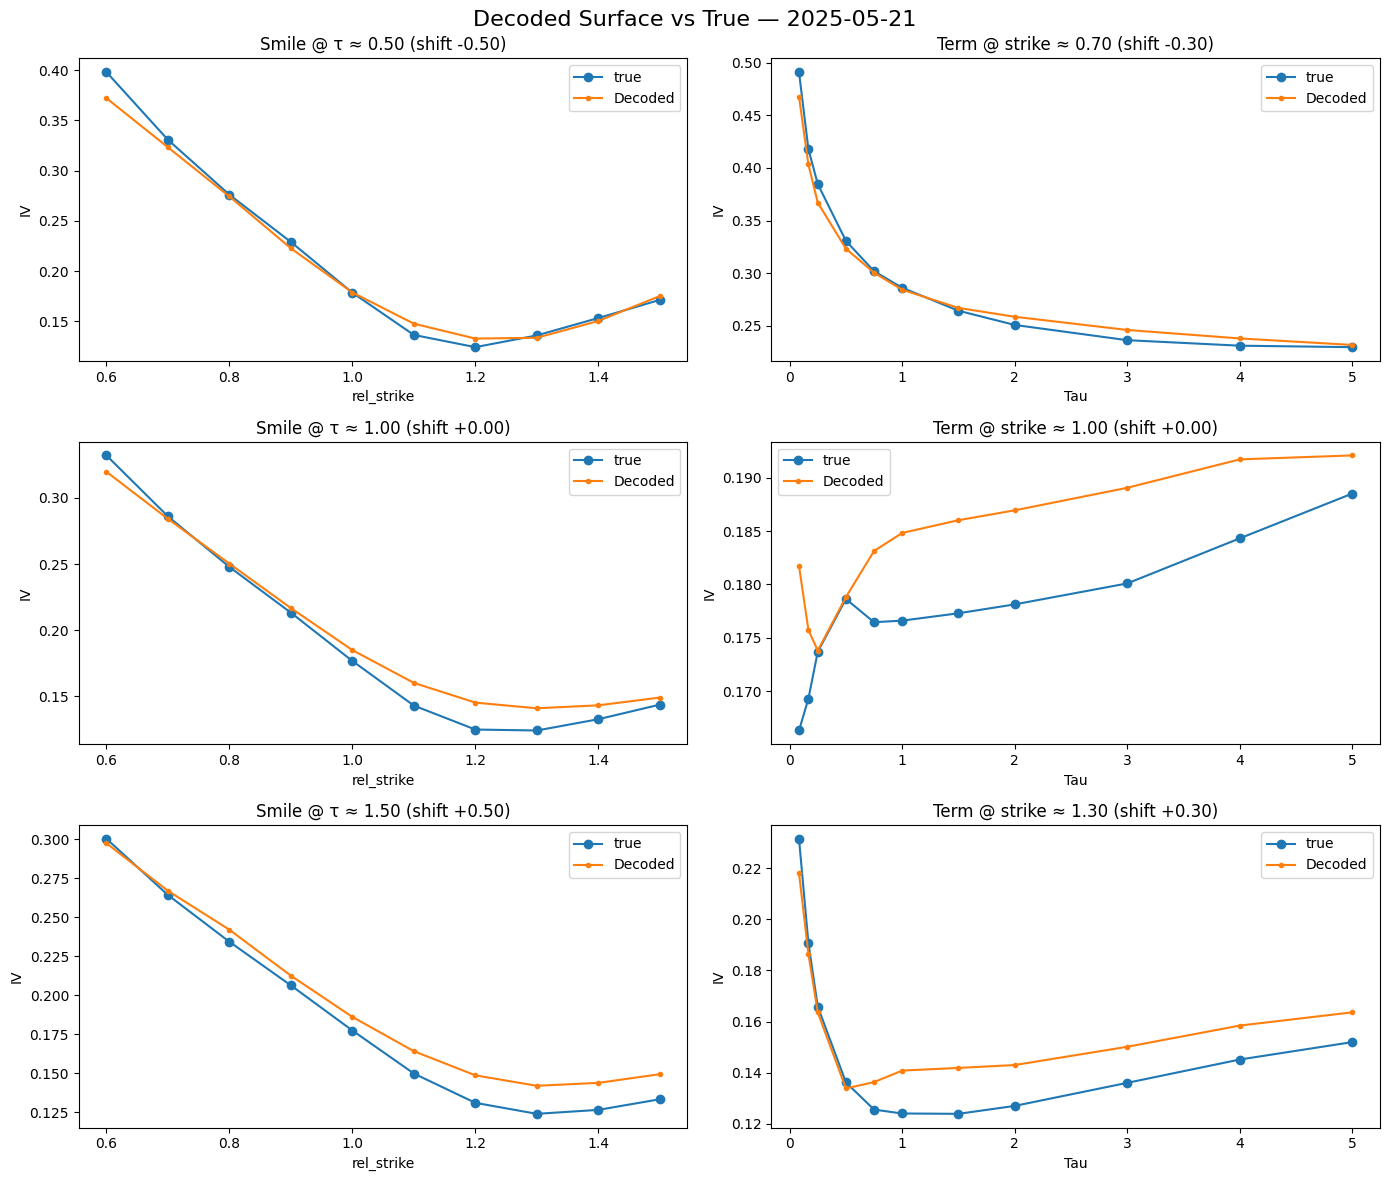

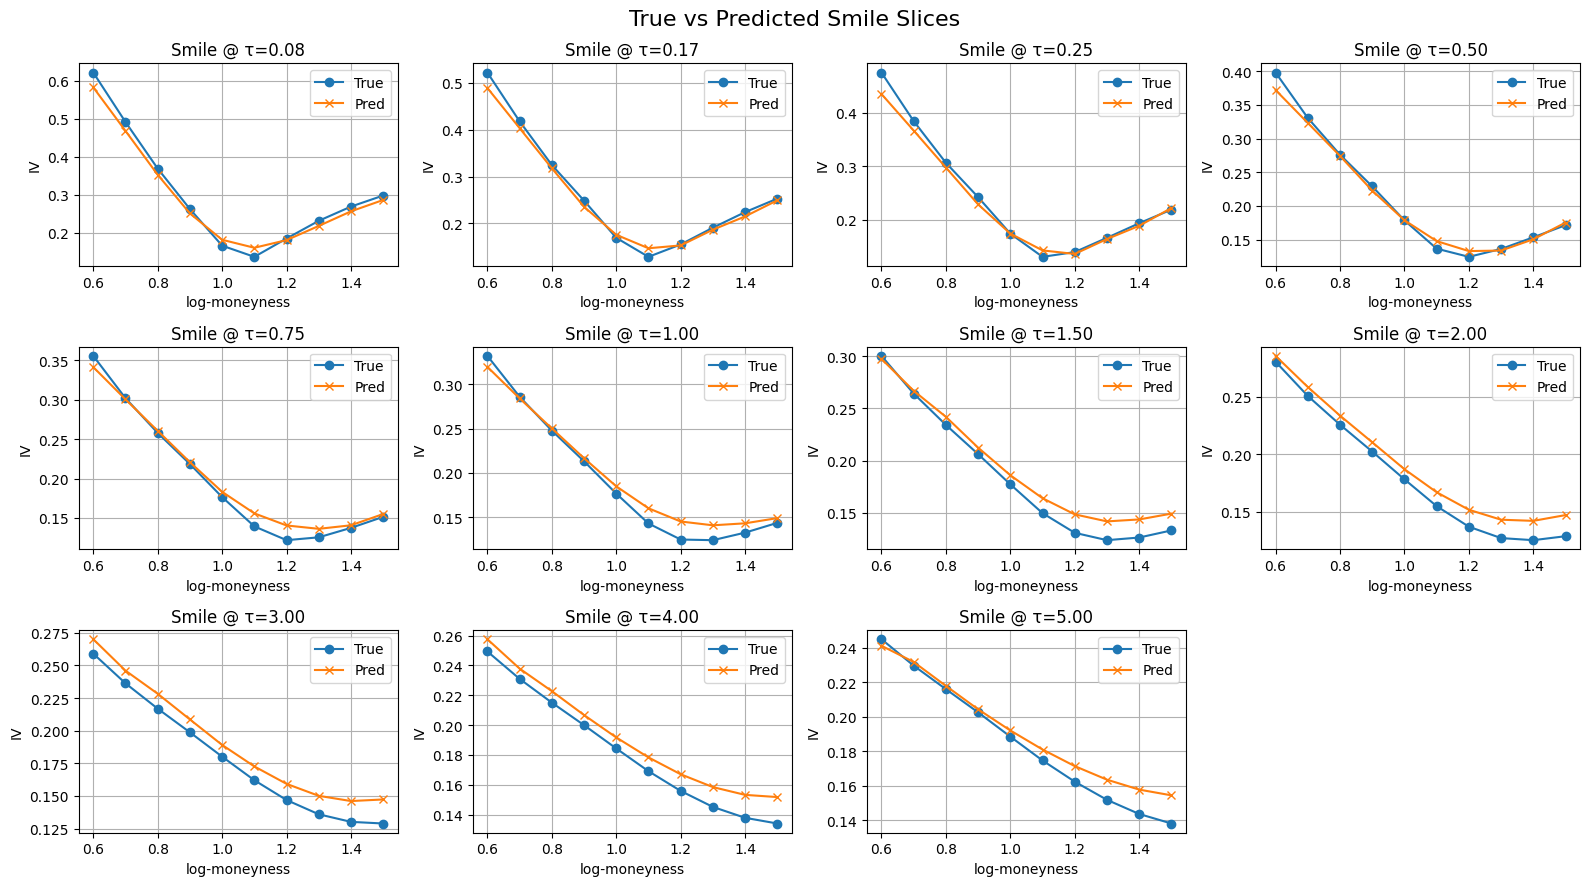

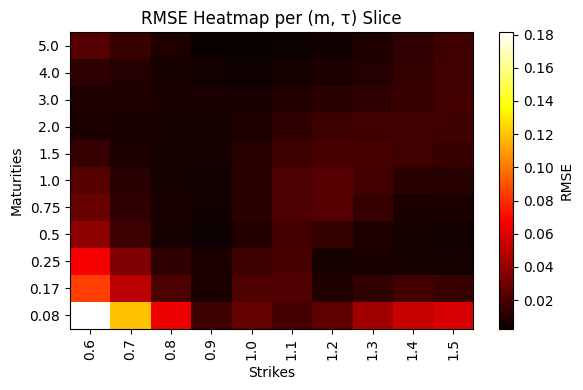

{'rmse_overall': 0.018503688926955576,
 'rmse_by_maturity': array([0.07835128, 0.03481726, 0.0260022 , 0.01600688, 0.0157891 ,
        0.01552121, 0.0145721 , 0.01297002, 0.01138284, 0.01055984,
        0.01197204]),
 'rmse_by_strike': array([0.06634885, 0.04174526, 0.02129028, 0.00794759, 0.01404589,
        0.01668594, 0.01632854, 0.01871891, 0.02089511, 0.02192984])}

In [21]:
import importlib
import utils.eval
importlib.reload(utils.eval)

from utils.eval import evaluate_decoder_output_v2

# config
SMOOTH_ALL = False
N_surfaces = 10

# select data subset
Z_eval = Z_decoder if SMOOTH_ALL else Z_decoder[-N_surfaces:]
F_eval = F_aligned if SMOOTH_ALL else F_aligned[-N_surfaces:]
Y_true = Y_decoder if SMOOTH_ALL else Y_decoder[-N_surfaces:]

# use raw predictions from Y_hat
Y_pred_raw = Y_hat if SMOOTH_ALL else Y_hat[-N_surfaces:]

# apply smoothing
Y_pred_smooth = np.stack([
   decoder_pw.refine_surface(surf, lambda_cal=0.2, lambda_smile=0.1)
   for surf in Y_pred_raw
])

# check smoothing impact
smoothing_impact = np.mean(np.abs(Y_pred_smooth - Y_pred_raw))
print(f"smoothing impact: {smoothing_impact:.6f}")

# evaluate smoothed predictions
evaluate_decoder_output_v2(
   Y_pred=Y_pred_smooth,                   # (N, M, K)
   Y_true=Y_true,                          # (N, M*K)
   tensors=tensors,
   rel_strikes=ops.convert_to_numpy(tensors["strike_tensor"]),
   taus=ops.convert_to_numpy(tensors["taus"]),
   target_date=TARGET_DATE,
   target_tau=TARGET_TAU,
   target_strike=TARGET_STRIKE,
   decoder=decoder_pw,                     
   title="Smoothed Piecewise Decoder (Feature-Aware)"
)

---
---

### FINAL POINTWISE DECDOER WITH MOE OPTION 

---
---

#### Experiment 1 

training moe modular decoder
Expert allocation: ATM=0, Maturity=4, Free=3, Total=7
Epoch 1/150
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 201s 69ms/step - loss: 3.1168 - val_loss: 0.5263 - learning_rate: 1.0000e-04
Epoch 2/150
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 193s 66ms/step - loss: 0.3405 - val_loss: 0.1669 - learning_rate: 1.0000e-04
Epoch 3/150
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 198s 68ms/step - loss: 0.1294 - val_loss: 0.0990 - learning_rate: 1.0000e-04
Epoch 4/150
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 197s 67ms/step - loss: 0.0799 - val_loss: 0.0697 - learning_rate: 1.0000e-04
Epoch 5/150
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 192s 66ms/step - loss: 0.0575 - val_loss: 0.0513 - learning_rate: 1.0000e-04
Epoch 6/150
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 197s 67ms/step - loss: 0.0455 - val_loss: 0.0426 - learning_rate: 1.0000e-04
Epoch 7/150
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 190s 65ms/step - loss: 0.0374 - val_loss: 0.0406 - learning_rate: 1.0000e-04
Epoch 8/150
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 197s 67ms/step - loss: 0.0317 - va

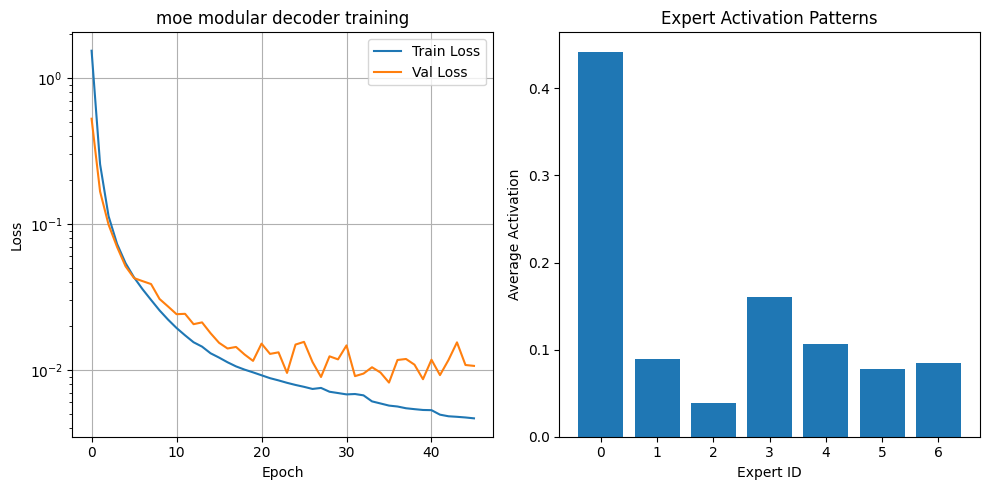

In [22]:
import models.pointwise_moe
import importlib
importlib.reload(models.pointwise_moe)

from models.pointwise_moe import PiecewiseSurfaceDecoderModular
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import os
import matplotlib.pyplot as plt
import torch

# moe vs standard mode
USE_MOE = True  

print(f"training {'moe' if USE_MOE else 'standard'} modular decoder")

# instantiate decoder
decoder_pw_mod = PiecewiseSurfaceDecoderModular(
   latent_dim=LATENT_DIM,
   M=M, K=K, taus=taus,
   feature_dim=F_aligned.shape[1],
   activation="gelu",
   use_moe=True,
   num_experts=7,                    
   
   # ultra short term focus
   maturity_experts=4,               
   free_experts=3,                   
   maturity_specialization=True,
   
   # disable atm bias - not the problem
   atm_specialization=False,         
   atm_loss_weight=1.0,
   
   # force expert diversity
   lambda_diversity=0.25, # baseline 
)

decoder_pw_mod.compile(optimizer=Adam(learning_rate=1e-4, clipnorm=1.0), loss=hybrid_loss_fn)

# training callbacks
model_suffix = "moe" if USE_MOE else "standard"
os.makedirs(f"saved_models/ae/piecewise_surface_mod_{model_suffix}", exist_ok=True)
callbacks = [
   EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True, min_delta=1e-5),
   ReduceLROnPlateau(monitor="val_loss", factor=0.7, patience=5, min_lr=1e-7),
   ModelCheckpoint(f"saved_models/ae/piecewise_surface_mod_{model_suffix}/decoder.keras", save_best_only=True, verbose=0)
]

# fit model
history = decoder_pw_mod.fit(
   X_train, y_train,
   validation_data=(X_val, y_val),
   batch_size=BATCH_SIZE,
   epochs=150,
   callbacks=callbacks,
   verbose=1
)

print(f"final train loss: {history.history['loss'][-1]:.6f}")
print(f"final val loss: {history.history['val_loss'][-1]:.6f}")

# plot training history
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title(f"{'moe' if USE_MOE else 'standard'} modular decoder training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.yscale('log')

if USE_MOE:
   plt.subplot(1, 2, 2)
   # check expert patterns
   analysis = decoder_pw_mod.analyze_gating(X_val)
   if analysis is not None:
       plt.bar(range(decoder_pw_mod.num_experts), analysis['expert_activations'])
       plt.title("Expert Activation Patterns")
       plt.xlabel("Expert ID")
       plt.ylabel("Average Activation")
       plt.xticks(range(decoder_pw_mod.num_experts))
       
       print(f"\nexpert analysis:")
       print(f"  expert activations: {analysis['expert_activations']}")
       print(f"  average entropy: {analysis['gate_entropy'].mean():.3f}")

plt.tight_layout()
plt.show()

y_hat shape: (1216, 11, 10)
y_full shape: (1216, 110)
Evaluation dimensions: N=1216, M=11, K=10
Piecewise Decoder with BS Loss (MoE) AE RMSE_σ: 0.0066
RMSE by maturity (mean ± std): 0.0068 ± 0.0034
RMSE by strike    (mean ± std): 0.0074 ± 0.0020
Plotting last surface shapes: true=(11, 10), pred=(11, 10)


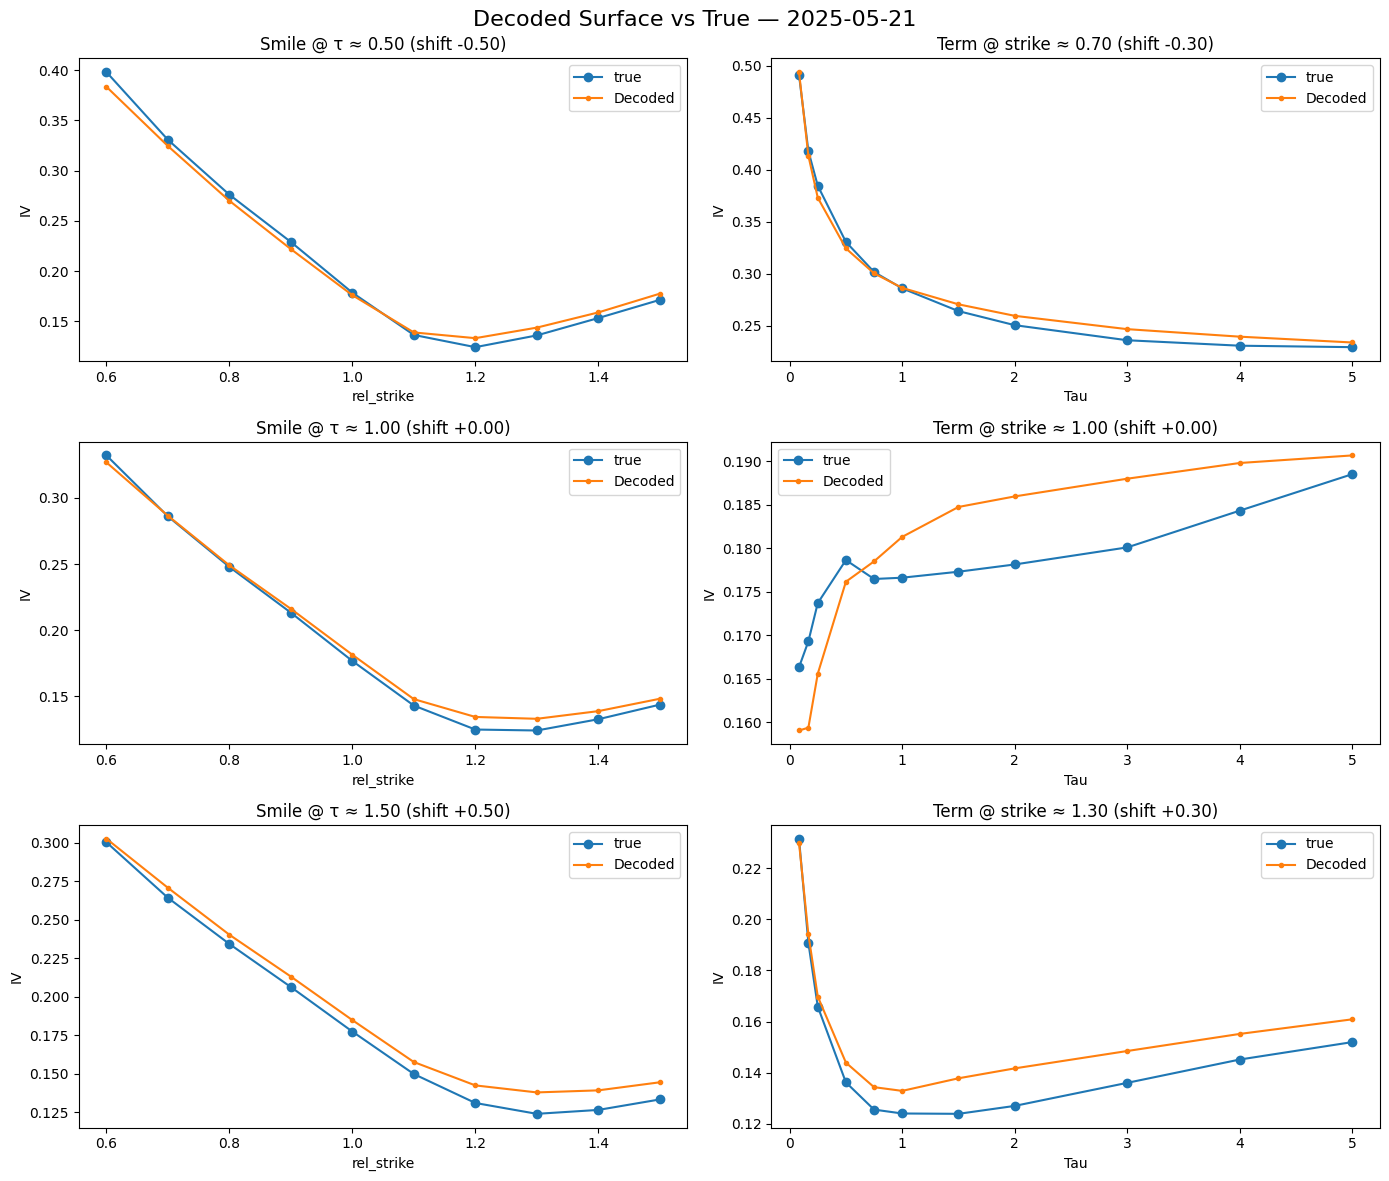

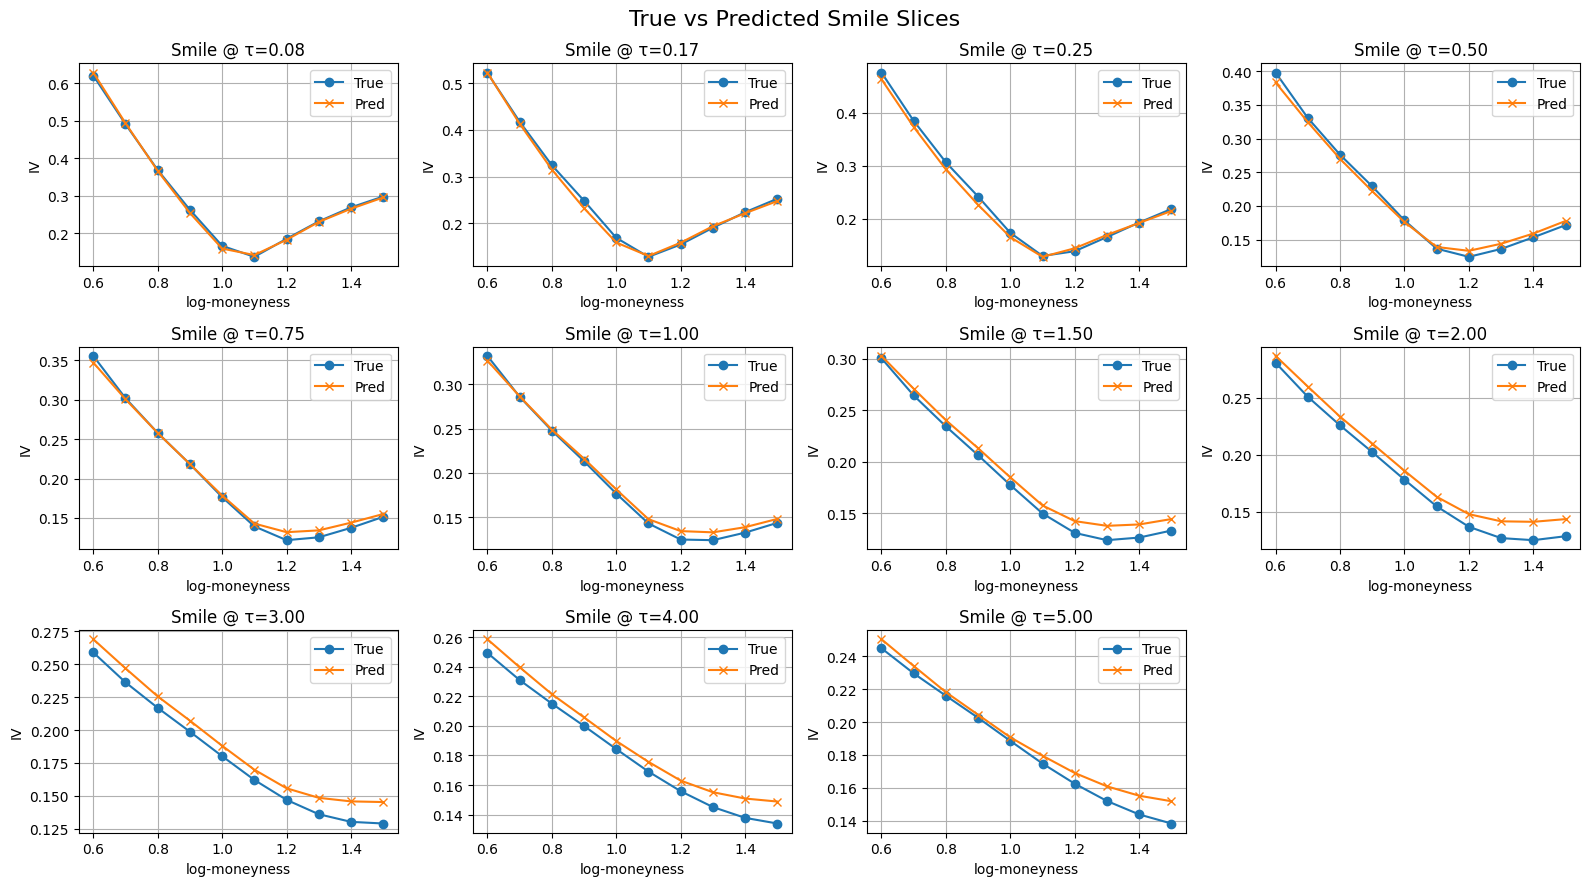

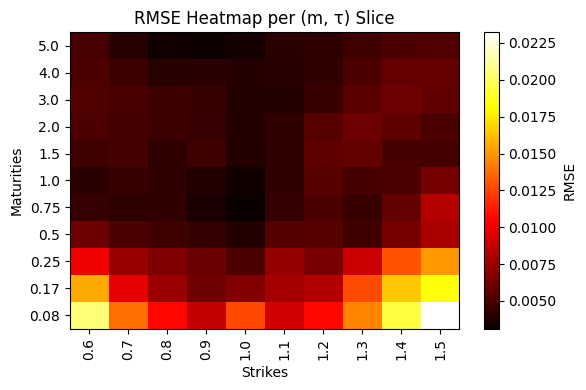

{'rmse_overall': 0.006593581,
 'rmse_by_maturity': array([0.01511754, 0.0117232 , 0.00912155, 0.00552966, 0.00500693,
        0.0047452 , 0.00486313, 0.00502669, 0.00499877, 0.00477679,
        0.00432879], dtype=float32),
 'rmse_by_strike': array([0.0093926 , 0.00685788, 0.00575655, 0.00513414, 0.00558817,
        0.00564044, 0.00624203, 0.00782634, 0.00986458, 0.01135998],
       dtype=float32)}

In [23]:
import models.decoder
import utils.plotting
import utils.eval
import importlib
importlib.reload(models.decoder)
importlib.reload(utils.plotting)
importlib.reload(utils.eval)

from utils.eval import evaluate_decoder_output_v2

# eval config
Z_eval = Z_decoder            # (N, latent_dim)
F_eval = F_aligned            # (N, feature_dim)
Y_full = Y_decoder            # (N, M*K) flattened

# setup grid
m_grid, tau_grid = np.meshgrid(
  ops.convert_to_numpy(tensors["strike_tensor"]),
  ops.convert_to_numpy(tensors["taus"])
)
m_flat = m_grid.reshape(-1, 1).astype(np.float32)
tau_flat = tau_grid.reshape(-1, 1).astype(np.float32)

# generate predictions
Y_hat = np.stack([
  decoder_pw_mod.predict_surface(z, f, m_flat, tau_flat)
  for z, f in zip(Z_eval, F_eval)
])

print(f"y_hat shape: {Y_hat.shape}")
print(f"y_full shape: {Y_full.shape}")

# evaluate using new function
evaluate_decoder_output_v2(
   Y_pred=Y_hat,                          # (N, M, K)
   Y_true=Y_full,                         # (N, M*K) auto-reshaped
   tensors=tensors,
   rel_strikes=ops.convert_to_numpy(tensors["strike_tensor"]),
   taus=ops.convert_to_numpy(tensors["taus"]),
   target_date=TARGET_DATE,
   target_tau=TARGET_TAU,
   target_strike=TARGET_STRIKE,
   decoder=decoder_pw_mod,                    
   title="Piecewise Decoder with BS Loss (MoE) AE"
)

MoE Analysis
Experts: 7
Diversity: 0.25


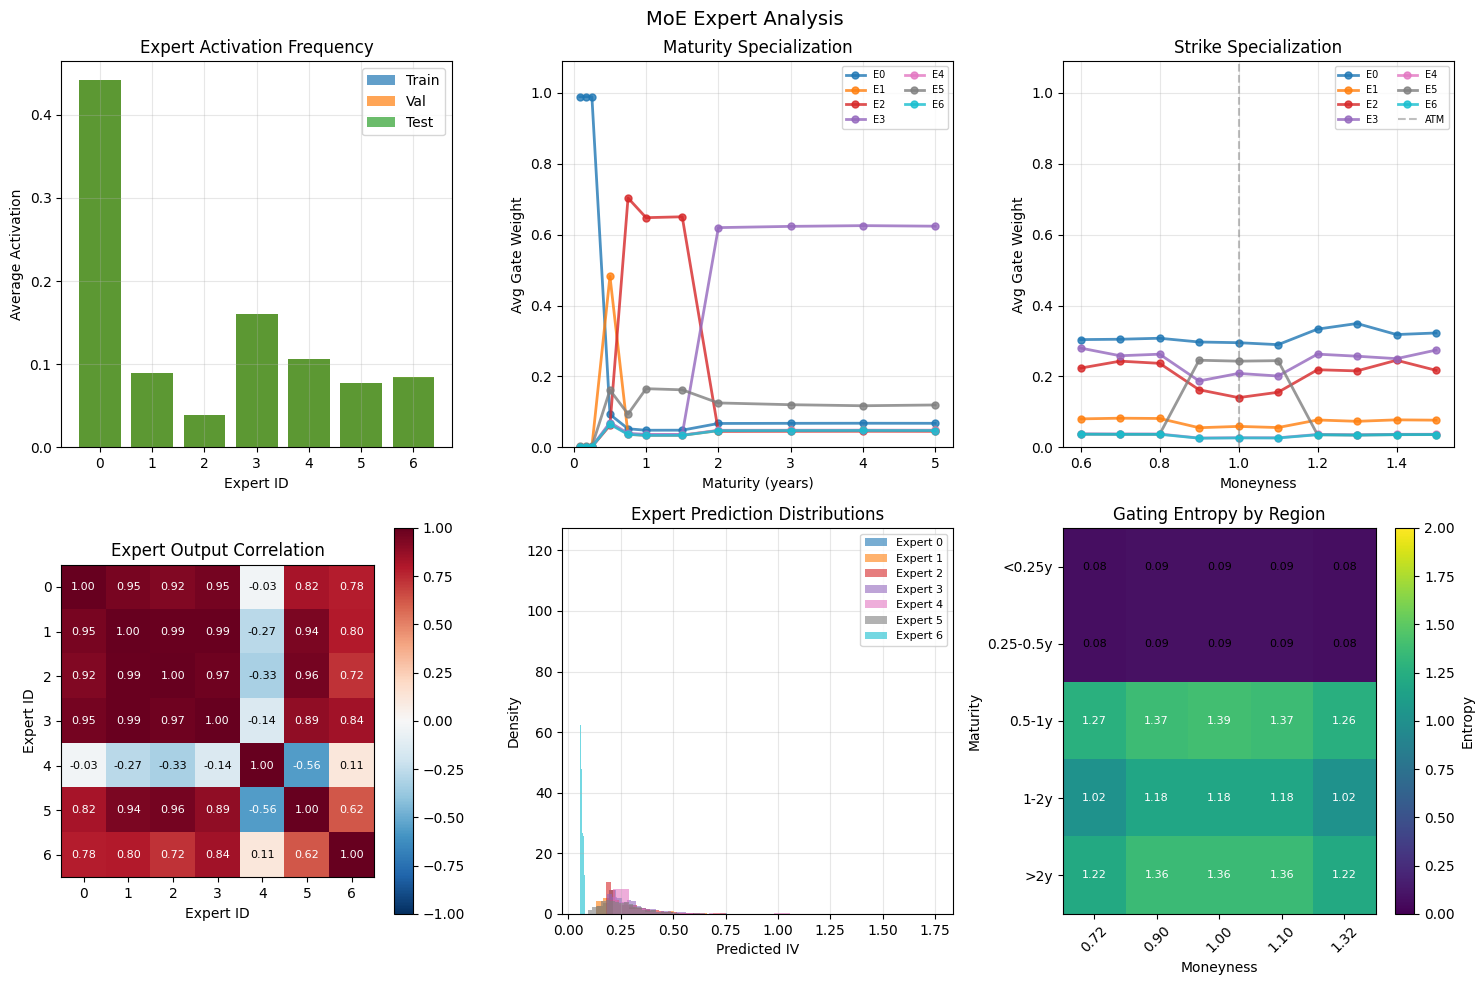


Summary:
Most active expert: 0
Least active expert: 2
Balance score: 0.873
Avg entropy: 1.643
Min correlation: -0.561
Max correlation: 1.000


In [24]:
import importlib
import utils.eval
importlib.reload(utils.eval)

from utils.eval import analyze_moe_training_performance

# analyze moe performance
results = analyze_moe_training_performance(
   decoder_pw_mod,    # moe decoder
   X_train,           # training inputs [z+f, strikes, taus]
   X_val,             # validation inputs
   X_test,            # test inputs  
   y_train,           # training targets
   y_val,             # validation targets
   y_test             # test targets
)

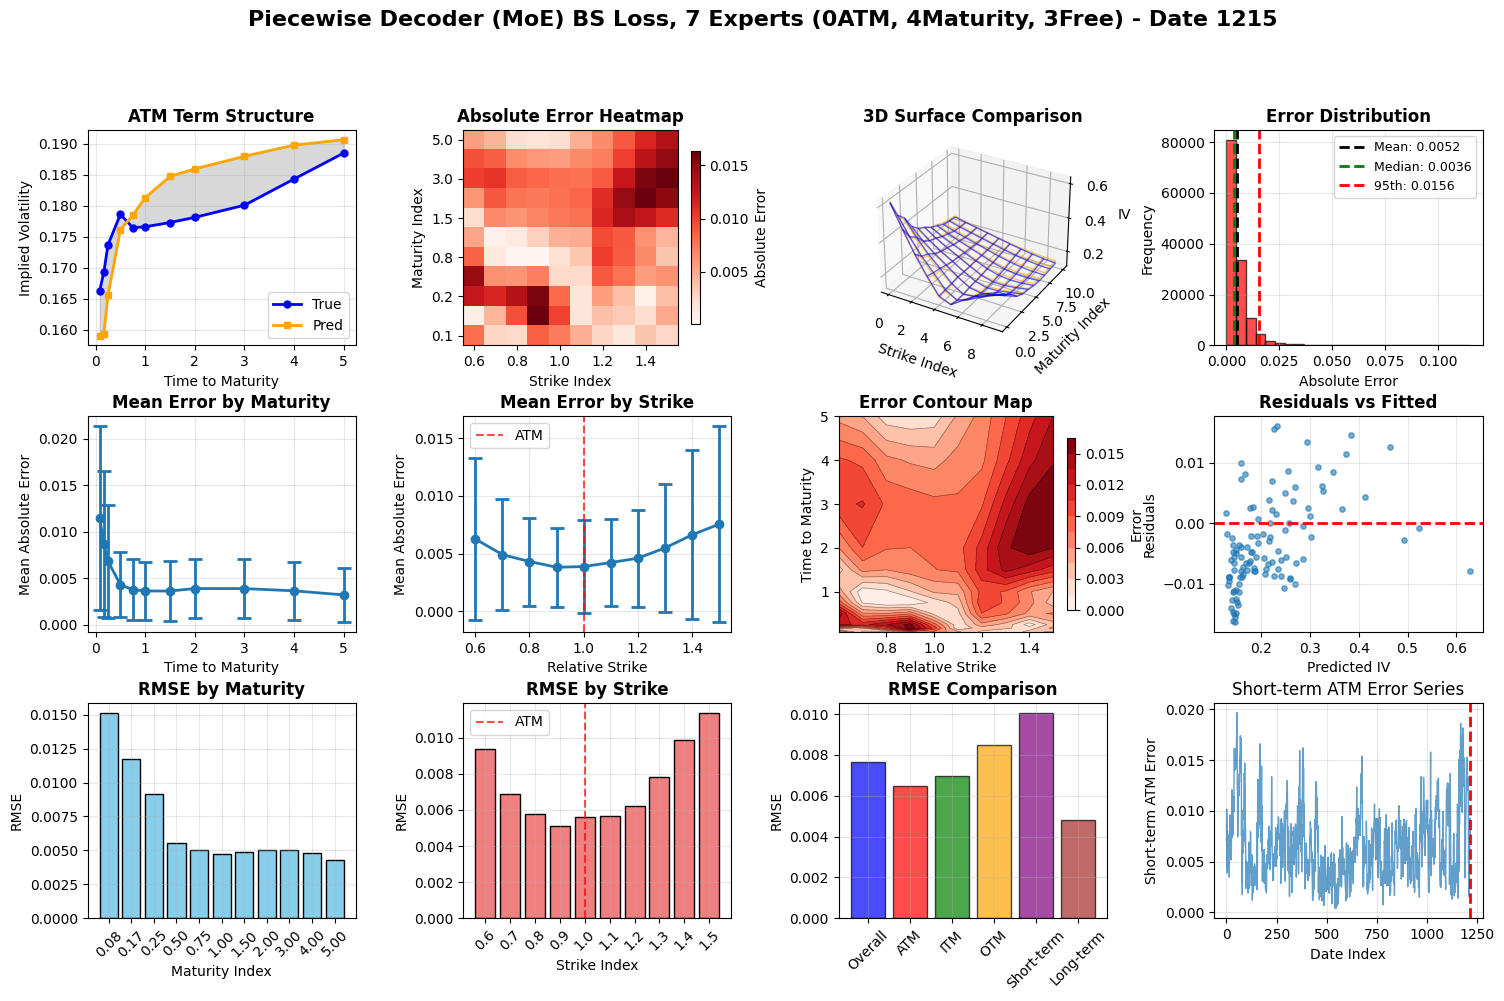

Overall Performance Category Performance  \
RMSE                           0.007644                  NaN   
MAE                            0.005167                  NaN   
Max Error                      0.115388                  NaN   
Mean Error                     0.005167                  NaN   
Median Error                   0.003573                  NaN   
95th Percentile                0.015554                  NaN   
ATM RMSE                            NaN             0.006495   
ITM RMSE                            NaN             0.006978   
OTM RMSE                            NaN             0.008466   
Short-term RMSE                     NaN             0.010048   
Long-term RMSE                      NaN             0.004795   
Short/Long Ratio                    NaN                2.095   
Best Maturity                       NaN                  NaN   
Worst Maturity                      NaN                  NaN   
Best Strike                         NaN                  NaN   
Worst Strike                        NaN                  NaN   
ATM Performance                     NaN                  NaN   
Overall Rank                        NaN                  NaN   
Short-term Bias                     NaN                  NaN   
ATM Issues                          NaN                  NaN   
Smile Asymmetry                     NaN                  NaN   
High Error Variance                 NaN                  NaN   
Model Quality                       NaN                  NaN   
Recommendation                      NaN                  NaN   

                      Best/Worst Performance          Diagnostic Flags  
RMSE                                     NaN                       NaN  
MAE                                      NaN                       NaN  
Max Error                                NaN                       NaN  
Mean Error                               NaN                       NaN  
Median Error                             NaN                       NaN  
95th Percentile                          NaN                       NaN  
ATM RMSE                                 NaN                       NaN  
ITM RMSE                                 NaN                       NaN  
OTM RMSE                                 NaN                       NaN  
Short-term RMSE                          NaN                       NaN  
Long-term RMSE                           NaN                       NaN  
Short/Long Ratio                         NaN                       NaN  
Best Maturity        τ=5.00 (RMSE: 0.004329)                       NaN  
Worst Maturity       τ=0.08 (RMSE: 0.015118)                       NaN  
Best Strike           K=0.9 (RMSE: 0.005134)                       NaN  
Worst Strike          K=1.5 (RMSE: 0.011360)                       NaN  
ATM Performance       K=1.0 (RMSE: 0.005588)                       NaN  
Overall Rank              ATM ranks #7 of 10                       NaN  
Short-term Bias                          NaN        YES (ratio: 2.095)  
ATM Issues                               NaN   NO (ATM/Overall: 0.85x)  
Smile Asymmetry                          NaN  NO (|ITM-OTM|: 0.001489)  
High Error Variance                      NaN       YES (std: 0.005634)  
Model Quality                            NaN                 EXCELLENT  
Recommendation                           NaN         Needs Improvement

In [25]:
import models.decoder
import importlib
importlib.reload(models.decoder)

import utils.plot_error
importlib.reload(utils.plot_error)
from utils.plot_error import analyze_decoder_comprehensive

# eval config
Z_eval = Z_decoder            # (N, latent_dim)
F_eval = F_aligned            # (N, feature_dim)
Y_full = Y_decoder            # (N, M*K) flattened

# setup grid
m_grid, tau_grid = np.meshgrid(
  ops.convert_to_numpy(tensors["strike_tensor"]),
  ops.convert_to_numpy(tensors["taus"])
)
m_flat = m_grid.reshape(-1, 1).astype(np.float32)
tau_flat = tau_grid.reshape(-1, 1).astype(np.float32)

# generate predictions
Y_hat = np.stack([
  decoder_pw_mod.predict_surface(z, f, m_flat, tau_flat)
  for z, f in zip(Z_eval, F_eval)
])

# reshape ground truth to match
Y_full = Y_decoder.reshape(-1, decoder_pw.M, decoder_pw.K)

# run comprehensive analysis
metrics = analyze_decoder_comprehensive(
  Y_true=Y_full,              
  Y_pred=Y_hat,               
  taus=ops.convert_to_numpy(tensors["taus"]),
  rel_strikes=ops.convert_to_numpy(tensors["strike_tensor"]),
  date_idx=-1,                # last date
  dates=None,                 
  title="Piecewise Decoder (MoE) BS Loss, 7 Experts (0ATM, 4Maturity, 3Free)"
)

In [26]:
from utils.plot_error import summarize_decoder_errors, collect_decoder_summaries

# extract insights for tracking
summary_pw_moe = summarize_decoder_errors(
   Y_true=Y_full, 
   Y_pred=Y_hat,
   taus=taus, 
   rel_strikes=rel_strikes,
   name="Piecewise Decoder with BS Loss (MoE) 7 Experts, atm 0, 3 Free, 4 Maturity",
   model=decoder_pw_mod
)

# collect and compare experiments  
summary_all_decoders = collect_decoder_summaries(
   summary_pw_decoder,
   summary_pw_moe,
   # add more experiments here
)

display(summary_all_decoders)

Name  Rank Overall_RMSE  \
0  Piecewise Decoder with BS Loss (MoE) 7 Experts...     1     0.007644   
1                   Piecewise Decoder with BS LossAE     2     0.010897   

  Overall_MAE  ATM_RMSE   ATM_MAE  ITM_RMSE  OTM_RMSE Short_Long_Ratio  \
0    0.005167  0.005588  0.003875  0.006978  0.008466         2.095340   
1    0.007785  0.011576  0.007950  0.010046  0.011400         2.270829   

  Max_Error  Short_Term_Bias  ATM_Issues Model_Quality  Production_Ready  
0  0.115388             True       False     EXCELLENT             False  
1  0.078387             True       False          GOOD             False

raw predictions shape: (20, 11, 10)
using sliding window size: 5
Evaluation dimensions: N=20, M=11, K=10
Adaptive Refined MoE Decoder RMSE_σ: 0.0075
RMSE by maturity (mean ± std): 0.0081 ± 0.0040
RMSE by strike    (mean ± std): 0.0085 ± 0.0028
Plotting last surface shapes: true=(11, 10), pred=(11, 10)


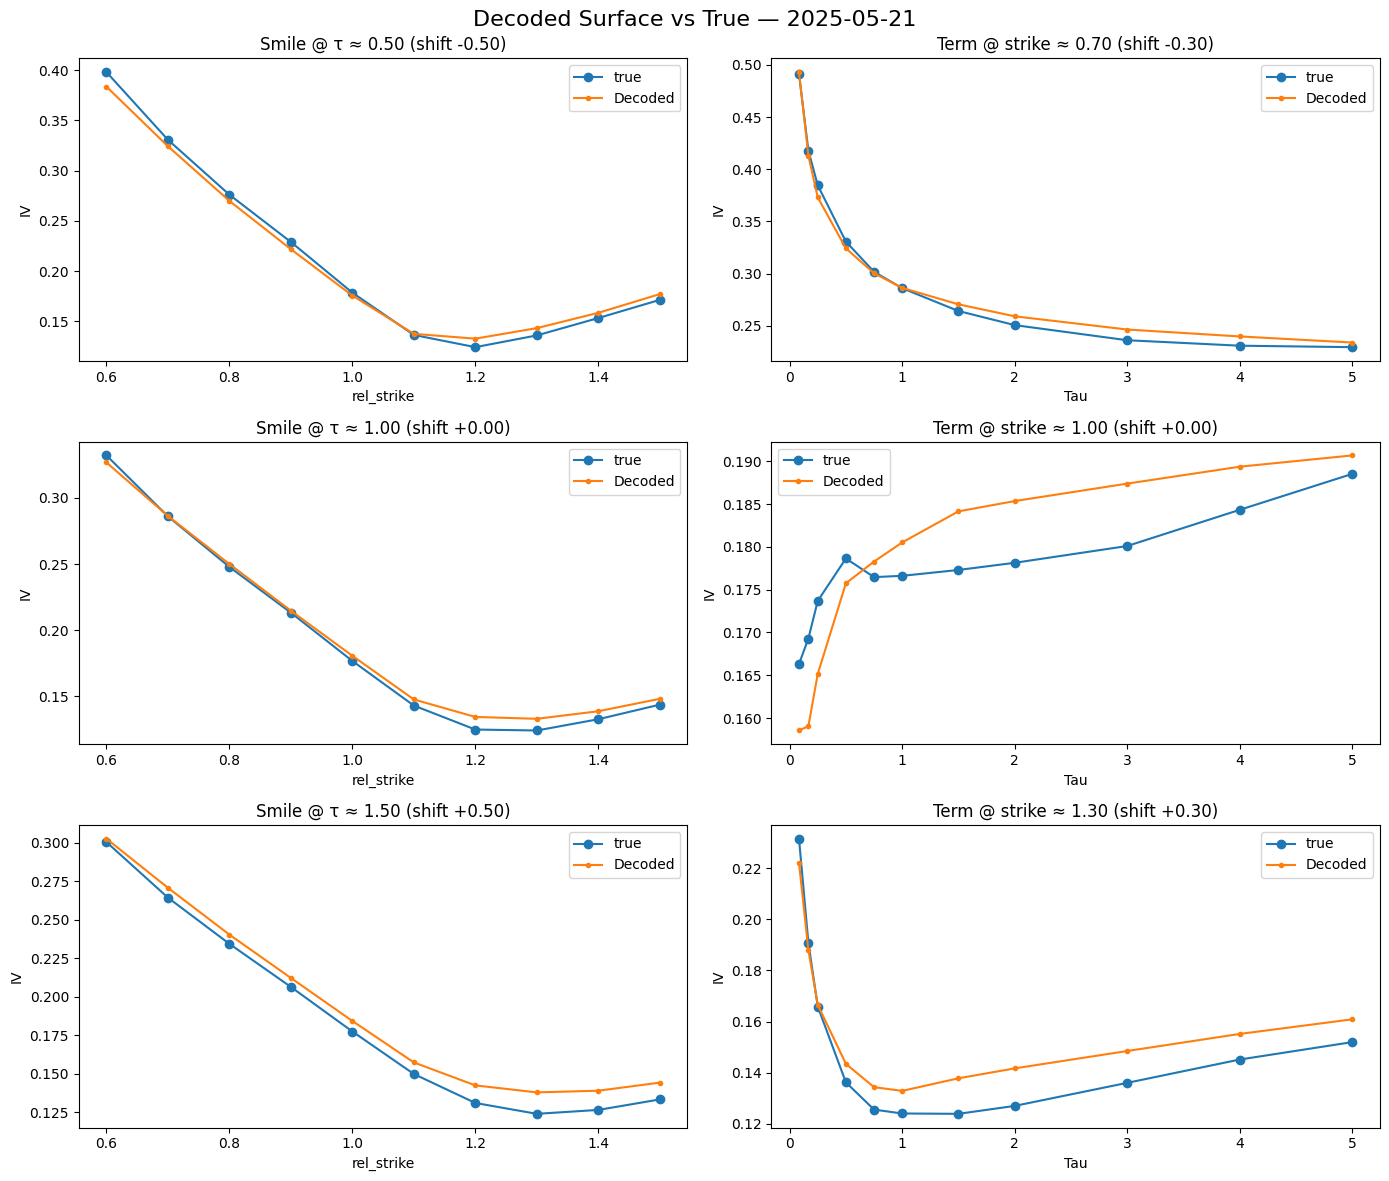

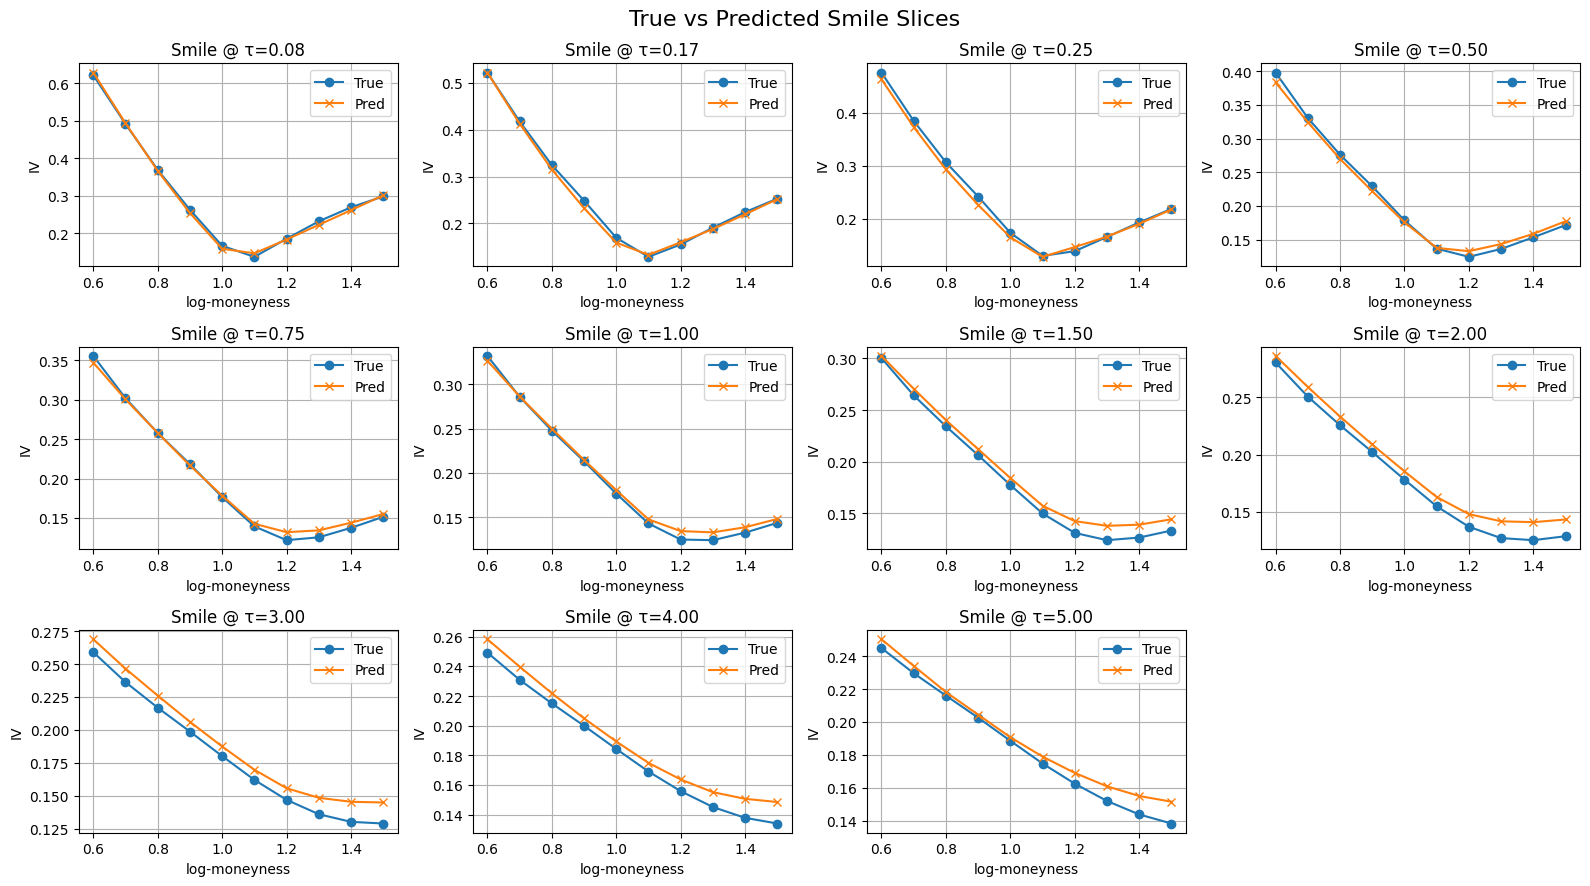

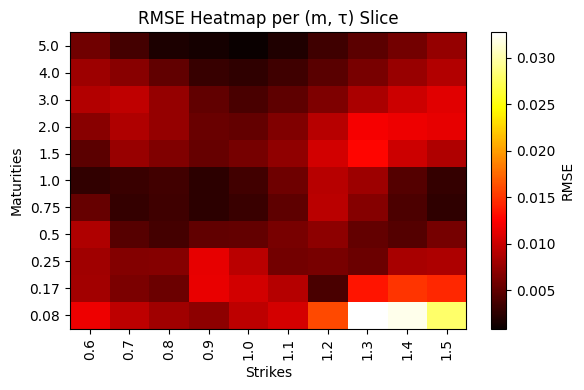

{'rmse_overall': 0.007452705554967383,
 'rmse_by_maturity': array([0.01915736, 0.01042885, 0.00786981, 0.00577988, 0.00494911,
        0.00505195, 0.00833104, 0.00882944, 0.00796877, 0.00597872,
        0.00426122]),
 'rmse_by_strike': array([0.00755002, 0.00673293, 0.00573802, 0.00635913, 0.00615984,
        0.00643014, 0.00850955, 0.01301486, 0.01284955, 0.01197735])}

In [ ]:
import importlib
import utils.eval
importlib.reload(utils.eval)

import models.pointwise_moe
importlib.reload(models.pointwise_moe)

from utils.eval import evaluate_decoder_output_v2

# config
SMOOTH_ALL = False
N_surfaces = 20

# select data subset
Z_eval = Z_decoder if SMOOTH_ALL else Z_decoder[-N_surfaces:]
F_eval = F_aligned if SMOOTH_ALL else F_aligned[-N_surfaces:]
Y_true = Y_decoder if SMOOTH_ALL else Y_decoder[-N_surfaces:]

# generate raw predictions from moe
Y_pred_raw = np.stack([
   decoder_pw_mod.predict_surface(z, f, m_flat, tau_flat)
   for z, f in zip(Z_eval, F_eval)
])

print(f"raw predictions shape: {Y_pred_raw.shape}")

# prepare ground truth for sliding window
Y_true_3d = Y_true.reshape(-1, M, K)

# apply adaptive refinement with sliding window
window_size = max(1, int(N_surfaces // 4))  # ensure at least 1
print(f"using sliding window size: {window_size}")

Y_pred_smooth = []
for i, surf in enumerate(Y_pred_raw):
   # sliding window of recent surfaces
   window_start = max(0, i - window_size)
   window_end = i + 1
   recent_surfaces = Y_true_3d[window_start:window_end]
   
   refined_surf = decoder_pw_mod.refine_surface(
       surf, 
       recent_surfaces=recent_surfaces,
       lambda_cal=0.1,        # calendar penalty
       lambda_smile=0.1,      # smile penalty  
       lambda_history=0.05    # history matching
   )
   Y_pred_smooth.append(refined_surf)

Y_pred_smooth = np.stack(Y_pred_smooth)

# evaluate refined surfaces
evaluate_decoder_output_v2(
   Y_pred=Y_pred_smooth,                   # (N, M, K)
   Y_true=Y_true,                          # (N, M*K)
   tensors=tensors,
   rel_strikes=ops.convert_to_numpy(tensors["strike_tensor"]),
   taus=ops.convert_to_numpy(tensors["taus"]),
   target_date=TARGET_DATE,
   target_tau=TARGET_TAU,
   target_strike=TARGET_STRIKE,
   decoder=decoder_pw_mod,                 
   title=" Refined MoE Decoder"
)

### Experiment 2

training moe modular decoder
Expert allocation: ATM=0, Maturity=4, Free=3, Total=7
Epoch 1/150
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 165s 56ms/step - loss: 2.7891 - val_loss: 0.4455 - learning_rate: 1.0000e-04
Epoch 2/150
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 172s 59ms/step - loss: 0.3003 - val_loss: 0.1665 - learning_rate: 1.0000e-04
Epoch 3/150
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 168s 58ms/step - loss: 0.1260 - val_loss: 0.0981 - learning_rate: 1.0000e-04
Epoch 4/150
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 153s 52ms/step - loss: 0.0762 - val_loss: 0.0690 - learning_rate: 1.0000e-04
Epoch 5/150
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 147s 50ms/step - loss: 0.0510 - val_loss: 0.0417 - learning_rate: 1.0000e-04
Epoch 6/150
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 163s 56ms/step - loss: 0.0366 - val_loss: 0.0330 - learning_rate: 1.0000e-04
Epoch 7/150
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 177s 60ms/step - loss: 0.0277 - val_loss: 0.0352 - learning_rate: 1.0000e-04
Epoch 8/150
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 161s 55ms/step - loss: 0.0222 - va

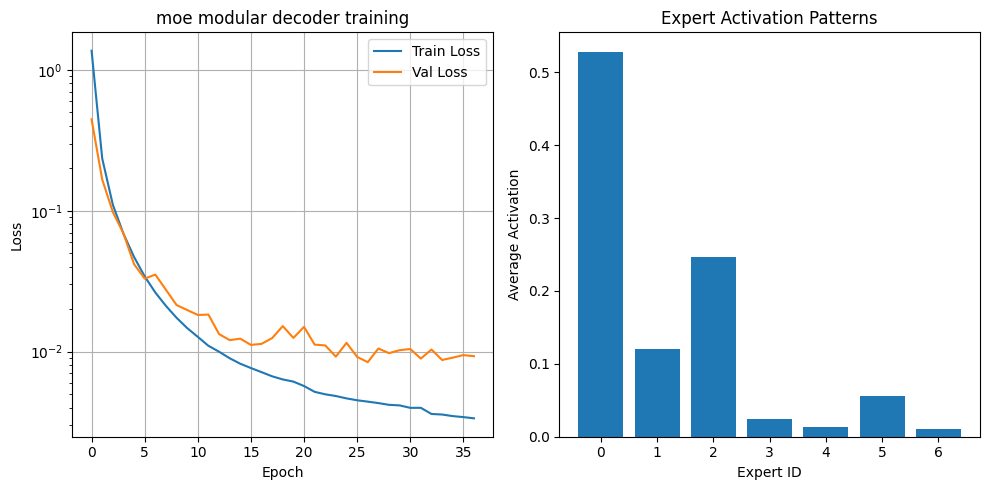

In [28]:
import models.pointwise_moe
import importlib
importlib.reload(models.pointwise_moe)

from models.pointwise_moe import PiecewiseSurfaceDecoderModular
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import os
import matplotlib.pyplot as plt
import torch

# moe vs standard mode
USE_MOE = True  

print(f"training {'moe' if USE_MOE else 'standard'} modular decoder")

# experiment 2: relu activation, 2 free experts, higher diversity
decoder_pw_mod_2 = PiecewiseSurfaceDecoderModular(
   latent_dim=LATENT_DIM,
   M=M, K=K, taus=taus,
   feature_dim=F_aligned.shape[1],
   activation="relu",                # changed from gelu
   use_moe=True,
   num_experts=7,                    
   
   # ultra short term focus
   maturity_experts=4,               
   free_experts=2,                   # reduced from 3
   maturity_specialization=True,
   
   # disable atm bias
   atm_specialization=False,         
   atm_loss_weight=1.0,
   
   # increased diversity penalty
   lambda_diversity=0.3,              # up from 0.25
)

decoder_pw_mod_2.compile(optimizer=Adam(learning_rate=1e-4, clipnorm=1.0), loss=hybrid_loss_fn)

# training callbacks
model_suffix = "moe" if USE_MOE else "standard"
os.makedirs(f"saved_models/piecewise_surface_mod_{model_suffix}", exist_ok=True)
callbacks = [
   EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True, min_delta=1e-5),
   ReduceLROnPlateau(monitor="val_loss", factor=0.7, patience=5, min_lr=1e-7),
   ModelCheckpoint(f"saved_models/piecewise_surface_mod_{model_suffix}_2/decoder.keras", save_best_only=True, verbose=0)
]

# fit model
history = decoder_pw_mod_2.fit(
   X_train, y_train,
   validation_data=(X_val, y_val),
   batch_size=BATCH_SIZE,
   epochs=150,
   callbacks=callbacks,
   verbose=1
)

print(f"final train loss: {history.history['loss'][-1]:.6f}")
print(f"final val loss: {history.history['val_loss'][-1]:.6f}")

# plot training history
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title(f"{'moe' if USE_MOE else 'standard'} modular decoder training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.yscale('log')

if USE_MOE:
   plt.subplot(1, 2, 2)
   # check expert patterns
   analysis = decoder_pw_mod_2.analyze_gating(X_val)
   if analysis is not None:
       plt.bar(range(decoder_pw_mod.num_experts), analysis['expert_activations'])
       plt.title("Expert Activation Patterns")
       plt.xlabel("Expert ID")
       plt.ylabel("Average Activation")
       plt.xticks(range(decoder_pw_mod.num_experts))
       
       print(f"\nexpert analysis:")
       print(f"  expert activations: {analysis['expert_activations']}")
       print(f"  average entropy: {analysis['gate_entropy'].mean():.3f}")

plt.tight_layout()
plt.show()

Y_hat shape: (1216, 11, 10)
Y_full shape: (1216, 110)
Evaluation dimensions: N=1216, M=11, K=10
piecewise moe v2 - 7exp (4mat/2free) relu div0.3 RMSE_σ: 0.0069
RMSE by maturity (mean ± std): 0.0071 ± 0.0033
RMSE by strike    (mean ± std): 0.0076 ± 0.0020
Plotting last surface shapes: true=(11, 10), pred=(11, 10)


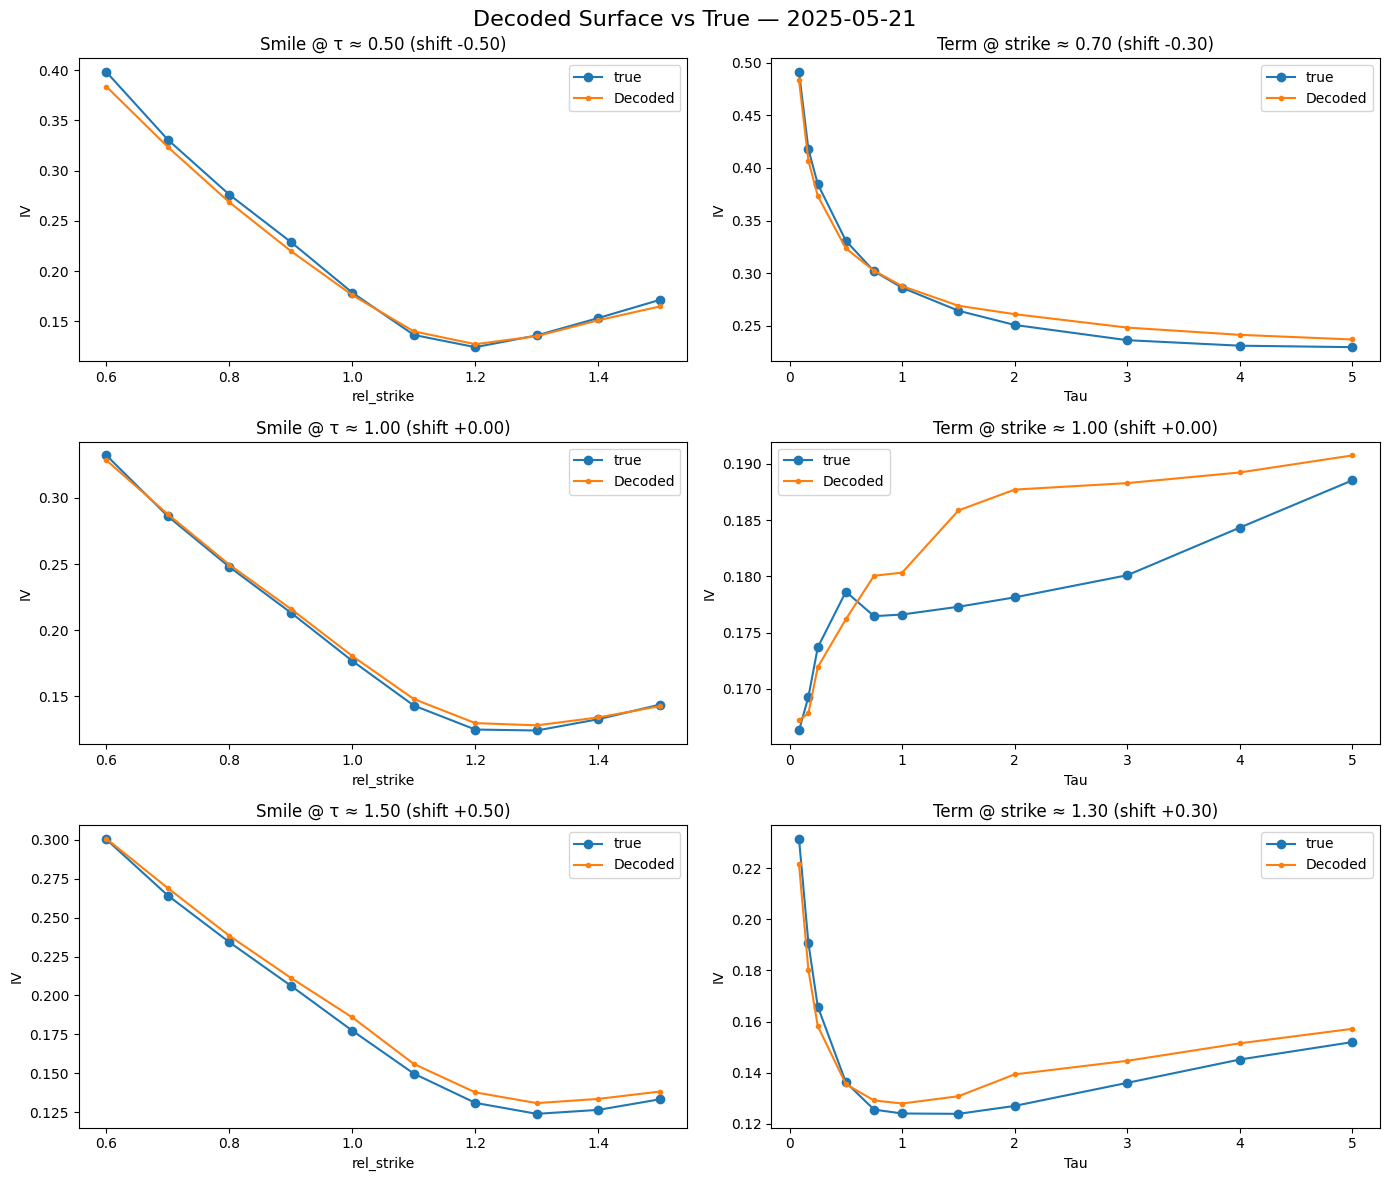

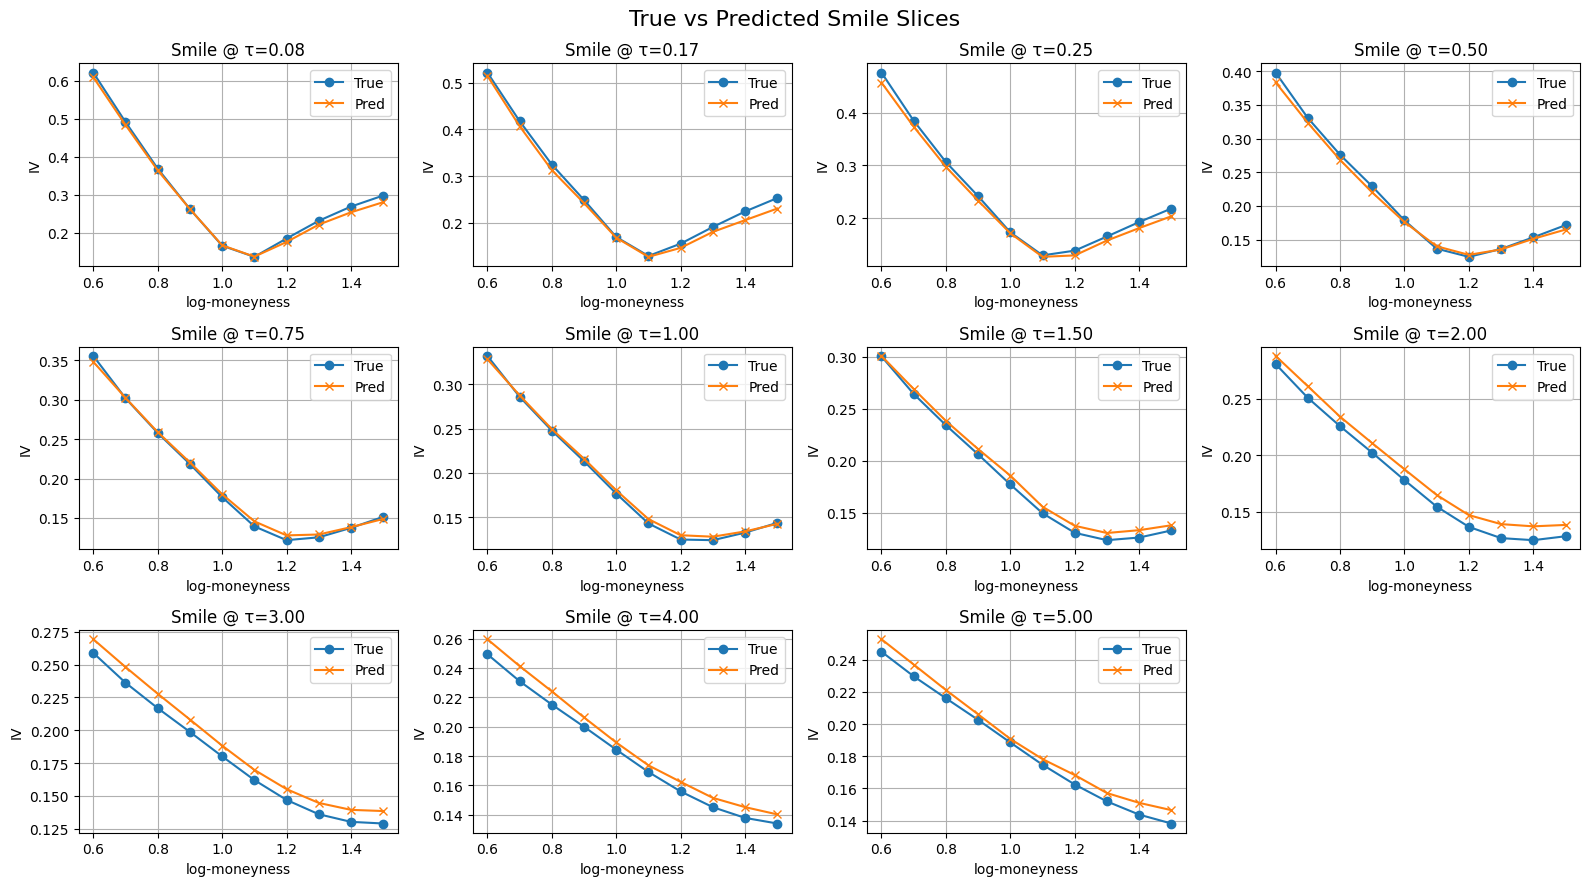

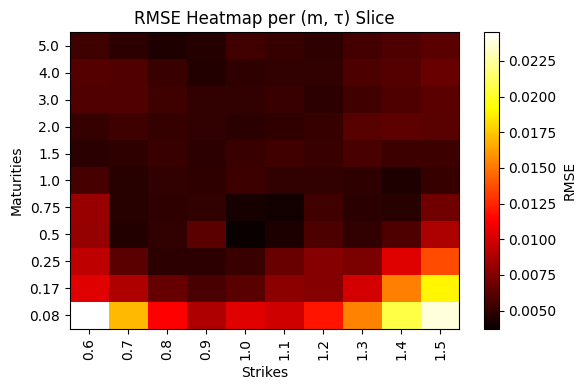

{'rmse_overall': 0.006887223,
 'rmse_by_maturity': array([0.01636127, 0.01056219, 0.0080709 , 0.00595367, 0.00543751,
        0.00502295, 0.0052072 , 0.00543633, 0.00552901, 0.00557282,
        0.00530155], dtype=float32),
 'rmse_by_strike': array([0.01005736, 0.00752299, 0.00603046, 0.00555442, 0.00575604,
        0.00602691, 0.0065699 , 0.00754011, 0.00962569, 0.01149051],
       dtype=float32)}

In [ ]:
import models.decoder
import utils.plotting
import utils.eval
import importlib
importlib.reload(models.decoder)
importlib.reload(utils.plotting)
importlib.reload(utils.eval)

from utils.eval import evaluate_decoder_output_v2

name = "piecewise moe v2 - 7exp (4mat/2free) relu div0.3"

# eval config
Z_eval = Z_decoder            # (N, latent_dim)
F_eval = F_aligned            # (N, feature_dim)
Y_full = Y_decoder            # (N, M*K) - flattened ground truth


m_grid, tau_grid = np.meshgrid(
   ops.convert_to_numpy(tensors["strike_tensor"]),
   ops.convert_to_numpy(tensors["taus"])
)
m_flat = m_grid.reshape(-1, 1).astype(np.float32)
tau_flat = tau_grid.reshape(-1, 1).astype(np.float32)

# preds
Y_hat = np.stack([
   decoder_pw_mod_2.predict_surface(z, f, m_flat, tau_flat)
   for z, f in zip(Z_eval, F_eval)
])

print(f"Y_hat shape: {Y_hat.shape}")
print(f"Y_full shape: {Y_full.shape}")


evaluate_decoder_output_v2(
    Y_pred=Y_hat,                          # Pre-computed predictions (N, M, K)
    Y_true=Y_full,                         # Ground truth (N, M*K) 
    tensors=tensors,
    rel_strikes=ops.convert_to_numpy(tensors["strike_tensor"]),
    taus=ops.convert_to_numpy(tensors["taus"]),
    target_date=TARGET_DATE,
    target_tau=TARGET_TAU,
    target_strike=TARGET_STRIKE,
    decoder=decoder_pw_mod_2,                    # For penalty calculation
    title=name
)



MoE Analysis
Experts: 7
Diversity: 0.3


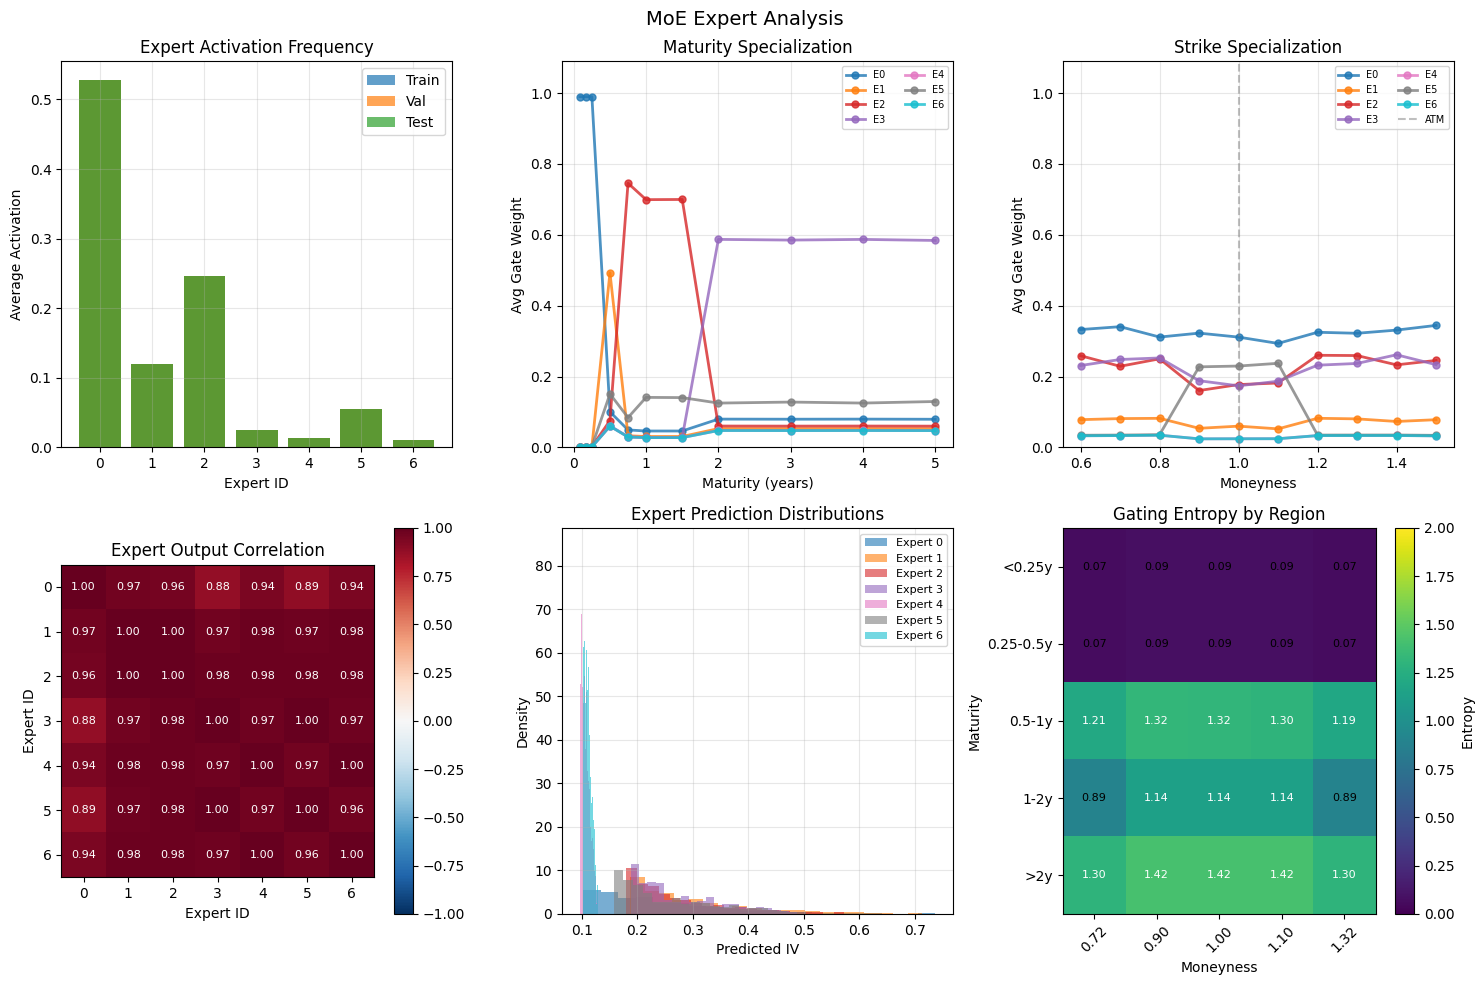


Summary:
Most active expert: 0
Least active expert: 6
Balance score: 0.825
Avg entropy: 1.297
Min correlation: 0.879
Max correlation: 1.000


In [30]:
import importlib
import utils.eval
importlib.reload(utils.eval)

from utils.eval import analyze_moe_training_performance

# analyze moe performance
results = analyze_moe_training_performance(
   decoder_pw_mod_2,    # moe decoder
   X_train,           # training inputs [z+f, strikes, taus]
   X_val,             # validation inputs
   X_test,            # test inputs  
   y_train,           # training targets
   y_val,             # validation targets
   y_test             # test targets
)

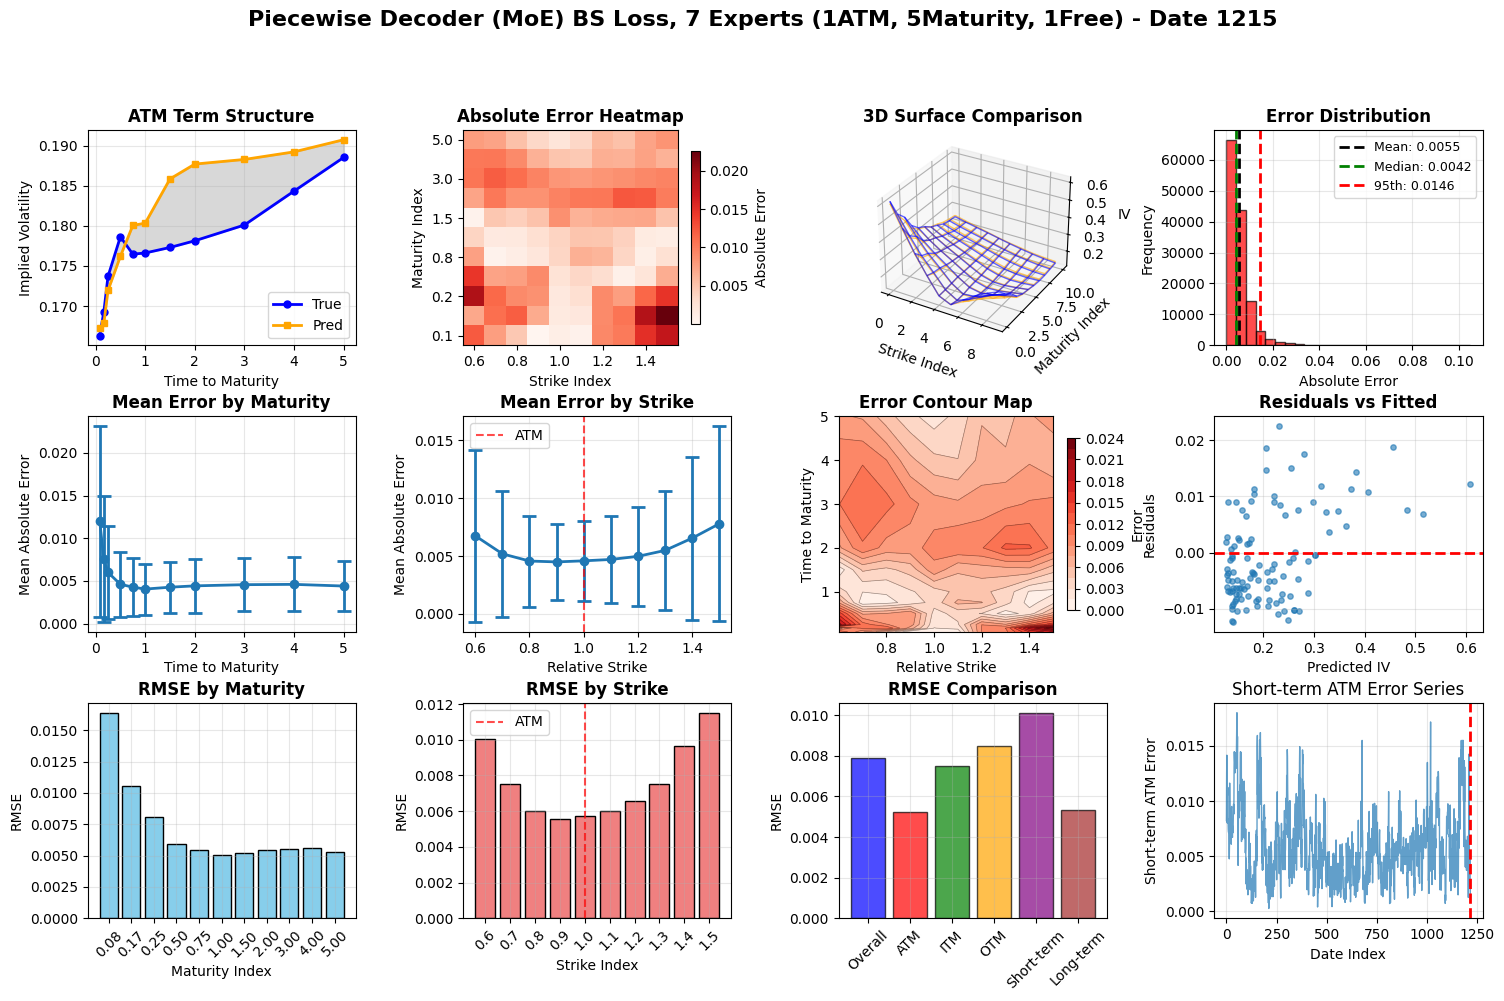

Overall Performance Category Performance  \
RMSE                           0.007868                  NaN   
MAE                            0.005509                  NaN   
Max Error                      0.104971                  NaN   
Mean Error                     0.005509                  NaN   
Median Error                   0.004234                  NaN   
95th Percentile                0.014647                  NaN   
ATM RMSE                            NaN             0.005216   
ITM RMSE                            NaN             0.007499   
OTM RMSE                            NaN             0.008497   
Short-term RMSE                     NaN             0.010094   
Long-term RMSE                      NaN             0.005348   
Short/Long Ratio                    NaN                1.887   
Best Maturity                       NaN                  NaN   
Worst Maturity                      NaN                  NaN   
Best Strike                         NaN                  NaN   
Worst Strike                        NaN                  NaN   
ATM Performance                     NaN                  NaN   
Overall Rank                        NaN                  NaN   
Short-term Bias                     NaN                  NaN   
ATM Issues                          NaN                  NaN   
Smile Asymmetry                     NaN                  NaN   
High Error Variance                 NaN                  NaN   
Model Quality                       NaN                  NaN   
Recommendation                      NaN                  NaN   

                      Best/Worst Performance          Diagnostic Flags  
RMSE                                     NaN                       NaN  
MAE                                      NaN                       NaN  
Max Error                                NaN                       NaN  
Mean Error                               NaN                       NaN  
Median Error                             NaN                       NaN  
95th Percentile                          NaN                       NaN  
ATM RMSE                                 NaN                       NaN  
ITM RMSE                                 NaN                       NaN  
OTM RMSE                                 NaN                       NaN  
Short-term RMSE                          NaN                       NaN  
Long-term RMSE                           NaN                       NaN  
Short/Long Ratio                         NaN                       NaN  
Best Maturity        τ=1.00 (RMSE: 0.005023)                       NaN  
Worst Maturity       τ=0.08 (RMSE: 0.016361)                       NaN  
Best Strike           K=0.9 (RMSE: 0.005554)                       NaN  
Worst Strike          K=1.5 (RMSE: 0.011491)                       NaN  
ATM Performance       K=1.0 (RMSE: 0.005756)                       NaN  
Overall Rank              ATM ranks #7 of 10                       NaN  
Short-term Bias                          NaN        YES (ratio: 1.887)  
ATM Issues                               NaN   NO (ATM/Overall: 0.66x)  
Smile Asymmetry                          NaN  NO (|ITM-OTM|: 0.000998)  
High Error Variance                      NaN       YES (std: 0.005618)  
Model Quality                            NaN                 EXCELLENT  
Recommendation                           NaN         Needs Improvement

In [31]:
import models.decoder
import importlib
importlib.reload(models.decoder)

import utils.plot_error
importlib.reload(utils.plot_error)
from utils.plot_error import analyze_decoder_comprehensive

# eval config
Z_eval = Z_decoder            # (N, latent_dim)
F_eval = F_aligned            # (N, feature_dim)
Y_full = Y_decoder            # (N, M*K) flattened ground truth

# prep strike-tau grid
m_grid, tau_grid = np.meshgrid(
  ops.convert_to_numpy(tensors["strike_tensor"]),
  ops.convert_to_numpy(tensors["taus"])
)
m_flat = m_grid.reshape(-1, 1).astype(np.float32)
tau_flat = tau_grid.reshape(-1, 1).astype(np.float32)

# generate predictions
Y_hat = np.stack([
  decoder_pw_mod_2.predict_surface(z, f, m_flat, tau_flat)
  for z, f in zip(Z_eval, F_eval)
])

# reshape ground truth to match
Y_full = Y_decoder.reshape(-1, decoder_pw.M, decoder_pw.K)

# run analysis
metrics = analyze_decoder_comprehensive(
  Y_true=Y_full,
  Y_pred=Y_hat,
  taus=ops.convert_to_numpy(tensors["taus"]),
  rel_strikes=ops.convert_to_numpy(tensors["strike_tensor"]),
  date_idx=-1,
  dates=None,
  title="Piecewise Decoder (MoE) BS Loss, 7 Experts (1ATM, 5Maturity, 1Free)"
)

In [32]:
from utils.plot_error import summarize_decoder_errors, collect_decoder_summaries

# extract insights for tracking
summary_pw_moe_2 = summarize_decoder_errors(
   Y_true=Y_full, 
   Y_pred=Y_hat,
   taus=taus, 
   rel_strikes=rel_strikes,
   name=name,
   model=decoder_pw_mod_2
)

# collect and compare experiments  
summary_all_decoders = collect_decoder_summaries(
   summary_pw_decoder,
   summary_pw_moe,
   summary_pw_moe_2
)

display(summary_all_decoders)

Name  Rank Overall_RMSE  \
0  Piecewise Decoder with BS Loss (MoE) 7 Experts...     1     0.007644   
1   piecewise moe v2 - 7exp (4mat/2free) relu div0.3     2     0.007868   
2                   Piecewise Decoder with BS LossAE     3     0.010897   

  Overall_MAE  ATM_RMSE   ATM_MAE  ITM_RMSE  OTM_RMSE Short_Long_Ratio  \
0    0.005167  0.005588  0.003875  0.006978  0.008466         2.095340   
1    0.005509  0.005756  0.004586  0.007499  0.008497         1.887222   
2    0.007785  0.011576  0.007950  0.010046  0.011400         2.270829   

  Max_Error  Short_Term_Bias  ATM_Issues Model_Quality  Production_Ready  
0  0.115388             True       False     EXCELLENT             False  
1  0.104971             True       False     EXCELLENT             False  
2  0.078387             True       False          GOOD             False

In [33]:
####  Experiment 3

training moe modular decoder
Expert allocation: ATM=0, Maturity=0, Free=4, Total=4
Epoch 1/150
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 60s 20ms/step - loss: 2.6199 - val_loss: 0.3915 - learning_rate: 1.0000e-04
Epoch 2/150
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 60s 21ms/step - loss: 0.2789 - val_loss: 0.1379 - learning_rate: 1.0000e-04
Epoch 3/150
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 59s 20ms/step - loss: 0.0995 - val_loss: 0.0714 - learning_rate: 1.0000e-04
Epoch 4/150
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 71s 24ms/step - loss: 0.0551 - val_loss: 0.0517 - learning_rate: 1.0000e-04
Epoch 5/150
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 66s 23ms/step - loss: 0.0370 - val_loss: 0.0368 - learning_rate: 1.0000e-04
Epoch 6/150
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 64s 22ms/step - loss: 0.0279 - val_loss: 0.0336 - learning_rate: 1.0000e-04
Epoch 7/150
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 63s 22ms/step - loss: 0.0224 - val_loss: 0.0223 - learning_rate: 1.0000e-04
Epoch 8/150
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 64s 22ms/step - loss: 0.0188 - val_loss: 

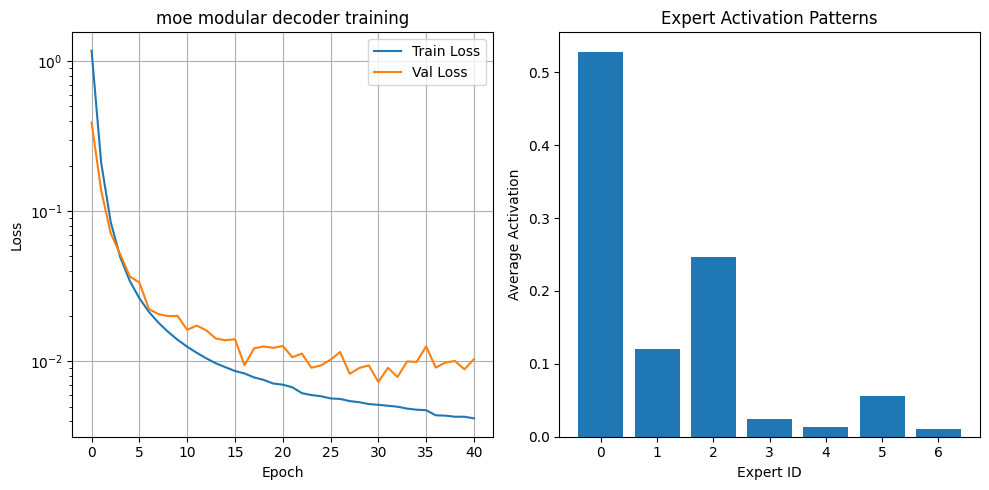

In [35]:
import models.pointwise_moe
import importlib
importlib.reload(models.pointwise_moe)



# choose moe or standard
USE_MOE = True

print(f"training {'moe' if USE_MOE else 'standard'} modular decoder")

# instantiate decoder
decoder_pw_mod_3 = PiecewiseSurfaceDecoderModular(
   latent_dim=LATENT_DIM,
   M=M, K=K, taus=taus,
   feature_dim=F_aligned.shape[1],
   activation="gelu",
   use_moe=True,
   num_experts=4,
   
   # ultra short-term focus
   maturity_experts=4, # only maturity experts
   free_experts=0,
   maturity_specialization=False,
   
   # disable atm bias
   atm_specialization=False,
   atm_loss_weight=1.0,
   
   # higher diversity
   lambda_diversity=0.25,
)

decoder_pw_mod_3.compile(optimizer=Adam(learning_rate=1e-4, clipnorm=1.0), loss=hybrid_loss_fn)

# training callbacks
model_suffix = "moe" if USE_MOE else "standard"
os.makedirs(f"saved_models/ae/piecewise_surface_mod_{model_suffix}", exist_ok=True)
callbacks = [
   EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True, min_delta=1e-5),
   ReduceLROnPlateau(monitor="val_loss", factor=0.7, patience=5, min_lr=1e-7),
   ModelCheckpoint(f"saved_models/ae/piecewise_surface_mod_{model_suffix}_3/decoder.keras", save_best_only=True, verbose=0)
]

# fit model
history = decoder_pw_mod_3.fit(
   X_train, y_train,
   validation_data=(X_val, y_val),
   batch_size=BATCH_SIZE,
   epochs=150,
   callbacks=callbacks,
   verbose=1
)

print(f"final train loss: {history.history['loss'][-1]:.6f}")
print(f"final val loss: {history.history['val_loss'][-1]:.6f}")

# plot training
print(f"final train loss: {history.history['loss'][-1]:.6f}")
print(f"final val loss: {history.history['val_loss'][-1]:.6f}")

# plot training history
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title(f"{'moe' if USE_MOE else 'standard'} modular decoder training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.yscale('log')

if USE_MOE:
   plt.subplot(1, 2, 2)
   # check expert patterns
   analysis = decoder_pw_mod_2.analyze_gating(X_val)
   if analysis is not None:
       plt.bar(range(decoder_pw_mod.num_experts), analysis['expert_activations'])
       plt.title("Expert Activation Patterns")
       plt.xlabel("Expert ID")
       plt.ylabel("Average Activation")
       plt.xticks(range(decoder_pw_mod.num_experts))
       
       print(f"\nexpert analysis:")
       print(f"  expert activations: {analysis['expert_activations']}")
       print(f"  average entropy: {analysis['gate_entropy'].mean():.3f}")

plt.tight_layout()
plt.show()

y_hat shape: (1216, 11, 10)
y_full shape: (1216, 110)
Evaluation dimensions: N=1216, M=11, K=10
ex 3. Piecewise Decoder (MoE) BS Loss, 4 Experts (0ATM, 4Maturity, 0Free) RMSE_σ: 0.0065
RMSE by maturity (mean ± std): 0.0067 ± 0.0031
RMSE by strike    (mean ± std): 0.0072 ± 0.0017
Plotting last surface shapes: true=(11, 10), pred=(11, 10)


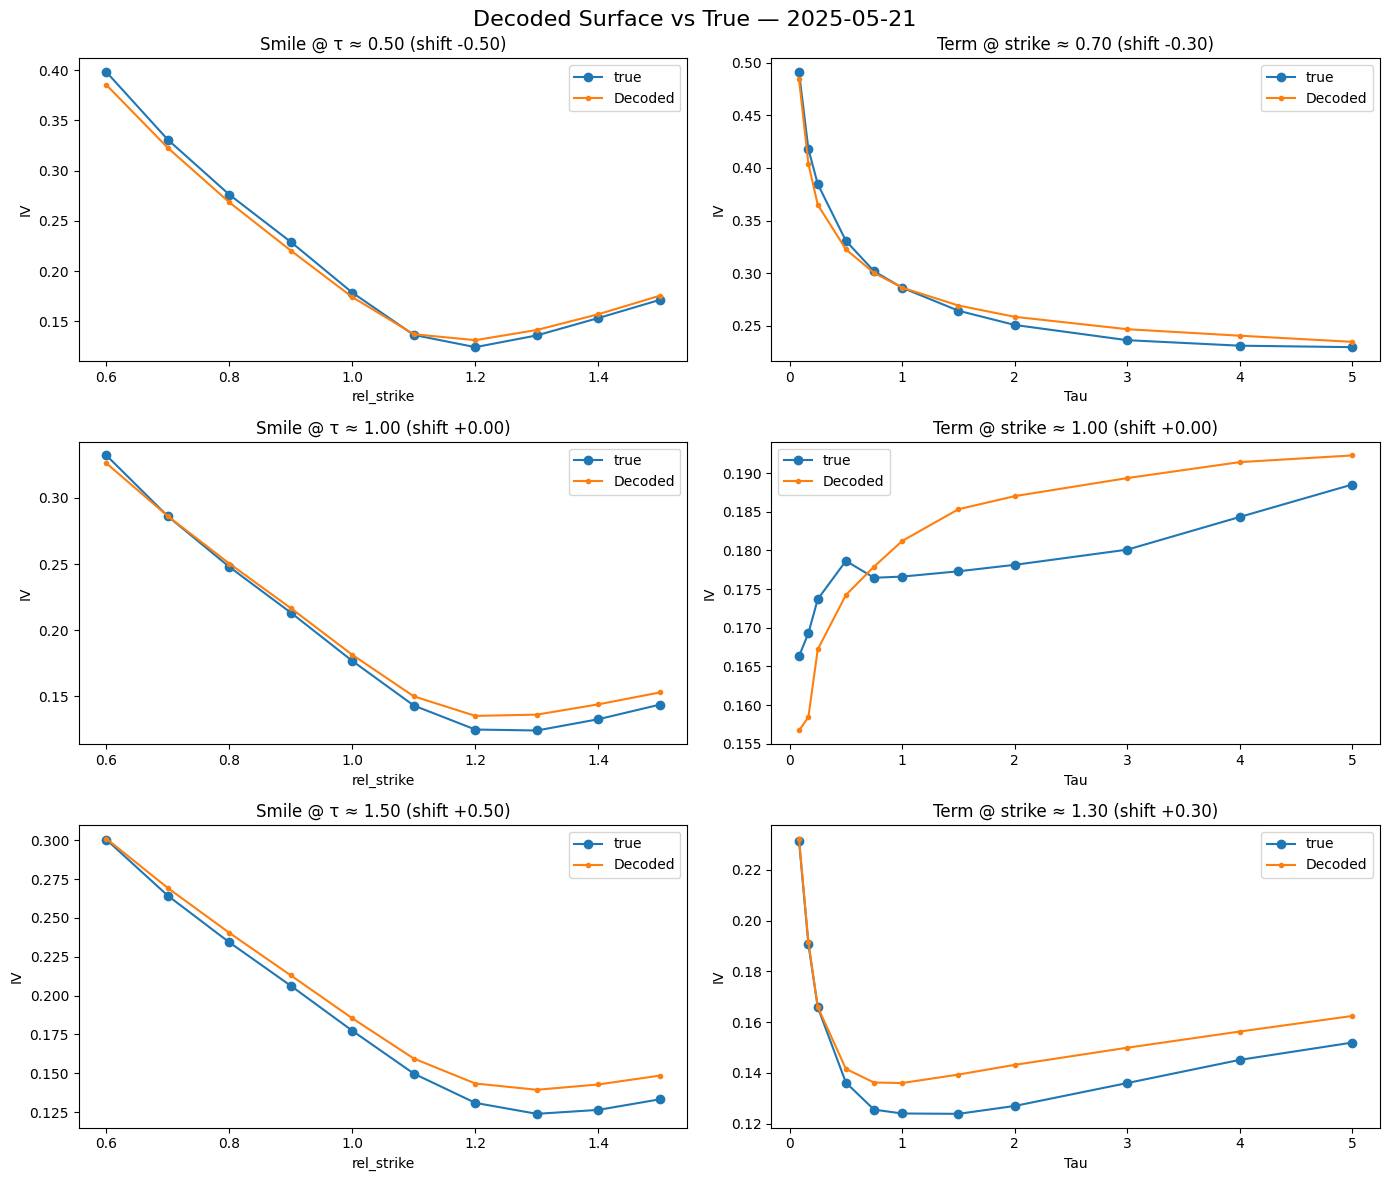

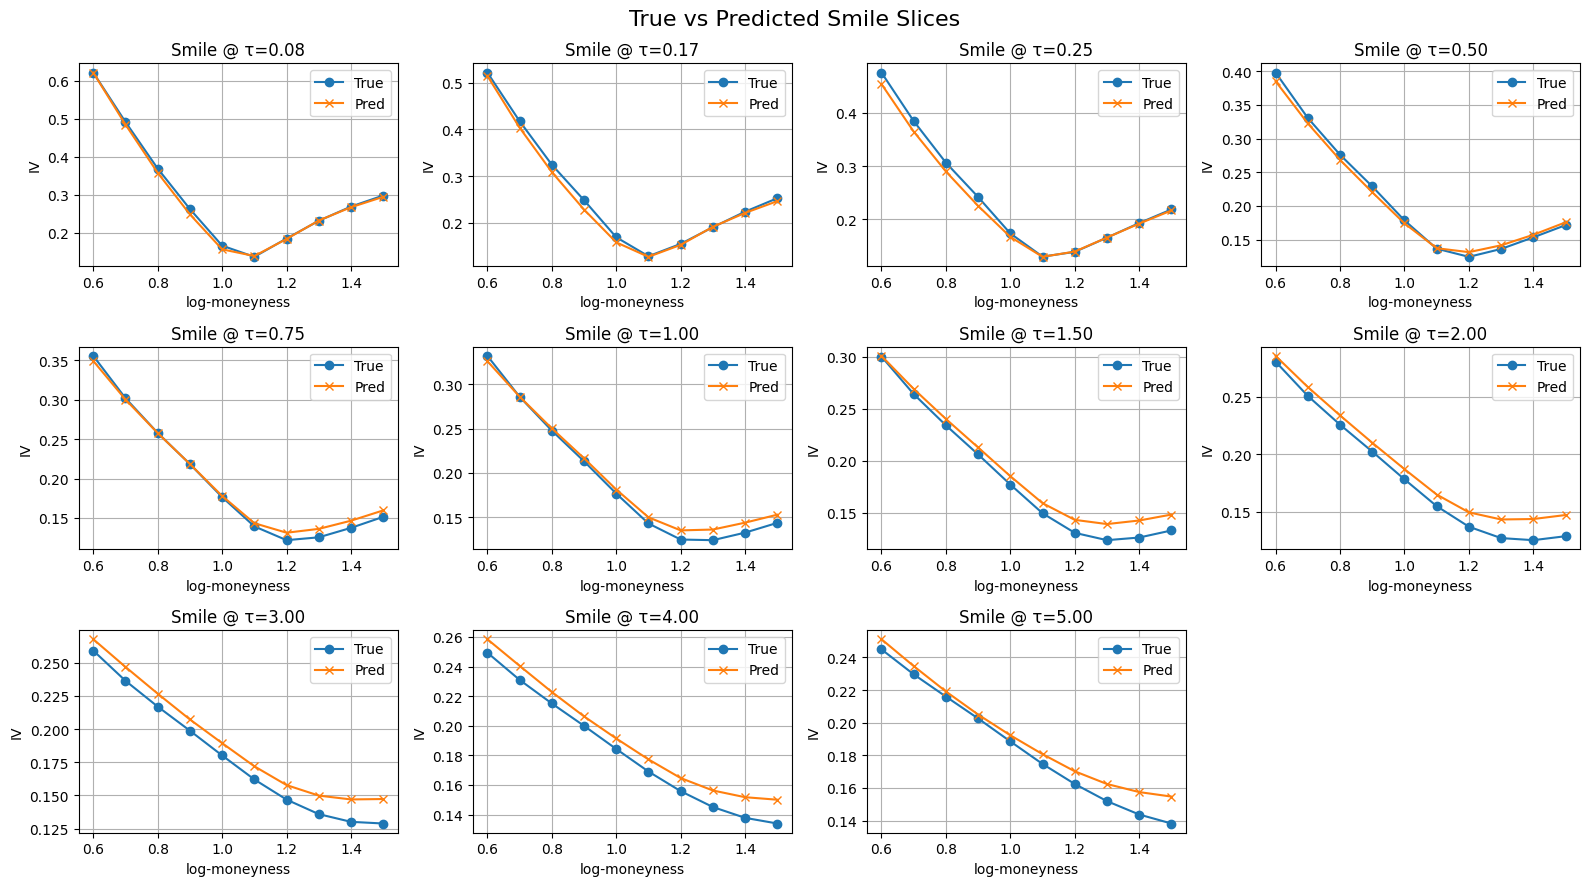

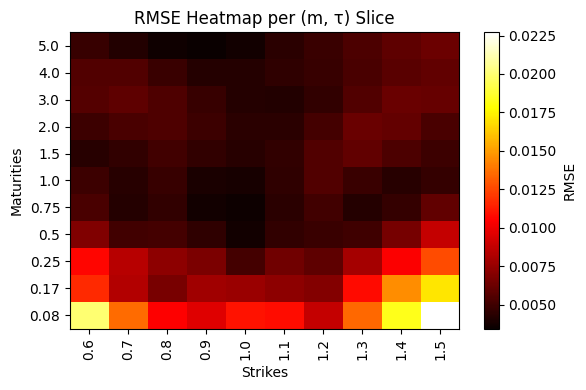

MoE Analysis
Experts: 4
Diversity: 0.25


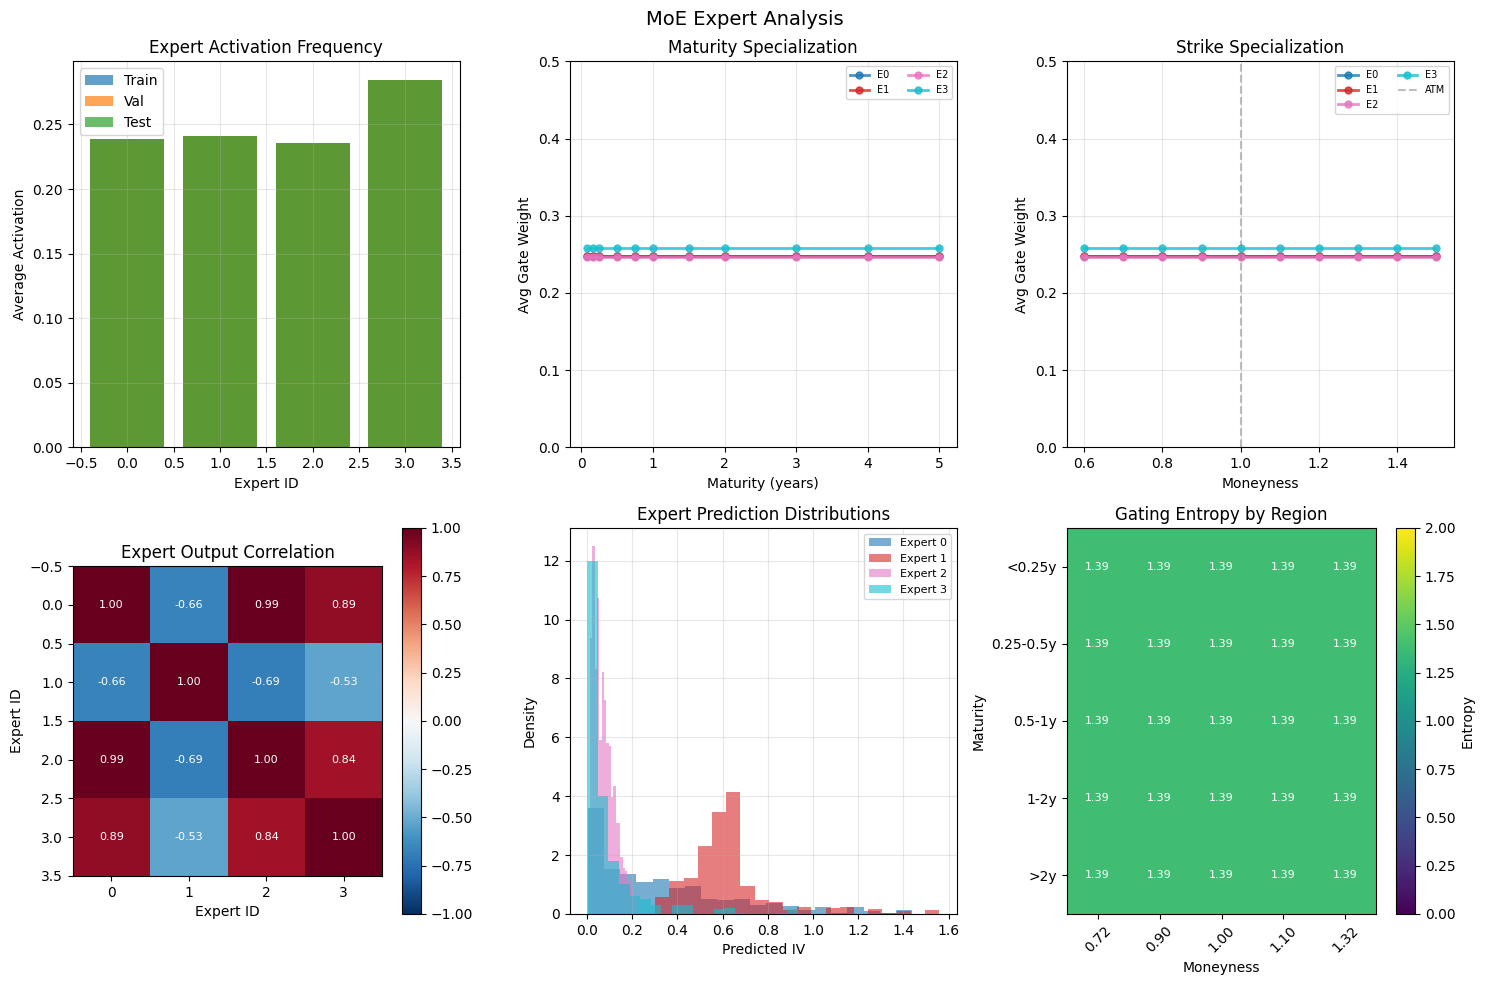


Summary:
Most active expert: 3
Least active expert: 2
Balance score: 0.980
Avg entropy: 1.383
Min correlation: -0.686
Max correlation: 0.989


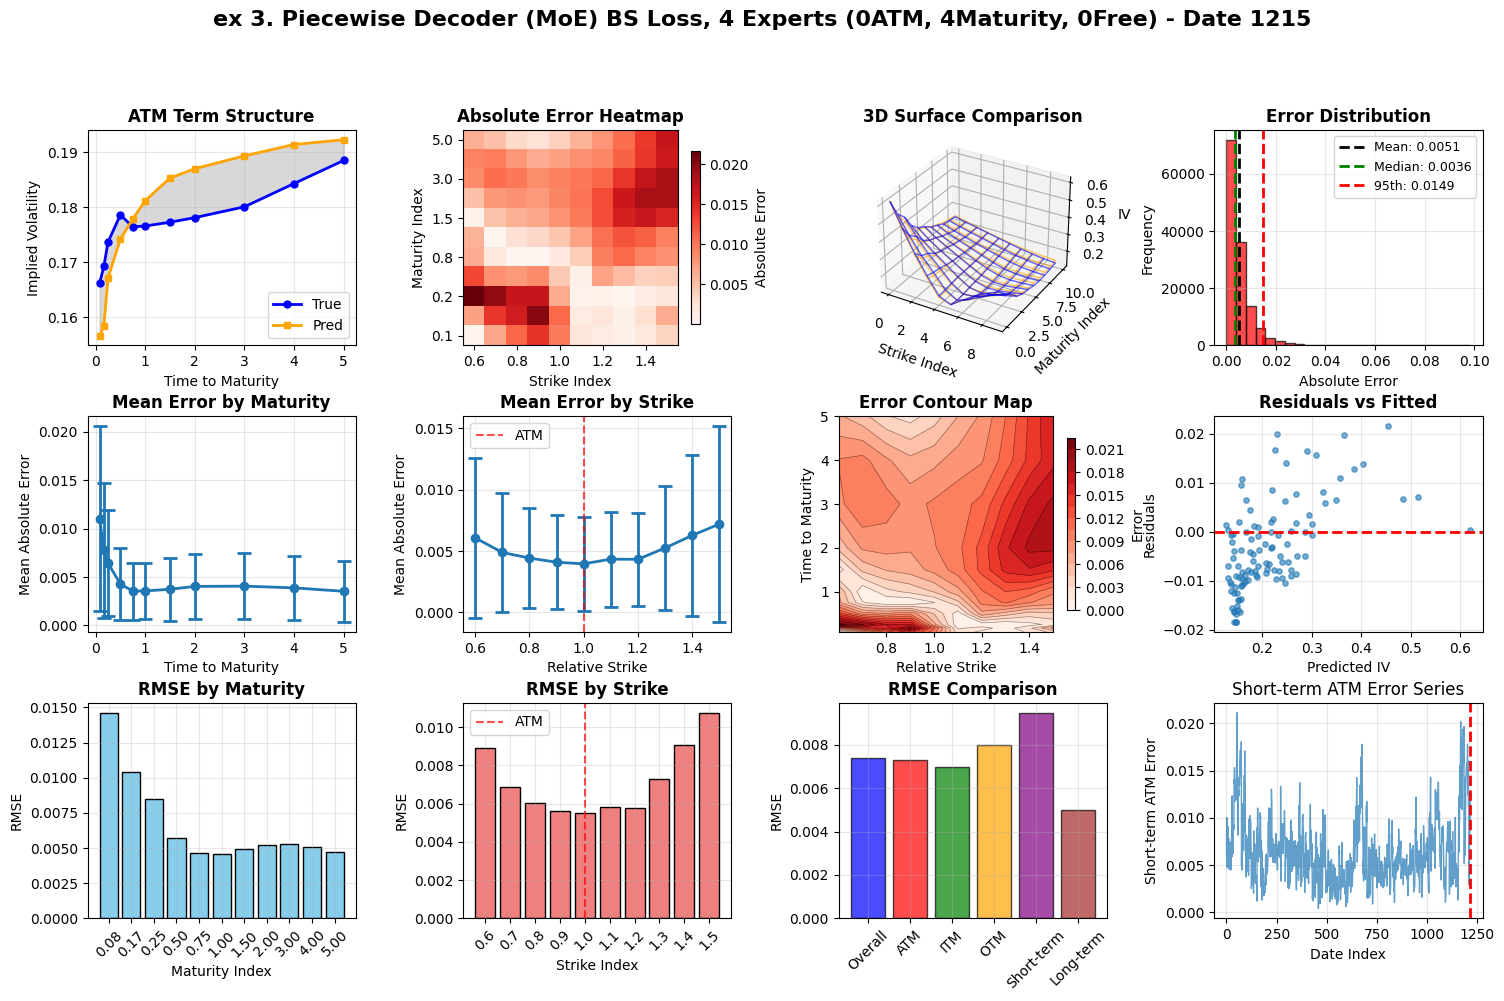

Overall Performance Category Performance  \
RMSE                           0.007368                  NaN   
MAE                            0.005083                  NaN   
Max Error                      0.098493                  NaN   
Mean Error                     0.005083                  NaN   
Median Error                   0.003587                  NaN   
95th Percentile                0.014930                  NaN   
ATM RMSE                            NaN             0.007315   
ITM RMSE                            NaN             0.006966   
OTM RMSE                            NaN             0.007979   
Short-term RMSE                     NaN             0.009460   
Long-term RMSE                      NaN             0.004995   
Short/Long Ratio                    NaN                1.894   
Best Maturity                       NaN                  NaN   
Worst Maturity                      NaN                  NaN   
Best Strike                         NaN                  NaN   
Worst Strike                        NaN                  NaN   
ATM Performance                     NaN                  NaN   
Overall Rank                        NaN                  NaN   
Short-term Bias                     NaN                  NaN   
ATM Issues                          NaN                  NaN   
Smile Asymmetry                     NaN                  NaN   
High Error Variance                 NaN                  NaN   
Model Quality                       NaN                  NaN   
Recommendation                      NaN                  NaN   

                      Best/Worst Performance          Diagnostic Flags  
RMSE                                     NaN                       NaN  
MAE                                      NaN                       NaN  
Max Error                                NaN                       NaN  
Mean Error                               NaN                       NaN  
Median Error                             NaN                       NaN  
95th Percentile                          NaN                       NaN  
ATM RMSE                                 NaN                       NaN  
ITM RMSE                                 NaN                       NaN  
OTM RMSE                                 NaN                       NaN  
Short-term RMSE                          NaN                       NaN  
Long-term RMSE                           NaN                       NaN  
Short/Long Ratio                         NaN                       NaN  
Best Maturity        τ=1.00 (RMSE: 0.004587)                       NaN  
Worst Maturity       τ=0.08 (RMSE: 0.014599)                       NaN  
Best Strike           K=1.0 (RMSE: 0.005516)                       NaN  
Worst Strike          K=1.5 (RMSE: 0.010741)                       NaN  
ATM Performance       K=1.0 (RMSE: 0.005516)                       NaN  
Overall Rank              ATM ranks #3 of 10                       NaN  
Short-term Bias                          NaN        YES (ratio: 1.894)  
ATM Issues                               NaN   NO (ATM/Overall: 0.99x)  
Smile Asymmetry                          NaN  NO (|ITM-OTM|: 0.001013)  
High Error Variance                      NaN       YES (std: 0.005334)  
Model Quality                            NaN                 EXCELLENT  
Recommendation                           NaN         Needs Improvement

In [36]:
import models.decoder
import utils.plotting
import utils.eval
import importlib
importlib.reload(models.decoder)
importlib.reload(utils.plotting)
importlib.reload(utils.eval)

from utils.eval import evaluate_decoder_output_v2

# eval config
Z_eval = Z_decoder            # (N, latent_dim)
F_eval = F_aligned            # (N, feature_dim)
Y_full = Y_decoder            # (N, M*K) flattened ground truth

# prep strike-tau grid
m_grid, tau_grid = np.meshgrid(
  ops.convert_to_numpy(tensors["strike_tensor"]),
  ops.convert_to_numpy(tensors["taus"])
)
m_flat = m_grid.reshape(-1, 1).astype(np.float32)
tau_flat = tau_grid.reshape(-1, 1).astype(np.float32)

# generate predictions
Y_hat = np.stack([
  decoder_pw_mod_3.predict_surface(z, f, m_flat, tau_flat)
  for z, f in zip(Z_eval, F_eval)
])

print(f"y_hat shape: {Y_hat.shape}")
print(f"y_full shape: {Y_full.shape}")

title = "ex 3. Piecewise Decoder (MoE) BS Loss, 4 Experts (0ATM, 4Maturity, 0Free)"

# evaluate
evaluate_decoder_output_v2(
   Y_pred=Y_hat,
   Y_true=Y_full,
   tensors=tensors,
   rel_strikes=ops.convert_to_numpy(tensors["strike_tensor"]),
   taus=ops.convert_to_numpy(tensors["taus"]),
   target_date=TARGET_DATE,
   target_tau=TARGET_TAU,
   target_strike=TARGET_STRIKE,
   decoder=decoder_pw_mod,
   title=title
)

import importlib
import utils.eval
importlib.reload(utils.eval)

from utils.eval import analyze_moe_training_performance

# analyze moe performance
results = analyze_moe_training_performance(
   decoder_pw_mod_3,
   X_train,
   X_val,
   X_test,
   y_train,
   y_val,
   y_test
)

import models.decoder
import importlib
importlib.reload(models.decoder)

import utils.plot_error
importlib.reload(utils.plot_error)
from utils.plot_error import analyze_decoder_comprehensive

# eval config again
Z_eval = Z_decoder
F_eval = F_aligned
Y_full = Y_decoder

# prep grid
m_grid, tau_grid = np.meshgrid(
  ops.convert_to_numpy(tensors["strike_tensor"]),
  ops.convert_to_numpy(tensors["taus"])
)
m_flat = m_grid.reshape(-1, 1).astype(np.float32)
tau_flat = tau_grid.reshape(-1, 1).astype(np.float32)

# generate predictions
Y_hat = np.stack([
  decoder_pw_mod_3.predict_surface(z, f, m_flat, tau_flat)
  for z, f in zip(Z_eval, F_eval)
])

# reshape ground truth
Y_full = Y_decoder.reshape(-1, decoder_pw.M, decoder_pw.K)

# run analysis
metrics = analyze_decoder_comprehensive(
  Y_true=Y_full,
  Y_pred=Y_hat,
  taus=ops.convert_to_numpy(tensors["taus"]),
  rel_strikes=ops.convert_to_numpy(tensors["strike_tensor"]),
  date_idx=-1,
  dates=None,
  title=title
)

In [37]:
from utils.plot_error import summarize_decoder_errors, collect_decoder_summaries

# extract insights for tracking
summary_pw_moe_3 = summarize_decoder_errors(
   Y_true=Y_full, 
   Y_pred=Y_hat,
   taus=taus, 
   rel_strikes=rel_strikes,
   name=name,
   model=decoder_pw_mod_3
)

# collect and compare experiments  
summary_all_decoders = collect_decoder_summaries(
   summary_pw_decoder,
   summary_pw_moe,
   summary_pw_moe_2,
   summary_pw_moe_3
)

display(summary_all_decoders)

Name  Rank Overall_RMSE  \
0   piecewise moe v2 - 7exp (4mat/2free) relu div0.3     1     0.007368   
1  Piecewise Decoder with BS Loss (MoE) 7 Experts...     2     0.007644   
2   piecewise moe v2 - 7exp (4mat/2free) relu div0.3     3     0.007868   
3                   Piecewise Decoder with BS LossAE     4     0.010897   

  Overall_MAE  ATM_RMSE   ATM_MAE  ITM_RMSE  OTM_RMSE Short_Long_Ratio  \
0    0.005083  0.005516  0.003962  0.006966  0.007979         1.894017   
1    0.005167  0.005588  0.003875  0.006978  0.008466         2.095340   
2    0.005509  0.005756  0.004586  0.007499  0.008497         1.887222   
3    0.007785  0.011576  0.007950  0.010046  0.011400         2.270829   

  Max_Error  Short_Term_Bias  ATM_Issues Model_Quality  Production_Ready  
0  0.098493             True       False     EXCELLENT             False  
1  0.115388             True       False     EXCELLENT             False  
2  0.104971             True       False     EXCELLENT             False  
3  0.078387             True       False          GOOD             False

### Experiment 4 

training moe modular decoder
Expert allocation: ATM=0, Maturity=0, Free=3, Total=3
Epoch 1/150
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 68s 23ms/step - loss: 6.0905 - val_loss: 1.5540 - learning_rate: 1.0000e-05
Epoch 2/150
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 67s 23ms/step - loss: 1.3331 - val_loss: 1.1585 - learning_rate: 1.0000e-05
Epoch 3/150
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 65s 22ms/step - loss: 1.0455 - val_loss: 0.9354 - learning_rate: 1.0000e-05
Epoch 4/150
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 63s 21ms/step - loss: 0.8349 - val_loss: 0.7456 - learning_rate: 1.0000e-05
Epoch 5/150
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 65s 22ms/step - loss: 0.6715 - val_loss: 0.6051 - learning_rate: 1.0000e-05
Epoch 6/150
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 66s 22ms/step - loss: 0.5435 - val_loss: 0.4974 - learning_rate: 1.0000e-05
Epoch 7/150
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 79s 27ms/step - loss: 0.4479 - val_loss: 0.4176 - learning_rate: 1.0000e-05
Epoch 8/150
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 70s 24ms/step - loss: 0.3724 - val_loss: 

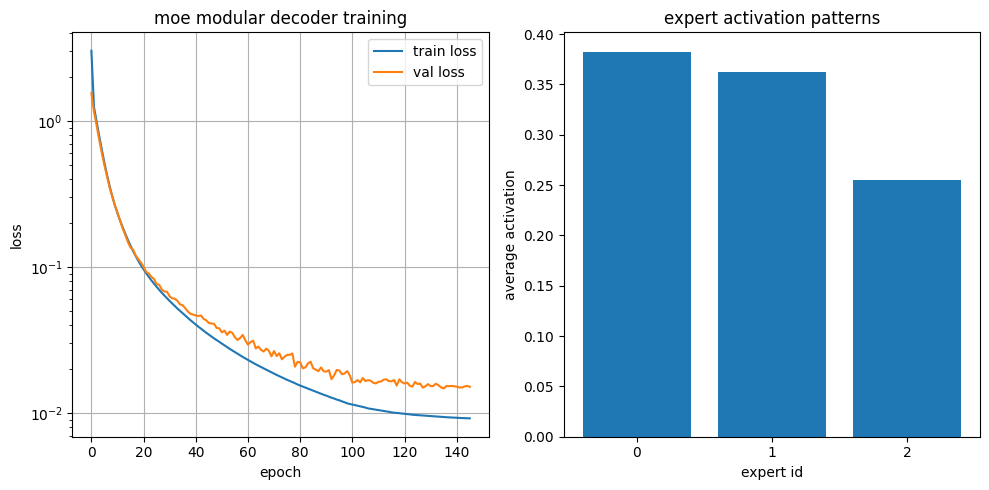

In [38]:
import models.pointwise_moe
import importlib
importlib.reload(models.pointwise_moe)

from models.pointwise_moe import PiecewiseSurfaceDecoderModular
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import os
import matplotlib.pyplot as plt
import torch

# choose moe or standard
USE_MOE = True

print(f"training {'moe' if USE_MOE else 'standard'} modular decoder")

# instantiate decoder
decoder_pw_mod_4 = PiecewiseSurfaceDecoderModular(
   latent_dim=LATENT_DIM,
   M=M, K=K, taus=taus,
   feature_dim=F_aligned.shape[1],
   activation="gelu",
   use_moe=True,
   num_experts=3,
   
   # ultra short-term focus
   maturity_experts=0,
   free_experts=3,
   maturity_specialization=True,
   
   # disable atm bias
   atm_specialization=False,
   atm_loss_weight=1.0,
   
   # higher diversity
   lambda_diversity=0.5,
)

decoder_pw_mod_4.compile(optimizer=Adam(learning_rate=1e-5, clipnorm=1.0), loss=hybrid_loss_fn)

# training callbacks
model_suffix = "moe" if USE_MOE else "standard"
os.makedirs(f"saved_models/ae/piecewise_surface_mod_{model_suffix}", exist_ok=True)
callbacks = [
   EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True, min_delta=1e-5),
   ReduceLROnPlateau(monitor="val_loss", factor=0.7, patience=5, min_lr=1e-7),
   ModelCheckpoint(f"saved_models/ae/piecewise_surface_mod_{model_suffix}_4/decoder.keras", save_best_only=True, verbose=0)
]

# fit model - fixed: should be decoder_pw_mod_4
history = decoder_pw_mod_4.fit(
   X_train, y_train,
   validation_data=(X_val, y_val),
   batch_size=BATCH_SIZE,
   epochs=150,
   callbacks=callbacks,
   verbose=1
)

print(f"final train loss: {history.history['loss'][-1]:.6f}")
print(f"final val loss: {history.history['val_loss'][-1]:.6f}")

# plot training
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="val loss")
plt.title(f"{'moe' if USE_MOE else 'standard'} modular decoder training")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.grid(True)
plt.yscale('log')

if USE_MOE:
   plt.subplot(1, 2, 2)
   # analyze gating - fixed: should be decoder_pw_mod_4
   analysis = decoder_pw_mod_4.analyze_gating(X_val)
   if analysis is not None:
       plt.bar(range(decoder_pw_mod_4.num_experts), analysis['expert_activations'])
       plt.title("expert activation patterns")
       plt.xlabel("expert id")
       plt.ylabel("average activation")
       plt.xticks(range(decoder_pw_mod_4.num_experts))
       
       print(f"\nexpert analysis:")
       print(f"  expert activations: {analysis['expert_activations']}")
       print(f"  average entropy: {analysis['gate_entropy'].mean():.3f}")

plt.tight_layout()
plt.show()

y_hat shape: (1216, 11, 10)
y_full shape: (1216, 110)
Evaluation dimensions: N=1216, M=11, K=10
Piecewise Decoder with BS Loss, Moe 3 Experts (0ATM, 0Maturity, 3Free) RMSE_σ: 0.0079
RMSE by maturity (mean ± std): 0.0082 ± 0.0037
RMSE by strike    (mean ± std): 0.0088 ± 0.0017
Plotting last surface shapes: true=(11, 10), pred=(11, 10)


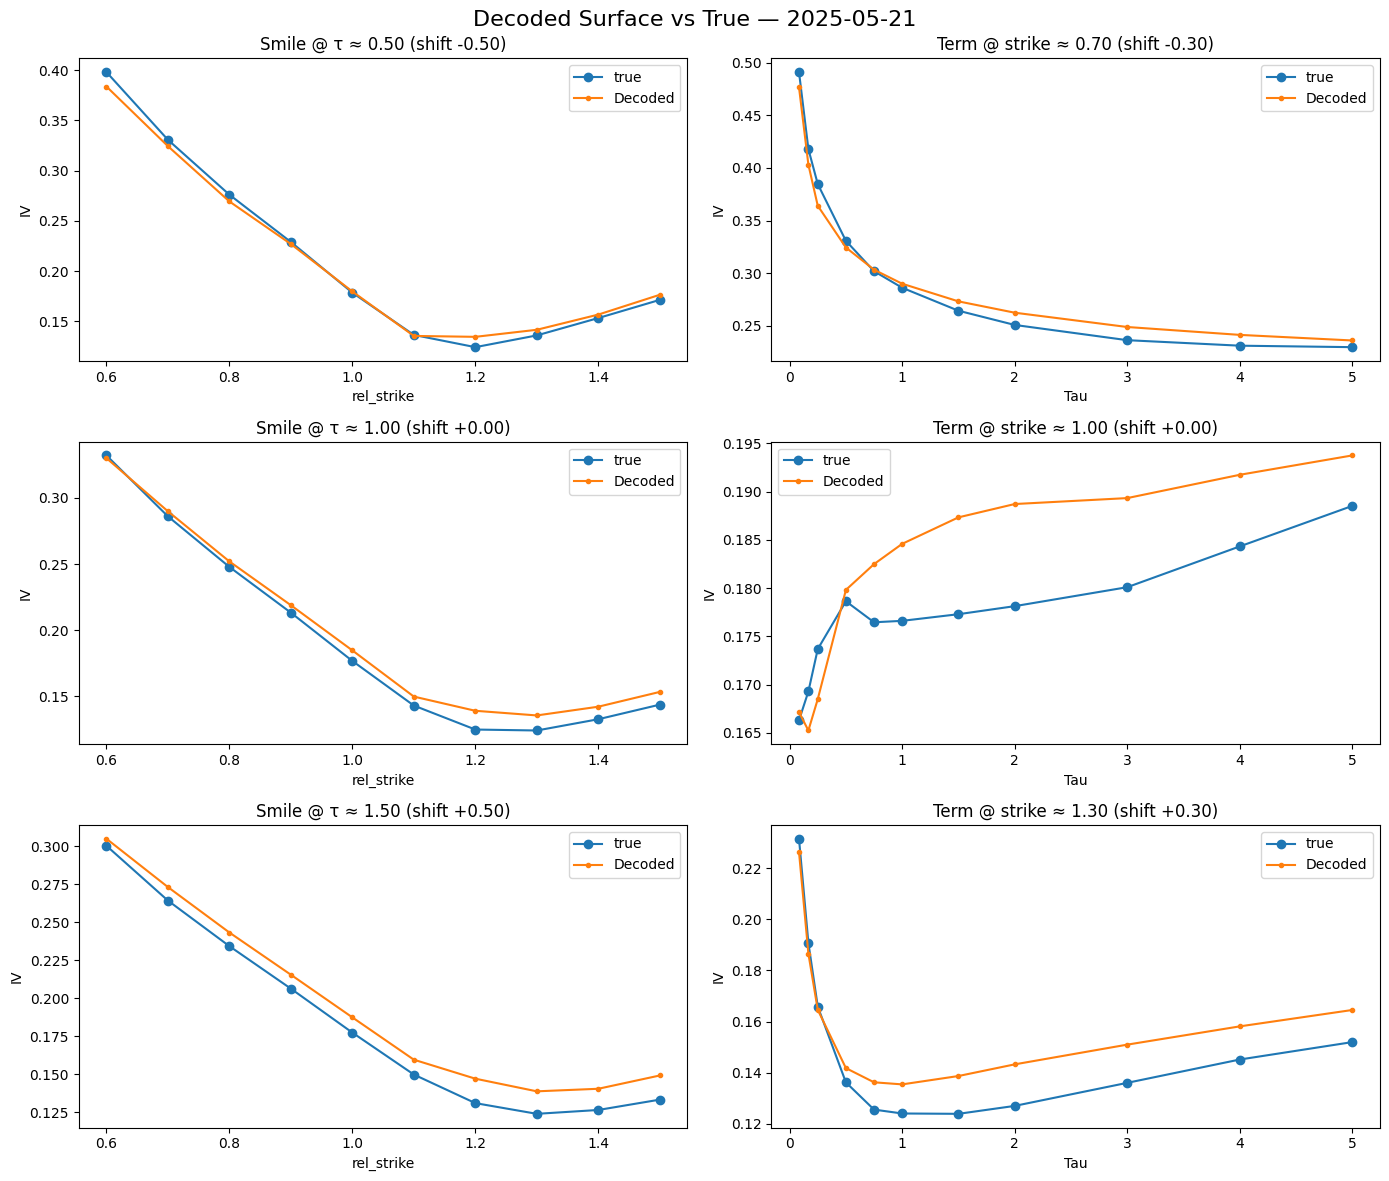

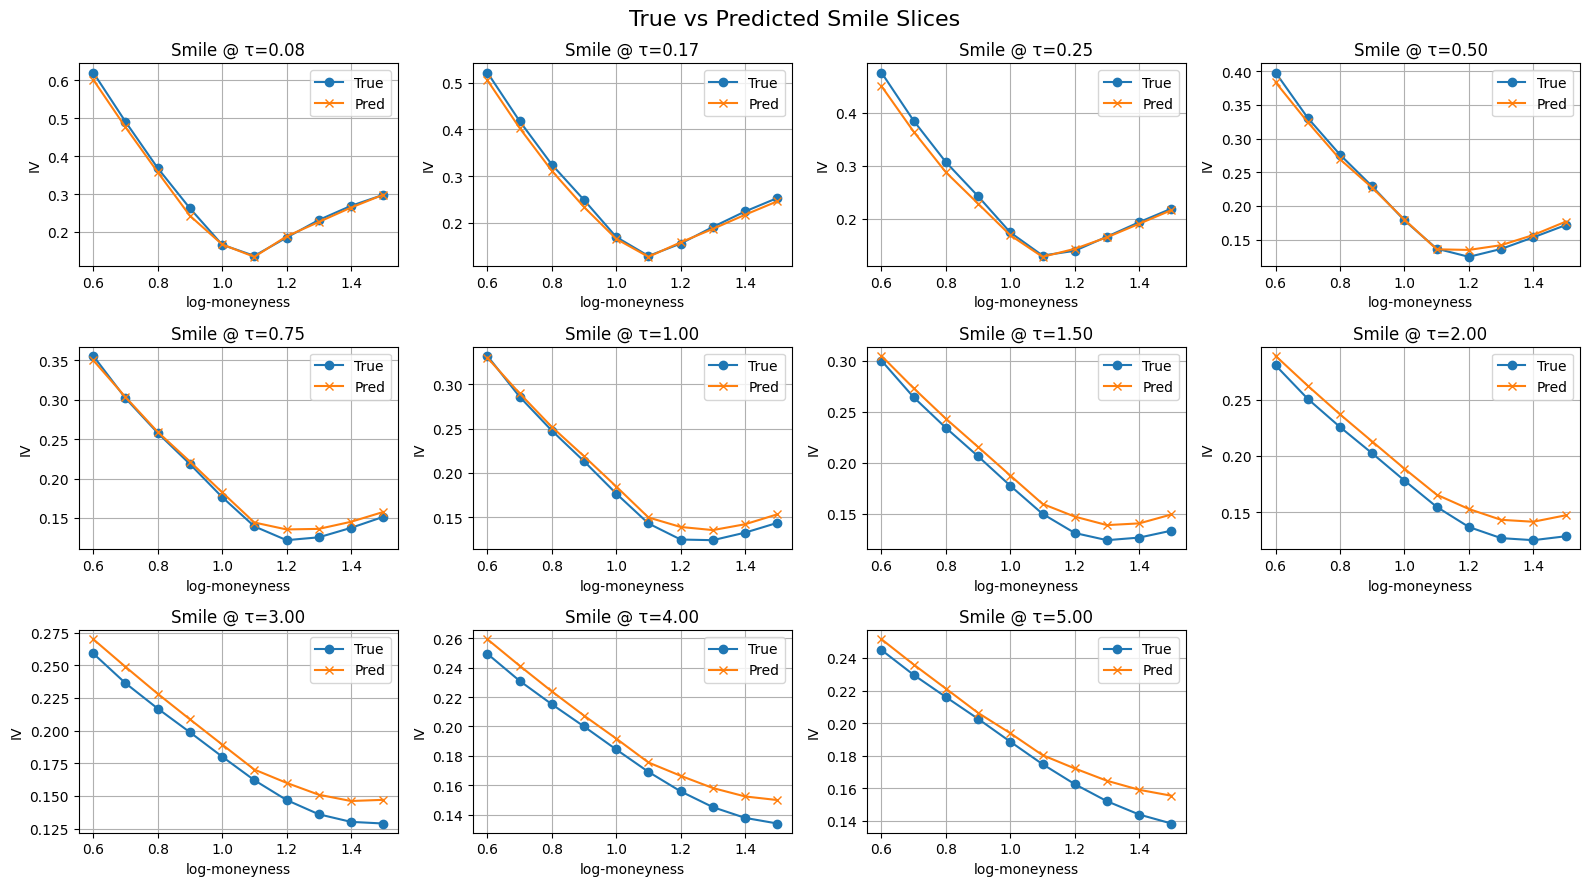

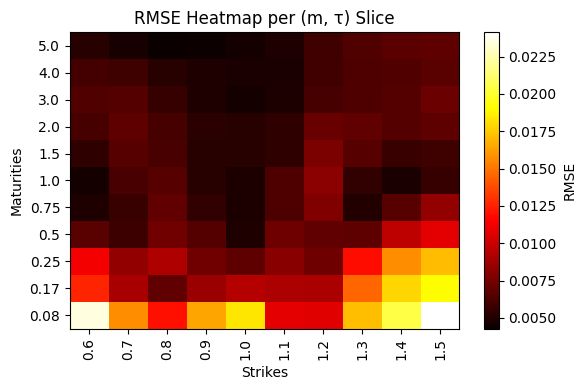

MoE Analysis
Experts: 3
Diversity: 0.5


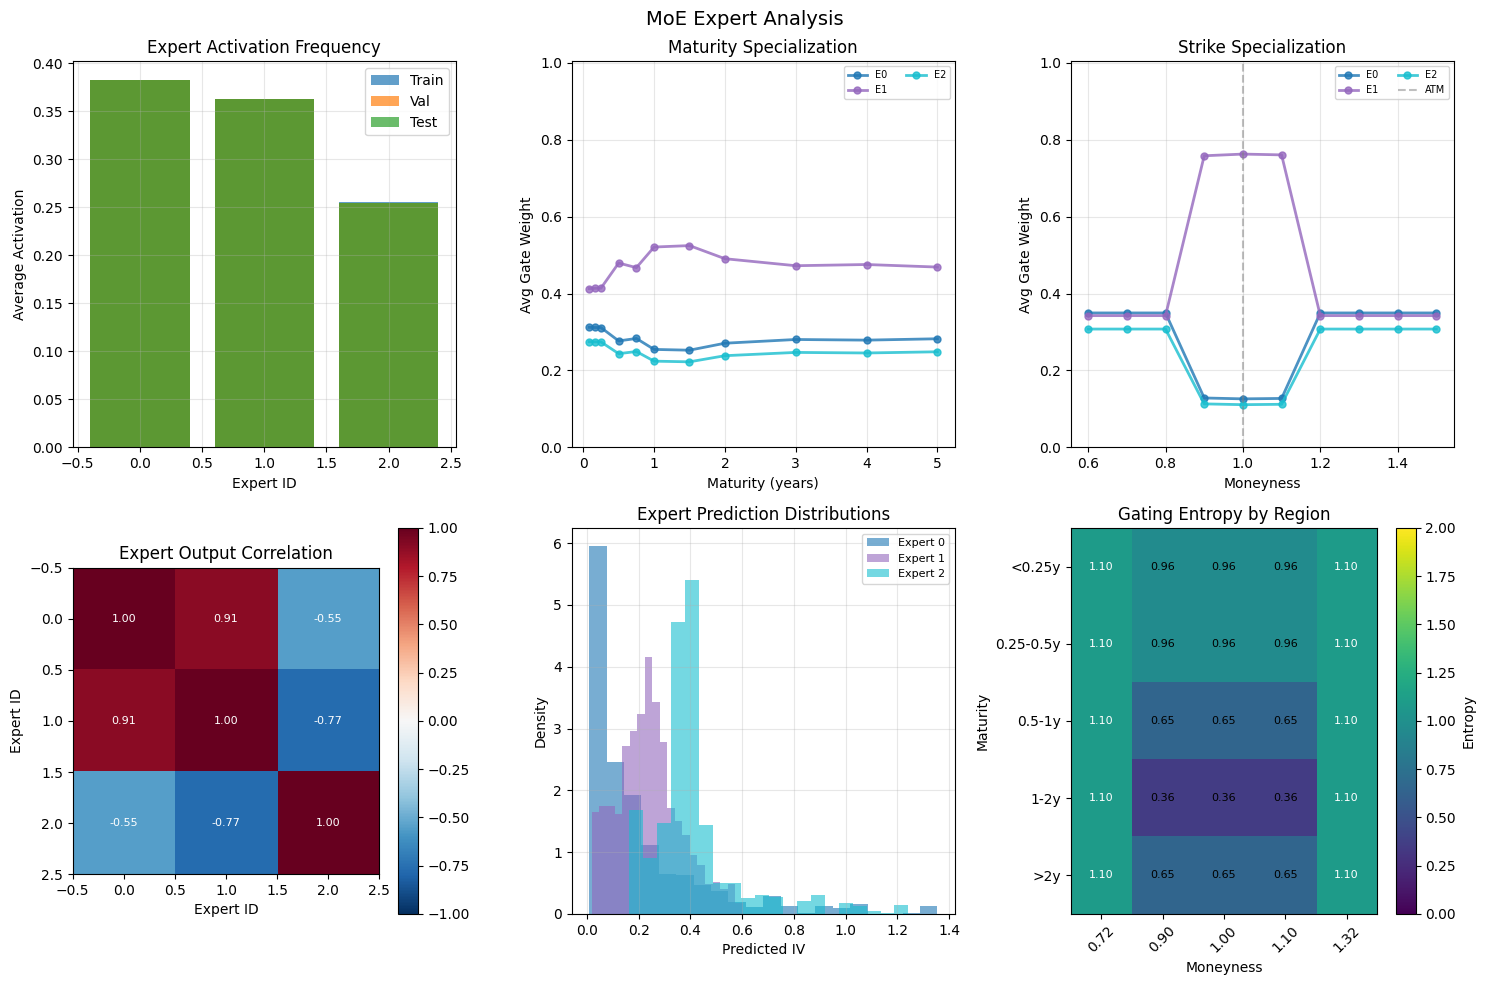


Summary:
Most active expert: 0
Least active expert: 2
Balance score: 0.944
Avg entropy: 1.084
Min correlation: -0.769
Max correlation: 0.906


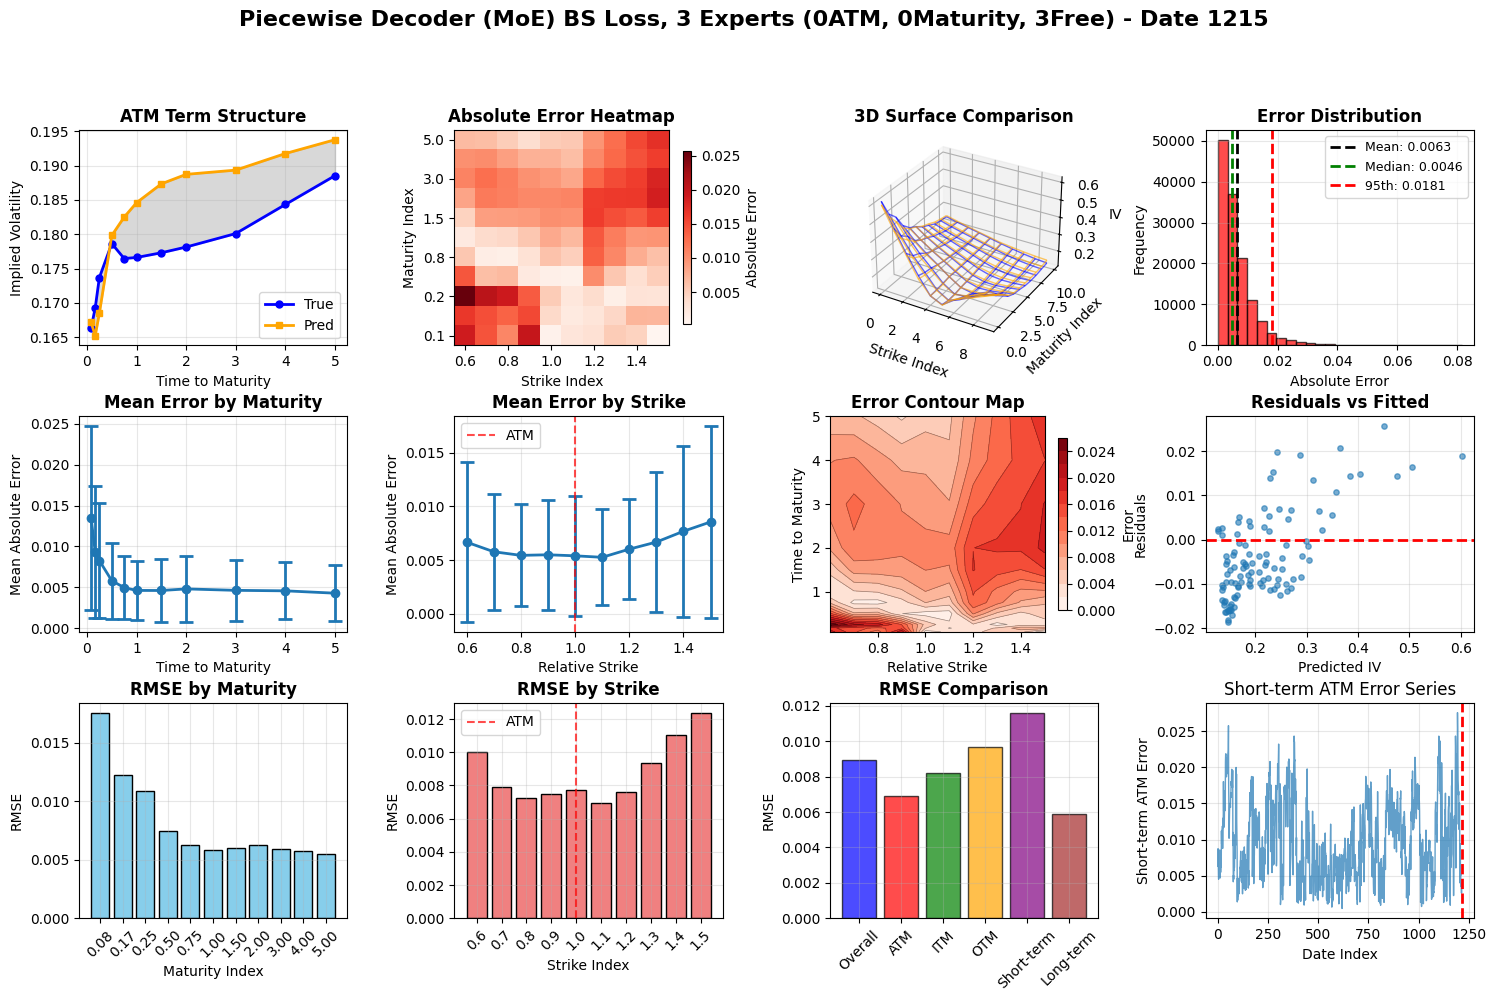

Overall Performance Category Performance  \
RMSE                           0.008942                  NaN   
MAE                            0.006303                  NaN   
Max Error                      0.081557                  NaN   
Mean Error                     0.006303                  NaN   
Median Error                   0.004574                  NaN   
95th Percentile                0.018054                  NaN   
ATM RMSE                            NaN             0.006914   
ITM RMSE                            NaN             0.008229   
OTM RMSE                            NaN             0.009681   
Short-term RMSE                     NaN             0.011590   
Long-term RMSE                      NaN             0.005888   
Short/Long Ratio                    NaN                1.968   
Best Maturity                       NaN                  NaN   
Worst Maturity                      NaN                  NaN   
Best Strike                         NaN                  NaN   
Worst Strike                        NaN                  NaN   
ATM Performance                     NaN                  NaN   
Overall Rank                        NaN                  NaN   
Short-term Bias                     NaN                  NaN   
ATM Issues                          NaN                  NaN   
Smile Asymmetry                     NaN                  NaN   
High Error Variance                 NaN                  NaN   
Model Quality                       NaN                  NaN   
Recommendation                      NaN                  NaN   

                      Best/Worst Performance          Diagnostic Flags  
RMSE                                     NaN                       NaN  
MAE                                      NaN                       NaN  
Max Error                                NaN                       NaN  
Mean Error                               NaN                       NaN  
Median Error                             NaN                       NaN  
95th Percentile                          NaN                       NaN  
ATM RMSE                                 NaN                       NaN  
ITM RMSE                                 NaN                       NaN  
OTM RMSE                                 NaN                       NaN  
Short-term RMSE                          NaN                       NaN  
Long-term RMSE                           NaN                       NaN  
Short/Long Ratio                         NaN                       NaN  
Best Maturity        τ=5.00 (RMSE: 0.005475)                       NaN  
Worst Maturity       τ=0.08 (RMSE: 0.017541)                       NaN  
Best Strike           K=1.1 (RMSE: 0.006913)                       NaN  
Worst Strike          K=1.5 (RMSE: 0.012357)                       NaN  
ATM Performance       K=1.0 (RMSE: 0.007755)                       NaN  
Overall Rank              ATM ranks #5 of 10                       NaN  
Short-term Bias                          NaN        YES (ratio: 1.968)  
ATM Issues                               NaN   NO (ATM/Overall: 0.77x)  
Smile Asymmetry                          NaN  NO (|ITM-OTM|: 0.001452)  
High Error Variance                      NaN       YES (std: 0.006343)  
Model Quality                            NaN                 EXCELLENT  
Recommendation                           NaN         Needs Improvement

In [39]:
import models.decoder
import utils.plotting
import utils.eval
import importlib
importlib.reload(models.decoder)
importlib.reload(utils.plotting)
importlib.reload(utils.eval)

from utils.eval import evaluate_decoder_output_v2

# eval config
Z_eval = Z_decoder            # (N, latent_dim)
F_eval = F_aligned            # (N, feature_dim)
Y_full = Y_decoder            # (N, M*K) flattened ground truth

# prep strike-tau grid
m_grid, tau_grid = np.meshgrid(
  ops.convert_to_numpy(tensors["strike_tensor"]),
  ops.convert_to_numpy(tensors["taus"])
)
m_flat = m_grid.reshape(-1, 1).astype(np.float32)
tau_flat = tau_grid.reshape(-1, 1).astype(np.float32)

# generate predictions
Y_hat = np.stack([
  decoder_pw_mod_4.predict_surface(z, f, m_flat, tau_flat)
  for z, f in zip(Z_eval, F_eval)
])

print(f"y_hat shape: {Y_hat.shape}")
print(f"y_full shape: {Y_full.shape}")

# evaluate
evaluate_decoder_output_v2(
   Y_pred=Y_hat,
   Y_true=Y_full,
   tensors=tensors,
   rel_strikes=ops.convert_to_numpy(tensors["strike_tensor"]),
   taus=ops.convert_to_numpy(tensors["taus"]),
   target_date=TARGET_DATE,
   target_tau=TARGET_TAU,
   target_strike=TARGET_STRIKE,
   decoder=decoder_pw_mod_4,
   title="Piecewise Decoder with BS Loss, Moe 3 Experts (0ATM, 0Maturity, 3Free)"
)

import importlib
import utils.eval
importlib.reload(utils.eval)

from utils.eval import analyze_moe_training_performance

# analyze moe performance
results = analyze_moe_training_performance(
   decoder_pw_mod_4,
   X_train,
   X_val,
   X_test,
   y_train,
   y_val,
   y_test
)

import models.decoder
import importlib
importlib.reload(models.decoder)

import utils.plot_error
importlib.reload(utils.plot_error)
from utils.plot_error import analyze_decoder_comprehensive

# eval config again
Z_eval = Z_decoder
F_eval = F_aligned
Y_full = Y_decoder

# prep grid
m_grid, tau_grid = np.meshgrid(
  ops.convert_to_numpy(tensors["strike_tensor"]),
  ops.convert_to_numpy(tensors["taus"])
)
m_flat = m_grid.reshape(-1, 1).astype(np.float32)
tau_flat = tau_grid.reshape(-1, 1).astype(np.float32)

# generate predictions
Y_hat = np.stack([
  decoder_pw_mod_4.predict_surface(z, f, m_flat, tau_flat)
  for z, f in zip(Z_eval, F_eval)
])

# reshape ground truth
Y_full = Y_decoder.reshape(-1, decoder_pw.M, decoder_pw.K)

# run analysis
metrics = analyze_decoder_comprehensive(
  Y_true=Y_full,
  Y_pred=Y_hat,
  taus=ops.convert_to_numpy(tensors["taus"]),
  rel_strikes=ops.convert_to_numpy(tensors["strike_tensor"]),
  date_idx=-1,
  dates=None,
  title="Piecewise Decoder (MoE) BS Loss, 3 Experts (0ATM, 0Maturity, 3Free)"
)

In [ ]:
from utils.plot_error import summarize_decoder_errors, collect_decoder_summaries

# extract insights for tracking
summary_pw_moe_4 = summarize_decoder_errors(
   Y_true=Y_full, 
   Y_pred=Y_hat,
   taus=taus, 
   rel_strikes=rel_strikes,
   name="Piecewise Decoder with BS Loss (MoE) 3 Experts, atm 0, 0 Maturity, 3 Free",
   model=decoder_pw_mod_4 
)

# collect and compare experiments  
summary_all_decoders = collect_decoder_summaries(
   summary_pw_decoder,
   summary_pw_moe,
   summary_pw_moe_2,
   summary_pw_moe_3,
   summary_pw_moe_4  # 
)

display(summary_all_decoders)

Name  Rank Overall_RMSE  \
0   piecewise moe v2 - 7exp (4mat/2free) relu div0.3     1     0.007368   
1  Piecewise Decoder with BS Loss (MoE) 7 Experts...     2     0.007644   
2   piecewise moe v2 - 7exp (4mat/2free) relu div0.3     3     0.007868   
3  Piecewise Decoder with BS Loss (MoE) 3 Experts...     4     0.008942   
4                   Piecewise Decoder with BS LossAE     5     0.010897   

  Overall_MAE  ATM_RMSE   ATM_MAE  ITM_RMSE  OTM_RMSE Short_Long_Ratio  \
0    0.005083  0.005516  0.003962  0.006966  0.007979         1.894017   
1    0.005167  0.005588  0.003875  0.006978  0.008466         2.095340   
2    0.005509  0.005756  0.004586  0.007499  0.008497         1.887222   
3    0.006303  0.007755  0.005405  0.008229  0.009681         1.968452   
4    0.007785  0.011576  0.007950  0.010046  0.011400         2.270829   

  Max_Error  Short_Term_Bias  ATM_Issues Model_Quality  Production_Ready  
0  0.098493             True       False     EXCELLENT             False  
1  0.115388             True       False     EXCELLENT             False  
2  0.104971             True       False     EXCELLENT             False  
3  0.081557             True       False     EXCELLENT             False  
4  0.078387             True       False          GOOD             False

---
---

## SHALLOW DECODER

---
---

---
---

## Residual correction to address post specific bias from full decoder

---
---

In [ ]:
print(f"dimension checks")
print(f"m*k = {M*K}")
print(f"z_train shape: {Z_train.shape}")
print(f"f_train shape: {F_train.shape}")
print(f"y_train shape: {Y_train.shape}")

# need ae baseline predictions first
ae_train_pred = decoder.predict(Z_train, verbose=0)[:, :M*K]  # surface only
ae_val_pred = decoder.predict(Z_val, verbose=0)[:, :M*K]
ae_test_pred = decoder.predict(Z_test, verbose=0)[:, :M*K]

print(f"ae predictions shape: {ae_train_pred.shape}")

# convert ae baseline to pointwise format
[_, _, _], ae_train_pointwise = decoder_pw.build_training_data_from_surfaces(
  Z_train, ae_train_pred, strike_tensor=rel_strikes, tau_tensor=taus, F_features=F_train
)
[_, _, _], ae_val_pointwise = decoder_pw.build_training_data_from_surfaces(
  Z_val, ae_val_pred, strike_tensor=rel_strikes, tau_tensor=taus, F_features=F_val
)
[_, _, _], ae_test_pointwise = decoder_pw.build_training_data_from_surfaces(
  Z_test, ae_test_pred, strike_tensor=rel_strikes, tau_tensor=taus, F_features=F_test
)

print(f"ae pointwise shape: {ae_train_pointwise.shape}")

# compute residual targets (y_true - ae_baseline)
Y_residual_train = y_train - ae_train_pointwise
Y_residual_val = y_val - ae_val_pointwise
Y_residual_test = y_test - ae_test_pointwise

print(f"\nresidual statistics")
print(f"train residuals - mean: {Y_residual_train.mean():.6f}, std: {Y_residual_train.std():.6f}")
print(f"train residuals - range: [{Y_residual_train.min():.6f}, {Y_residual_train.max():.6f}]")
print(f"val residuals - mean: {Y_residual_val.mean():.6f}, std: {Y_residual_val.std():.6f}")
print(f"val residuals - range: [{Y_residual_val.min():.6f}, {Y_residual_val.max():.6f}]")
print(f"test residuals - mean: {Y_residual_test.mean():.6f}, std: {Y_residual_test.std():.6f}")
print(f"test residuals - range: [{Y_residual_test.min():.6f}, {Y_residual_test.max():.6f}]")

# setup single experiment - mlp residual correction with features
Y_rl_train = Y_residual_train
Y_rl_val = Y_residual_val
Y_rl_test = Y_residual_test
X_rl_train = X_train  # [z+f, grid] with features
X_rl_val = X_val
X_rl_test = X_test

print(f"\nexperiment setup")
print(f"mlp residual correction with features:")
print(f"input x: {len(X_rl_train)} arrays, shapes: {[x.shape for x in X_rl_train]}")
print(f"target y: {Y_rl_train.shape}")


dimension checks
m*k = 110
z_train shape: (851, 12)
f_train shape: (851, 136)
y_train shape: (851, 110)
ae predictions shape: (851, 110)
ae pointwise shape: (93610, 1)

residual statistics
train residuals - mean: -0.001205, std: 0.019715
train residuals - range: [-0.167093, 0.160977]
val residuals - mean: -0.012303, std: 0.017814
val residuals - range: [-0.089161, 0.286642]
test residuals - mean: -0.010297, std: 0.027880
test residuals - range: [-0.126647, 0.308845]

experiment setup
mlp residual correction with features:
input x: 3 arrays, shapes: [(93610, 148), (93610, 1), (93610, 1)]
target y: (93610, 1)
question: can mlp learn ae residual corrections using [latents + features + grid]?


In [50]:
import models.rl_decoder
import importlib    
importlib.reload(models.rl_decoder)

from models.rl_decoder import PointwiseRLDecoder
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.optimizers import Adam



# Setup model
# With Black-Scholes loss
rl_model = PointwiseRLDecoder(
    use_delta=False,
    normalize_delta=False,
    correction_scale=1.0,
    use_bs_loss=True,
    taus=ops.convert_to_numpy(tensors["taus"]),
    rel_strikes=ops.convert_to_numpy(tensors["strike_tensor"]),
    M=M,
    K=K
)
rl_model.compile(optimizer=Adam(learning_rate=1e-4, clipnorm=1.0))#hybrid_loss_fn need to amend class if time permits

callbacks = [
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True, min_delta=1e-6),
    ReduceLROnPlateau(monitor="val_loss", factor=0.7, patience=5, min_lr=1e-7),
    ModelCheckpoint("saved_models/rl_decoder/pointwise_rl_residual.keras", save_best_only=True, verbose=0)
]

# Train
history = rl_model.fit(
    x=X_rl_train,
    y=Y_rl_train,
    validation_data=(X_rl_val, Y_rl_val),
    batch_size=BATCH_SIZE,
    epochs=100,
    callbacks=callbacks,
    verbose=1
)

print(f"Final train loss: {history.history['loss'][-1]:.6f}")
print(f"Final val loss: {history.history['val_loss'][-1]:.6f}")

Epoch 1/100
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - loss: 1.1411 - val_loss: 0.0536 - learning_rate: 1.0000e-04
Epoch 2/100
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - loss: 0.1073 - val_loss: 0.0859 - learning_rate: 1.0000e-04
Epoch 3/100
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - loss: 0.0924 - val_loss: 0.1708 - learning_rate: 1.0000e-04
Epoch 4/100
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - loss: 0.1122 - val_loss: 0.0748 - learning_rate: 1.0000e-04
Epoch 5/100
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - loss: 0.1028 - val_loss: 0.2922 - learning_rate: 1.0000e-04
Epoch 6/100
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - loss: 0.1225 - val_loss: 0.0865 - learning_rate: 1.0000e-04
Epoch 7/100
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 23s 8ms/step - loss: 0.1590 - val_loss: 0.0694 - learning_rate: 7.0000e-05
Epoch 8/100
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - loss: 0.1693 - val_loss: 0.0335 - learning_rate: 7.0000e-05
Epoch 9/100
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 23s 8ms/step 

y_ae_baseline shape: (1216, 110)
y_residual_corrections shape: (1216, 110)
y_hat (final) shape: (1216, 11, 10)
Evaluation dimensions: N=1216, M=11, K=10
AE + MLP Residual Corrections (With Features) RMSE_σ: 0.0232
RMSE by maturity (mean ± std): 0.0235 ± 0.0078
RMSE by strike    (mean ± std): 0.0245 ± 0.0031
Plotting last surface shapes: true=(11, 10), pred=(11, 10)


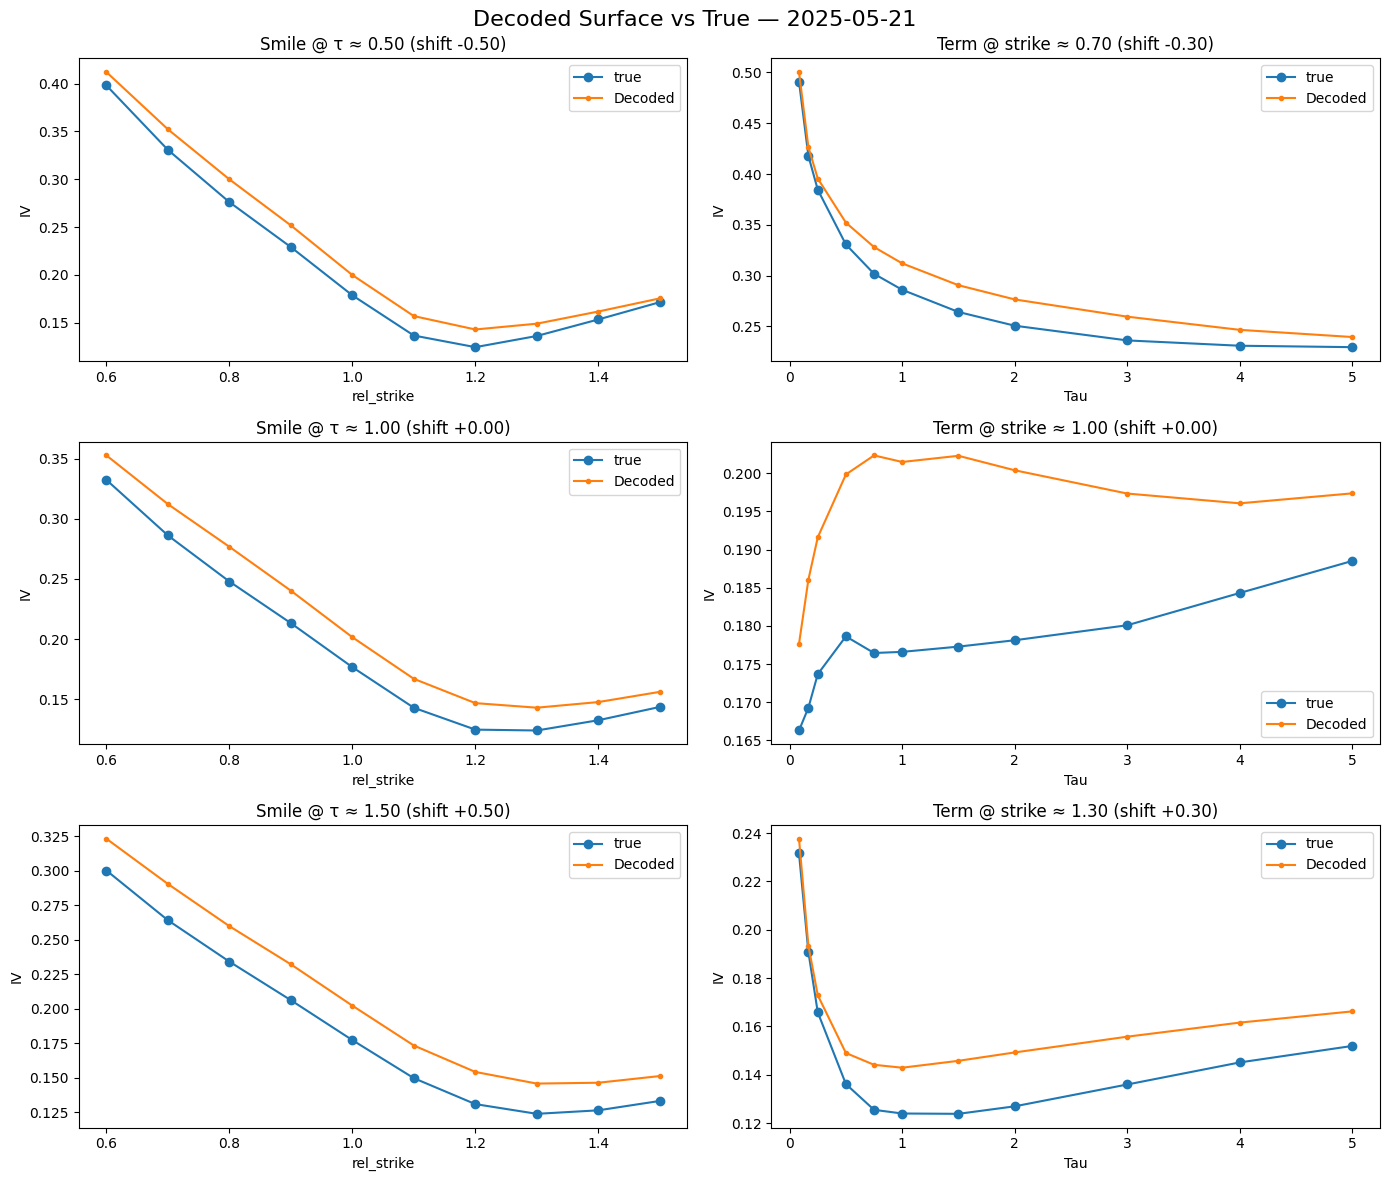

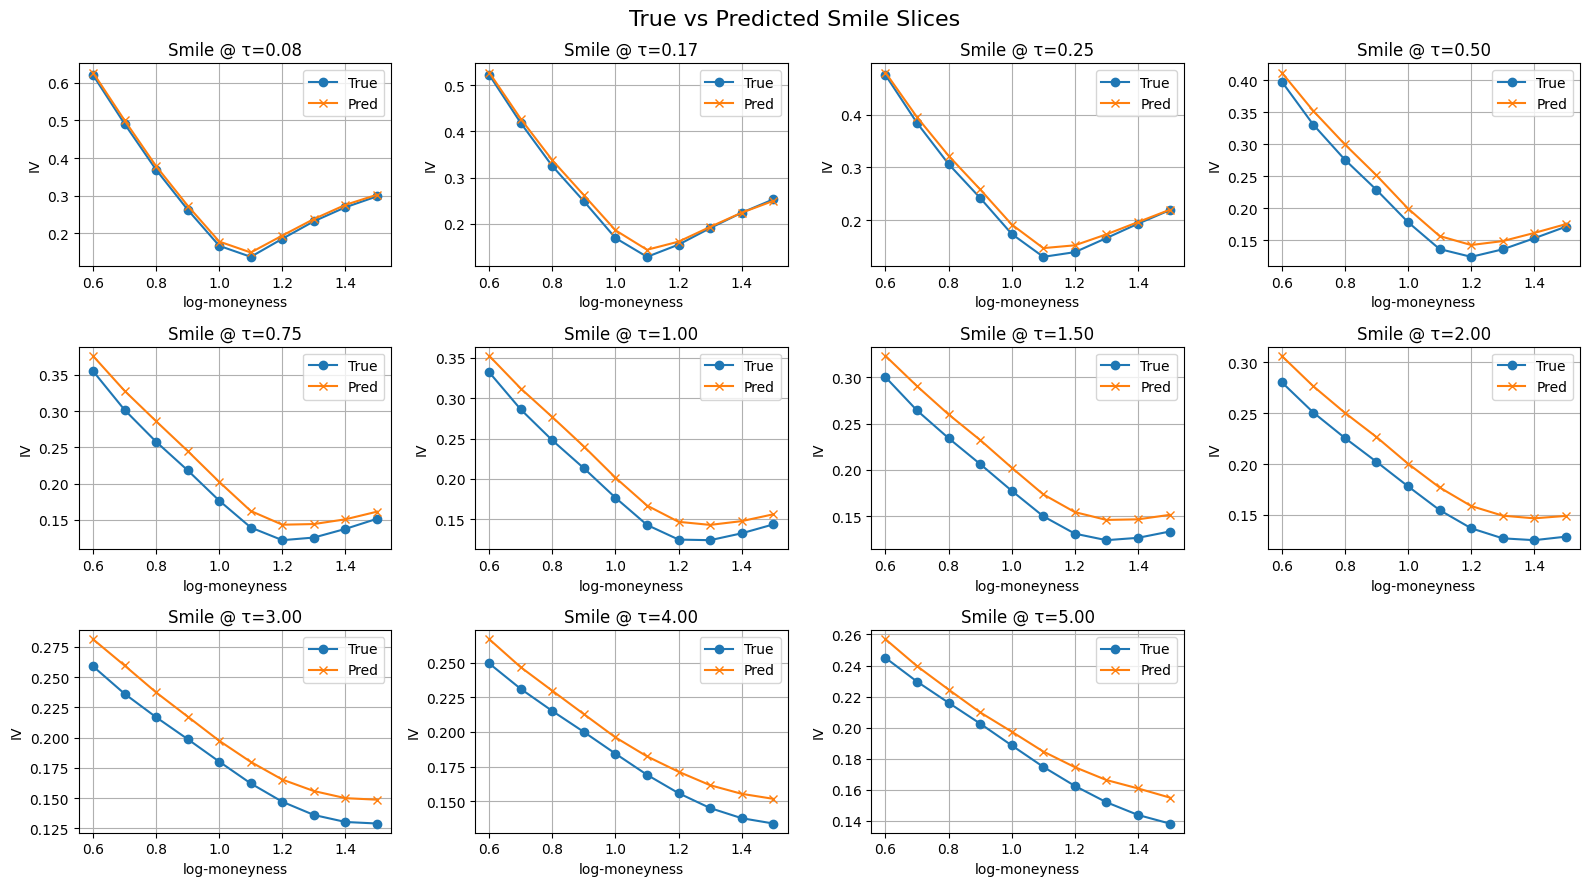

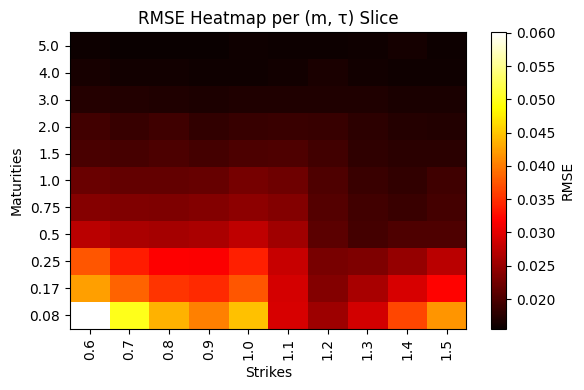

{'rmse_overall': 0.023242686,
 'rmse_by_maturity': array([0.04126611, 0.03327428, 0.02988369, 0.0241758 , 0.02213796,
        0.02084289, 0.01918781, 0.01840734, 0.01698978, 0.01617146,
        0.01580441], dtype=float32),
 'rmse_by_strike': array([0.03046117, 0.02751392, 0.02591535, 0.02529364, 0.02691641,
        0.02287148, 0.02028176, 0.02048706, 0.02196748, 0.02346717],
       dtype=float32)}

In [51]:
import models.decoder
import utils.plotting
import utils.eval
import importlib
importlib.reload(models.decoder)
importlib.reload(utils.plotting)
importlib.reload(utils.eval)

from utils.eval import evaluate_decoder_output_v2

# eval config
Z_eval = Z_decoder            # (N, latent_dim)
F_eval = F_aligned            # (N, feature_dim)
Y_full = Y_decoder            # (N, M*K) flattened ground truth

# get ae baseline surfaces
Y_ae_baseline = decoder.predict(Z_eval, verbose=0)[:, :M*K]  # (N, M*K)

# prepare strike-tau grid
m_grid, tau_grid = np.meshgrid(
  ops.convert_to_numpy(tensors["strike_tensor"]),
  ops.convert_to_numpy(tensors["taus"])
)
m_flat = m_grid.reshape(-1, 1).astype(np.float32)
tau_flat = tau_grid.reshape(-1, 1).astype(np.float32)

# generate mlp residual corrections
Y_residual_corrections = np.stack([
  rl_model.predict_surface(z, f, m_flat, tau_flat)  # pass features f
  for z, f in zip(Z_eval, F_eval)
])

# combine: final = ae baseline + mlp corrections
Y_hat = Y_ae_baseline.reshape(-1, M, K) + Y_residual_corrections.reshape(-1, M, K)

print(f"y_ae_baseline shape: {Y_ae_baseline.shape}")
print(f"y_residual_corrections shape: {Y_residual_corrections.shape}")
print(f"y_hat (final) shape: {Y_hat.shape}")

# evaluate combined model
evaluate_decoder_output_v2(
   Y_pred=Y_hat,                          # ae + mlp corrections
   Y_true=Y_full,                         # ground truth
   tensors=tensors,
   rel_strikes=ops.convert_to_numpy(tensors["strike_tensor"]),
   taus=ops.convert_to_numpy(tensors["taus"]),
   target_date=TARGET_DATE,
   target_tau=TARGET_TAU,
   target_strike=TARGET_STRIKE,
   decoder=rl_model,                      # mlp decoder for penalty calc
   title="AE + MLP Residual Corrections (With Features)"
)

---
---

### Region Approach pre-courseor to moe - DO NOT RUN illustration only , to many models creates problem with uploading them to github! 

---
---

generated 2 residual-sensitive regions
region keys: ['short_term_d0', 'long_term_d0']


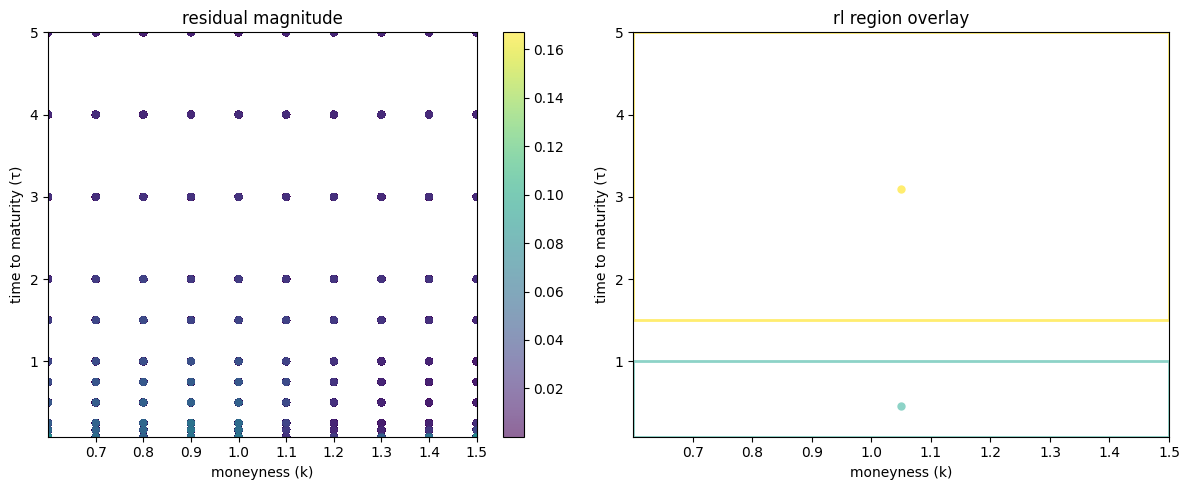

[short_term_d0] region rmse: 0.0248
[long_term_d0] region rmse: 0.0110
[short_term_d0] training on 51060 samples
[long_term_d0] training on 42550 samples


In [53]:
import importlib
import models.rl_decoder
import utils.pointwise_router

importlib.reload(models.rl_decoder)
importlib.reload(utils.pointwise_router)

from models.rl_decoder import PointwiseRLDecoder
from utils.pointwise_router import PointwiseCorrectionRouter
from utils.pointwise_router import generate_residual_masks, visualize_residual_regions

from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import os
import matplotlib.pyplot as plt

# extract coordinates from training data (ae residuals)
k_vals = X_rl_train[1].flatten()      # strike coordinates
tau_vals = X_rl_train[2].flatten()    # tau coordinates 
residuals = Y_rl_train.flatten()      # ae residuals computed earlier

region_config = {
   "method": "hierarchical", 
   "bins_k": 4,                
   "bins_tau": 4,              
   "quantile_thresholds": (0, 1),  
   "n_clusters": 12,
   "max_depth": 3,
   "min_samples": 100,
   "improvement_threshold": 0.001,
   "error_threshold": 0.02,
   "atm_lower": 0.9,
   "atm_upper": 1.10,
   "tau_short": 0.12,
   "tau_mid": 3, 
}

region_masks, region_centers, aux_info, _ = generate_residual_masks(
   k_vals=k_vals,
   tau_vals=tau_vals,
   residuals=residuals,
   **region_config
)

print(f"generated {len(region_masks)} residual-sensitive regions")
print("region keys:", list(region_masks.keys()))

if region_config["method"] == "grid":
   visualize_residual_regions(k_vals, tau_vals, residuals, aux_info, region_masks)
else:
   visualize_residual_regions(k_vals, tau_vals, residuals, region_masks=region_masks)

# instantiate rl router using ae residual-based masks
router = PointwiseCorrectionRouter(
   region_masks=region_masks,
   region_centers=region_centers,
   model_cls=PointwiseRLDecoder,
   model_kwargs={
       "use_delta": False, 
       "normalize_delta": False, 
       "correction_scale": 1.0, 
       "use_bs_loss": True, 
       "taus": ops.convert_to_numpy(tensors["taus"]), 
       "rel_strikes": ops.convert_to_numpy(tensors["strike_tensor"]), 
       "M": M, 
       "K": K
   },
)

# use ae residuals as targets
router.true_targets = Y_rl_train  # ae residuals from computation
router.global_residuals = Y_rl_train.flatten()

router.region_rmse = {}
for name, mask in region_masks.items():
   if np.any(mask):
       router.region_rmse[name] = np.sqrt(np.mean(Y_rl_train[mask]**2))
       print(f"[{name}] region rmse: {router.region_rmse[name]:.4f}")

# compile and train on ae residuals
router.compile_all(optimizer_fn=lambda: Adam(learning_rate=1e-4, clipnorm=1.0))
callbacks = [
   EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True),
   ReduceLROnPlateau(monitor="val_loss", factor=0.66, patience=10, min_lr=1e-7)
]

router.fit_all(
   X_rl_train,     # [z+f, strikes, taus] inputs
   Y_rl_train,     # ae residuals targets
   batch_size=BATCH_SIZE,
   epochs=100,
   validation_data=(X_rl_val, Y_rl_val),  # ae residuals validation
   callbacks=callbacks,
   verbose=0
)

# save all region-specific decoders
os.makedirs("saved_models/rl_decoder", exist_ok=True)
router.save_all("saved_models/rl_decoder/pointwise_rl_{name}.keras")

In [ ]:
# recreate region masks for test data
k_vals_test = X_rl_test[1].flatten()      
tau_vals_test = X_rl_test[2].flatten()   
residuals_test = Y_rl_test.flatten()
region_config["method"] = "hierarchical"

region_masks_test, region_centers_test, aux_info_test, _ = generate_residual_masks(
   k_vals=k_vals_test,
   tau_vals=tau_vals_test,
   residuals=residuals_test,
   **region_config
)

for name, mask in region_masks_test.items():
   print(f"[{name}] mask count: {np.sum(mask)}")

# test specific region
region_name = "short_term_d0"
mask = region_masks_test[region_name]
model = router.models[region_name]

X_mask = [x[mask] for x in X_rl_test]
Y_true_mask = Y_rl_test[mask]           # f use Y_rl_test not y_test_flat
base_mask = ae_test_pointwise[mask] #  define this or use correct var

# get predictions
delta_mask = model.predict(X_mask, batch_size=BATCH_SIZE)

use_delta = getattr(model, "use_delta", True)
IV_corrected_mask = base_mask + delta_mask.flatten() if use_delta else delta_mask.flatten()

import matplotlib.pyplot as plt

# plot distributions
plt.figure(figsize=(6, 3))
plt.hist(IV_corrected_mask, bins=50, alpha=0.6, label="corrected")
plt.hist(base_mask, bins=50, alpha=0.6, label="base")
plt.hist(Y_true_mask, bins=50, alpha=0.6, label="true")
plt.title(f"distribution in region: {region_name}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# compute metrics
rmse = lambda x, y: np.sqrt(np.mean((x - y) ** 2))
print(f"[{region_name}] rmse (base):", rmse(base_mask, Y_true_mask))
print(f"[{region_name}] rmse (corrected):", rmse(IV_corrected_mask, Y_true_mask))

# debug info
print("x_mask length:", len(X_mask), "shapes:", [x.shape for x in X_mask])
print("delta_mask stats:", delta_mask.min(), delta_mask.max(), delta_mask.mean())
print("base_mask stats:", base_mask.min(), base_mask.max())
print("y_true_mask stats:", Y_true_mask.min(), Y_true_mask.max(), Y_true_mask.mean())

print(f"input x_rl_test length: {len(X_rl_test)}")
print(f"number of trained models: {len(router.trained_models)}")

In [ ]:
import importlib
import utils.pointwise_router
importlib.reload(utils.pointwise_router)

from utils.pointwise_router import visualize_residual_regions

# use consistent baseline predictions
IV_pred_flat = ae_test_pointwise.reshape(-1, 1)  # fix: use ae baseline

use_soft_blend = True

# update router with test region centers
router.region_centers = region_centers_test
router.masks = region_masks_test

if use_soft_blend:
   # try original concatenated format for router
   X_rl_concat = np.concatenate([
       X_rl_test[0],  # z+f features
       X_rl_test[1],  # strikes
       X_rl_test[2],  # taus
       ae_test_pointwise.reshape(-1, 1)  # baseline
   ], axis=1)
   X_coord = np.column_stack([k_vals_test, tau_vals_test])
   
   try:
       IV_corrected_flat = router.predict(
           X_full=X_rl_concat,
           X_coord=X_coord,
           base=IV_pred_flat
       )
   except:
       print("soft blend failed, falling back to manual correction")
       use_soft_blend = False

if not use_soft_blend:
   # manual region-by-region correction
   IV_corrected_flat = IV_pred_flat.copy()
   
   for name in router.trained_models:
       mask = region_masks_test[name]
       model = router.models[name]
       
       X_mask = [x[mask] for x in X_rl_test]
       base_mask = IV_pred_flat[mask]
       
       delta_mask = model.predict(X_mask, batch_size=BATCH_SIZE)
       
       if getattr(model, "use_delta", True):
           corrected = base_mask + delta_mask
       else:
           corrected = delta_mask
           
       IV_corrected_flat[mask] = corrected.reshape(-1, 1)

# reshape to surface format
X_pred_rl = IV_corrected_flat.reshape(Z_test.shape[0], M, K)

# evaluate
evaluate_decoder_output(
   decoder=decoder_pw,
   Z_forecast=Z_test,
   X_grid=Y_test.reshape(-1, M, K),
   X_true_idx=None,
   tensors=tensors,
   rel_strikes=ops.convert_to_numpy(tensors["strike_tensor"]),
   taus=ops.convert_to_numpy(tensors["taus"]),
   target_date=TARGET_DATE,
   target_tau=TARGET_TAU,
   target_strike=TARGET_STRIKE,
   decoded_surfaces_override=X_pred_rl,
   title="Decoder + RL Correction (Soft Blend)" if use_soft_blend else "Decoder + RL Correction (Manual)"
)

In [ ]:
import importlib
import models.rl_decoder
import utils.pointwise_router
import pandas as pd
import time

importlib.reload(models.rl_decoder)
importlib.reload(utils.pointwise_router)

from models.rl_decoder import PointwiseRLDecoder
from utils.pointwise_router import PointwiseCorrectionRouter
from utils.pointwise_router import generate_residual_masks

from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np

# use consistent ae residual approach
X_rl = X_rl_test      # [z+f, strikes, taus] from ae residual setup
Y_rl = Y_rl_test      # ae residuals targets
use_delta = True

# extract coordinates from test data
k_vals = X_rl_test[1].flatten()     # strike coordinates
tau_vals = X_rl_test[2].flatten()   # tau coordinates
residuals = Y_rl_test.flatten()     # ae residuals

# use ae baseline for evaluation
ae_test_baseline = ae_test_pred  # already computed earlier
ae_test_baseline_flat = ae_test_pointwise.reshape(-1, 1)  # use pointwise version

methods_to_test = [
   "grid", "fixed_grid", "atm_term_structure", "smile_slice",
   "pca", "kmeans", "spatial_kmeans", "term_structure",
   "hierarchical", "adaptive_error", "gamma_based", 
   "multi_greek", "hybrid_fixed_adaptive"
]

base_config = {
   "bins_k": 4,                
   "bins_tau": 4,              
   "quantile_thresholds": (0, 1),  
   "n_clusters": 8,
   "max_depth": 3,
   "min_samples": 100,
   "improvement_threshold": 0.001,
   "error_threshold": 0.02,
   "atm_lower": 0.9,
   "atm_upper": 1.10,
   "tau_short": 0.5,
   "tau_mid": 2.0, 
}


In [ ]:

def get_patch_scaling(region_name):
   """scale corrections based on region characteristics"""
   name = region_name.lower()
   
   if "high_gamma" in name:
       return 3.0
   elif "med_gamma" in name or "wings" in name or "wing" in name:
       return 1.5
   elif "safe" in name or "low_gamma" in name or "long" in name:
       return 0.8
   elif "high_error" in name or "ultra" in name or "danger" in name:
       return 2.5
   elif "moderate" in name or "medium" in name or "mid" in name:
       return 1.3
   elif "low_error" in name:
       return 0.7
   elif "atm" in name and ("short" in name or any(t in name for t in ["0.08", "0.17", "0.25"])):
       return 2.0
   elif "atm" in name:
       return 1.2
   else:
       return 1.0

class ScaledPointwiseCorrectionRouter(PointwiseCorrectionRouter):
   """router with region-specific scaling"""
   def merge_predictions(self, base, delta, debug=False):
       corrected = np.copy(base).reshape(-1, 1)
       start = 0
       
       for name in self.models:
           if name not in self.trained_models:
               continue

           mask = self.masks[name]
           count = np.sum(mask)
           patch = delta[start:start + count].reshape(-1, 1)

           # apply region-specific scaling
           scale_factor = get_patch_scaling(name)
           patch = patch * scale_factor

           if getattr(self.models[name], "use_delta", True):
               corrected[mask] = base[mask] + patch
           else:
               corrected[mask] = patch

           start += count

       return corrected


In [ ]:

results = []

# calculate baseline rmse using ae baseline vs ground truth
y_test_flat = y_test.flatten()  # ground truth pointwise
ae_baseline_rmse = np.sqrt(np.mean((y_test_flat - ae_test_baseline_flat.flatten())**2))
baseline_rmse = ae_baseline_rmse

print(f"ae baseline rmse: {baseline_rmse:.6f}")
print("starting router method evaluation...")

for method in methods_to_test:
   print(f"testing method: {method}")
   method_start_time = time.time()
   
   try:
       region_config = base_config.copy()
       region_config["method"] = method
       
       region_masks, region_centers, aux_info, _ = generate_residual_masks(
           k_vals=k_vals,
           tau_vals=tau_vals,
           residuals=residuals,
           **region_config
       )
       
       n_regions = len(region_masks)
       region_names = list(region_masks.keys())
       
       valid_regions = {name: mask for name, mask in region_masks.items() 
                       if np.sum(mask) >= base_config["min_samples"]}
       
       if len(valid_regions) < 2:
           results.append({
               'method': method,
               'rmse': np.nan,
               'improvement_vs_baseline': np.nan,
               'n_regions': n_regions,
               'valid_regions': len(valid_regions),
               'region_names': str(region_names),
               'status': 'insufficient_regions',
               'training_time': 0
           })
           continue
       
       router = ScaledPointwiseCorrectionRouter(
           region_masks=region_masks,
           region_centers=region_centers,
           model_cls=PointwiseRLDecoder,
           model_kwargs={
               "use_delta": False, 
               "normalize_delta": False, 
               "correction_scale": 1,
               "use_bs_loss": True, 
               "taus": ops.convert_to_numpy(tensors["taus"]), 
               "rel_strikes": ops.convert_to_numpy(tensors["strike_tensor"]), 
               "M": M, 
               "K": K
           }
       )
       
       router.compile_all(optimizer_fn=lambda: Adam(learning_rate=5e-5, clipnorm=1.0))
       callbacks = [
           EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
           ReduceLROnPlateau(monitor="val_loss", factor=0.7, patience=5, min_lr=1e-8)
       ]
       
       router.fit_all(
           X_rl,
           Y_rl,
           batch_size=128,
           epochs=100,
           validation_split=0.2,
           callbacks=callbacks,
           verbose=0
       )
       
       # manual evaluation using ae baseline + residual corrections
       IV_corrected_flat = ae_test_baseline_flat.copy()
       
       for name in router.trained_models:
           mask = region_masks[name]
           model = router.models[name]
           
           X_mask = [x[mask] for x in X_rl_test]
           base_mask = ae_test_baseline_flat[mask]
           
           delta_mask = model.predict(X_mask, batch_size=128)
           scale_factor = get_patch_scaling(name)
           
           if getattr(model, "use_delta", True):
               corrected = base_mask + (delta_mask * scale_factor)
           else:
               # model predicts residual directly
               corrected = base_mask + (delta_mask * scale_factor)
               
           IV_corrected_flat[mask] = corrected.reshape(-1, 1)
       
       # final rmse: corrected predictions vs ground truth
       final_rmse = np.sqrt(np.mean((y_test_flat - IV_corrected_flat.flatten())**2))
       improvement = (baseline_rmse - final_rmse) / baseline_rmse * 100
       
       training_time = time.time() - method_start_time
       
       results.append({
           'method': method,
           'rmse': final_rmse,
           'improvement_vs_baseline': improvement,
           'n_regions': n_regions,
           'valid_regions': len(valid_regions),
           'region_names': str(region_names),
           'status': 'success',
           'training_time': training_time
       })
       
   except Exception as e:
       results.append({
           'method': method,
           'rmse': np.nan,
           'improvement_vs_baseline': np.nan,
           'n_regions': 0,
           'valid_regions': 0,
           'region_names': '',
           'status': f'error: {str(e)[:50]}',
           'training_time': time.time() - method_start_time
       })

df_results = pd.DataFrame(results)
df_results = df_results.sort_values('rmse', ascending=True)

best_method = df_results.iloc[0]
if pd.notna(best_method['rmse']):
   print(f"\nbest method: {best_method['method']}")
   print(f"rmse: {best_method['rmse']:.6f} ({best_method['improvement_vs_baseline']:+.1f}% vs ae baseline)")
else:
   print("\nno method beat the ae baseline")

df_results.to_csv('regional_method_comparison_ae.csv', index=False)
print(f"results saved to regional_method_comparison_ae.csv")